# Previsão da Progressão dos Casos Confirmados de COVID19 por Estado no Brasil

### 

### E aí suave!? Meu nome é Pedro Garcia e além de ser discente do 6º período de Estatística na UFU também sou estudante de Data Science há quase três meses. Durante esse período busquei conhecimento em diversas plataformas gratuitas e livros sobre o assunto, tanto na parte técnica quanto na mercadológica.
### Entretanto, um grande desafio pra mim foi aplicar tudo que vi tanto no curso de Estatística quanto nos estudos de Data Science, Machine Learning (ML) e afins em um projeto prático. Confesso que a construção do projeto não foi fácil, pois inicialmente eu não tinha muita noção de como manipular dados (pandas é o excel de luxo), criar visualizações básicas (matplotlib + seaborn = obras de arte) e aplicar metodologias de Machine Learning (sklearn faz mágica), tudo isso utilizando Python (meu conhecimento em R chora).
### Contudo, a motivação de entregar algum valor com o que aprendi até o momento e principalmente em uma situação onde o mundo todo está sofrendo com o COVID19, foi de fato muito maior que qualquer barreira de conhecimento. Assim sendo, durante todo o processo desde o tratamento e transformação dos dados (constatei a afirmação de que o fucking Cientista de Dados fica 99,9% do tempo nesse rolê e no período restante ele fica tentando melhorar a performance do modelo em 0,01% hahaha, as outras etapas praticamente fazem figuração de tapete. DRAMATIZAÇÃO ON!) até a criação das últimas visualizações das previsões por estado.
### Porém, apesar desses 'perrengues', aprendi bastante com todo esse processo que se repete bastante (atualiza dados, corrige erros, visualiza, corrige erros, retira insights, corrige erros, cria variáveis, corrige erros, modela, corrige erros, analisa, corrige erros... até chegar a um bom resultado inicial e a partir daí progredir sob demanda). Mencionei bastante a parte de 'corrige erros' pois o que errei durante essas etapas não tá escrito, tá cofificado hahaha! É claro que essa situação fortalece ainda mais a curva de aprendizagem, uma vez que assimilamos mais com os erros. Logo, atualmente com todo esse trabalho estou bem mais capacidado a enfrentar novos desafios e a evoluir ainda mais com a experiência adquirida.
### Falando mais sobre o desenvolvimento do estudo, sinta-se a vontade para criticar as metodologias adotadas, visualizações utilizadas, codificações e decisões tomadas. No entanto, não apenas critique mas também sugira melhorias que possam ser feitas. Desde já agradeço pela atenção, deixarei meus contatos no final caso tenha alguma dúvida, crítica ou sugestão. Para aqueles que desejam explorar uma parte específica do estudo, o projeto está dividido em Processamento dos Dados, Visualização dos Dados, Feature Engineering / Criação de Variáveis , Modelagem, Forecast/Previsões e Considerações Finais, respectivamente, sendo que cada um possue descrições e interpretações dos procedimentos realizados. Boa leitura!
### 
### Whatsapp : (34) 99248-9512 
### e-mail : pedroaugustogarciasantos@hotmail.com
### LinkedIn : https://www.linkedin.com/in/pedro-garcia-823224151/

## 

# Importando Módulos

In [2]:
#Data Wrangling
from datetime import datetime as dt
import os
import pandas as pd
import numpy as np

#View
import matplotlib.pyplot as plt
import seaborn as sns

#Data Transform
from geopy.geocoders import Nominatim
from category_encoders import OneHotEncoder
import geopy.distance

#Web Scraping
from tabulate import tabulate
import urllib.request
from bs4 import BeautifulSoup
import requests

#Machine Learning - Algorithms
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

#Machine Learning - Tunning
from skopt import dummy_minimize
from skopt import gp_minimize
from skopt.plots import plot_convergence

#Machine Learning - Save
from sklearn.externals import joblib

#Ocult Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Processing

In [8]:
#Carregando Dados
df = pd.read_csv("C:/Users/KÁTIA/Desktop/EVOLUTION 2020/COVID/UPDATE/brazil_covid19.csv",sep=',')
df

date        region               state  cases  deaths
0     2020-01-30  Centro-Oeste    Distrito Federal      0       0
1     2020-01-30  Centro-Oeste               Goiás      0       0
2     2020-01-30  Centro-Oeste         Mato Grosso      0       0
3     2020-01-30  Centro-Oeste  Mato Grosso do Sul      0       0
4     2020-01-30      Nordeste             Alagoas      0       0
...          ...           ...                 ...    ...     ...
1912  2020-04-09       Sudeste      Rio de Janeiro   2216     122
1913  2020-04-09       Sudeste           São Paulo   7480     496
1914  2020-04-09           Sul              Paraná    609      22
1915  2020-04-09           Sul   Rio Grande do Sul    618      12
1916  2020-04-09           Sul      Santa Catarina    501      17

[1917 rows x 5 columns]

In [9]:
#Removendo coluna 'region'
df=df.drop(columns='region')

#Convertendo 'date' de string para datetime
df.date=pd.to_datetime(df.date)

#Ordenando dartagrame por estado e data
df=df.sort_values(by=['state','date'])

df

date      state  cases  deaths
13   2020-01-30       Acre      0       0
40   2020-01-31       Acre      0       0
67   2020-02-01       Acre      0       0
94   2020-02-02       Acre      0       0
121  2020-02-03       Acre      0       0
...         ...        ...    ...     ...
1801 2020-04-05  Tocantins     17       0
1828 2020-04-06  Tocantins     17       0
1855 2020-04-07  Tocantins     19       0
1882 2020-04-08  Tocantins     23       0
1909 2020-04-09  Tocantins     23       0

[1917 rows x 4 columns]

## Adicionando Geolocalização por Estado
### Para inferir se a proximidade de estados com grandes volumes de casos tem impacto na disseminação do vírus em outros estados

In [10]:
#Criando subset com apenas os estados
df_state = df.groupby("state").last().drop(columns=['date'])
df_state.head()

cases  deaths
state                  
Acre         62       2
Alagoas      37       3
Amapá       128       2
Amazonas    899      40
Bahia       559      19

In [11]:
#Criando funções que adicionam a geocalização por estado
geolocator = Nominatim(user_agent="Corona")
def getLat(row):
  location = geolocator.geocode(f"{row.name}, Brazil")
  return location.latitude

def getLong(row):
  location = geolocator.geocode(f"{row.name}, Brazil")
  return location.longitude

#Adicionando variáveis de latitude e longitude
df_state['Latitude'] = df_state.apply(getLat, axis='columns')
df_state['Longitude'] = df_state.apply(getLong, axis='columns')
df_state.head()

cases  deaths   Latitude  Longitude
state                                        
Acre         62       2  -9.047868 -70.526498
Alagoas      37       3  -9.661166 -36.650243
Amapá       128       2   1.354544 -51.916198
Amazonas    899      40  -4.479925 -63.518540
Bahia       559      19 -12.285251 -41.929478

In [12]:
#Juntando os dados
df = df.merge(df_state[['Latitude','Longitude']], how="left", on="state")
df.head(1)

date state  cases  deaths  Latitude  Longitude
0 2020-01-30  Acre      0       0 -9.047868 -70.526498

## Incrementando a densidade demográfica (hab/km²) e a área (km) de cada estado com com Web Scraping
### Com finalidade de captar algum relacionamento com o volume de casos

In [13]:
#Retirando os dados da web
res=requests.get('https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_densidade_demogr%C3%A1fica')
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]

#Criando dataframe
densidade = pd.read_html(str(table))
densidade = pd.DataFrame(densidade)
densidade = densidade[0][0]
densidade.tail(5)

Posição Unidade federativa    Área (km²) População(censo 2010)  \
22       23          Tocantins    277.720404             1.383.445   
23       24               Acre    164.123738               733.559   
24       25        Mato Grosso    903.206997             3.035.122   
25       27            Roraima    224.273831               450.479   
26       26           Amazonas  1.559.168117             3.483.985   

    Densidadedemográfica (censo 2010) População (projeção 2019)  \
22                                498                 1.572.866   
23                                447                   881.935   
24                                336                 3.484.466   
25                                201                   605.761   
26                                223                 4.144.597   

    Densidade demográfica (projeção 2019)  
22                                    566  
23                                    537  
24                                    386  
25                                    270  
26                                    266

In [14]:
#Ajustando e juntando os datasets
densidade.columns=['p','state','area_state','População2010','Densidade2010','Pop_2019','Densidade']
densidade=densidade.set_index(densidade.state)
df=df.merge(densidade[['Densidade','area_state']], how="left", on="state")

#Ajustando a densidade
df.Densidade=df.Densidade/100

#Ajustando coluna de string para float
df.area_state = df.area_state.replace("1.245.759305","1245.759305")
df.area_state = df.area_state.replace("1.559.168117","1559.168117")
df.area_state = df.area_state.astype(float)
df.area_state = df.area_state*1000
df.head()

date state  cases  deaths  Latitude  Longitude  Densidade  area_state
0 2020-01-30  Acre      0       0 -9.047868 -70.526498       5.37  164123.738
1 2020-01-31  Acre      0       0 -9.047868 -70.526498       5.37  164123.738
2 2020-02-01  Acre      0       0 -9.047868 -70.526498       5.37  164123.738
3 2020-02-02  Acre      0       0 -9.047868 -70.526498       5.37  164123.738
4 2020-02-03  Acre      0       0 -9.047868 -70.526498       5.37  164123.738

## Incluindo a UF e região de cada estado

In [15]:
#Retirando dados da web
res=requests.get('https://www.estadosecapitaisdobrasil.com/')
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]

#Criando dataframe
uf_reg = pd.read_html(str(table))
uf_reg=pd.DataFrame(uf_reg)
uf_reg=uf_reg[0][0]
uf_reg.head(2)

Bandeira  Curtir   Estado Sigla     Capital    Região
0       NaN     NaN     Acre    AC  Rio Branco     Norte
1       NaN     NaN  Alagoas    AL      Maceió  Nordeste

In [16]:
#Renomeando e definindo com índice a coluna chave do dataframe
uf_reg=uf_reg.rename(columns={'Estado':'state','Sigla':'UF'})
uf_reg=uf_reg.set_index(uf_reg.state)
uf_reg.head(1)

Bandeira  Curtir state  UF     Capital Região
state                                               
Acre        NaN     NaN  Acre  AC  Rio Branco  Norte

In [17]:
#Juntando os datasets
df=df.merge(uf_reg[['Região','UF']],how="left",on='state')
df

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  
0     164123.738  Norte  AC  
1     164123.738  Norte  AC  
2     164123.738  Norte  AC  
3     164123.738  Norte  AC  
4     164123.738  Norte  AC  
...          ...    ...  ..  
1912  277720.404  Norte  TO  
1913  277720.404  Norte  TO  
1914  277720.404  Norte  TO  
1915  277720.404  Norte  TO  
1916  277720.404  Norte  TO  

[1917 rows x 10 columns]

## Adicionando a população estimada dos estados de 2019

In [18]:
#Carregando o dataset
pop=pd.read_csv('C:/Users/KÁTIA/Desktop/EVOLUTION 2020/COVID/UPDATE/populacao-estimada-estados-2019.csv',sep=';')
pop=pop.set_index(pop.UF)
pop.tail(5)

UF                City  Population_2019
UF                                         
RS  RS   Rio Grande do Sul         11377239
MS  MS  Mato Grosso do Sul          2778986
MT  MT         Mato Grosso          3484466
GO  GO               Goiás          7018354
DF  DF    Distrito Federal          3015268

In [19]:
#Agregando ao dataset base
df = df.merge(pop[['Population_2019']],how='left',on='UF')
df.tail(1)

date      state  cases  deaths   Latitude  Longitude  Densidade  \
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  Population_2019  
1916  277720.404  Norte  TO          1572866

## Criando variável 'Day'
### Para contabilizar o número de dias após o primeiro caso suspeito

In [20]:
#Datas únicas de forma ordenada
df.date.unique()

#Criando dataframe
start=pd.DataFrame(np.arange(1,len(df.date.unique())+1),index=df.date.unique(),columns=['Day'])
start.index.name='date'
start.Day.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71])

In [21]:
#Juntando os dataframes
df=df.merge(start['Day'], how='left', on='date')
df

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  Population_2019  Day  
0     164123.738  Norte  AC           881935    1  
1     164123.738  Norte  AC           881935    2  
2     164123.738  Norte  AC           881935    3  
3     164123.738  Norte  AC           881935    4  
4     164123.738  Norte  AC           881935    5  
...          ...    ...  ..              ...  ...  
1912  277720.404  Norte  TO          1572866   67  
1913  277720.404  Norte  TO          1572866   68  
1914  277720.404  Norte  TO          1572866   69  
1915  277720.404  Norte  TO          1572866   70  
1916  277720.404  Norte  TO          1572866   71  

[1917 rows x 12 columns]

## Criando outras variáveis derivadas
### Criando as variáveis de novos casos confirmados e de óbitos ao decorrer dos dias, uma vez que o dataset mostra a soma dos casos acumulados

In [22]:
df['new_cases']=df.groupby('state').cases.diff()
df['new_deaths']=df.groupby('state').deaths.diff()
df[df['state']=='São Paulo'].tail(10)

date      state  cases  deaths   Latitude  Longitude  Densidade  \
1836 2020-03-31  São Paulo   2339     136 -23.550651 -46.633382     184.99   
1837 2020-04-01  São Paulo   2981     164 -23.550651 -46.633382     184.99   
1838 2020-04-02  São Paulo   3506     188 -23.550651 -46.633382     184.99   
1839 2020-04-03  São Paulo   4048     219 -23.550651 -46.633382     184.99   
1840 2020-04-04  São Paulo   4466     260 -23.550651 -46.633382     184.99   
1841 2020-04-05  São Paulo   4620     275 -23.550651 -46.633382     184.99   
1842 2020-04-06  São Paulo   4866     304 -23.550651 -46.633382     184.99   
1843 2020-04-07  São Paulo   5682     371 -23.550651 -46.633382     184.99   
1844 2020-04-08  São Paulo   6708     428 -23.550651 -46.633382     184.99   
1845 2020-04-09  São Paulo   7480     496 -23.550651 -46.633382     184.99   

      area_state   Região  UF  Population_2019  Day  new_cases  new_deaths  
1836  248219.481  Sudeste  SP         45919049   62      822.0        23.0  
1837  248219.481  Sudeste  SP         45919049   63      642.0        28.0  
1838  248219.481  Sudeste  SP         45919049   64      525.0        24.0  
1839  248219.481  Sudeste  SP         45919049   65      542.0        31.0  
1840  248219.481  Sudeste  SP         45919049   66      418.0        41.0  
1841  248219.481  Sudeste  SP         45919049   67      154.0        15.0  
1842  248219.481  Sudeste  SP         45919049   68      246.0        29.0  
1843  248219.481  Sudeste  SP         45919049   69      816.0        67.0  
1844  248219.481  Sudeste  SP         45919049   70     1026.0        57.0  
1845  248219.481  Sudeste  SP         45919049   71      772.0        68.0

## Criando variáveis sazonais
### Com objetivo de captar alguma mudança ao longo do tempo

In [23]:
#Criando variáveis que transformem a data no dia, dia da semana, mês e dia do ano em formato numérico
df['Semana_do_Ano']=df.date.dt.weekofyear
df['Dia_do_Ano']=df.date.dt.dayofyear
df['Mes']=df.date.dt.month
df['Dia']=df.date.dt.day
df

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  Population_2019  Day  new_cases  new_deaths  \
0     164123.738  Norte  AC           881935    1        NaN         NaN   
1     164123.738  Norte  AC           881935    2        0.0         0.0   
2     164123.738  Norte  AC           881935    3        0.0         0.0   
3     164123.738  Norte  AC           881935    4        0.0         0.0   
4     164123.738  Norte  AC           881935    5        0.0         0.0   
...          ...    ...  ..              ...  ...        ...         ...   
1912  277720.404  Norte  TO          1572866   67        3.0         0.0   
1913  277720.404  Norte  TO          1572866   68        0.0         0.0   
1914  277720.404  Norte  TO          1572866   69        2.0         0.0   
1915  277720.404  Norte  TO          1572866   70        4.0         0.0   
1916  277720.404  Norte  TO          1572866   71        0.0         0.0   

      Semana_do_Ano  Dia_do_Ano  Mes  Dia  
0                 5          30    1   30  
1                 5          31    1   31  
2                 5          32    2    1  
3                 5          33    2    2  
4                 6          34    2    3  
...             ...         ...  ...  ...  
1912             14          96    4    5  
1913             15          97    4    6  
1914             15          98    4    7  
1915             15          99    4    8  
1916             15         100    4    9  

[1917 rows x 18 columns]

## Variável sazonal que marca as medidas tomadas contra o surto
### Identificar e diferenciar dias onde o governo tomou alguma medida seja de isolamento, vacina ou algo relacionado

In [24]:
#Declaração de Quarentena: 2020-03-18
#Criando variáveis diferenciando os dias com e sem quarentena em formato binário e de contagem
#Variável Binária: Dias anteriores sem quarentena serão atribuidos como zero e os posteriores como 1
#Variável Inteira de Contagem: Contagem dos dias após a decalaração de isolamento social

#Criando colunas com essas variáveis no dataframe original com valores nulos para serem atribuidos posteriormente
df['Isolamento']=np.nan
df['Dias_de_Isolamento']=np.nan

#Separando dados entre os dias sem e com quarentena
antes=df[df['date']<'2020-03-18'].copy()
depois=df[df['date']>='2020-03-18'].copy()

#Atribuindo os valores para o antes
antes['Isolamento']=0
antes['Dias_de_Isolamento']=0

#Atribuindo os valores para o depois
depois['Isolamento']=1

#Datas únicas dos dias de isolamento de forma ordenada
depois.date.unique()

#Criando dataframe para contabilizar os dias de isolamento
start=pd.DataFrame(np.arange(1,len(depois.date.unique())+1),index=depois.date.unique(),columns=['Dias_de_Isolamento'])
start.index.name='date'
start.Dias_de_Isolamento.values

#Juntando os dataframes
depois=depois.drop('Dias_de_Isolamento',axis=1)
depois=depois.merge(start['Dias_de_Isolamento'], how='left', on='date')

#Outra opção para a variável binária de forma simplificada
#df['Isolamento']=df.date.map(lambda x: 0 if < '2020-03-18' else 1)

#Dataframame final com a concatenação das duas partes
df=pd.concat([antes,depois]).reset_index(level=0,drop=True)
df

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  Population_2019  Day  new_cases  new_deaths  \
0     164123.738  Norte  AC           881935    1        NaN         NaN   
1     164123.738  Norte  AC           881935    2        0.0         0.0   
2     164123.738  Norte  AC           881935    3        0.0         0.0   
3     164123.738  Norte  AC           881935    4        0.0         0.0   
4     164123.738  Norte  AC           881935    5        0.0         0.0   
...          ...    ...  ..              ...  ...        ...         ...   
1912  277720.404  Norte  TO          1572866   67        3.0         0.0   
1913  277720.404  Norte  TO          1572866   68        0.0         0.0   
1914  277720.404  Norte  TO          1572866   69        2.0         0.0   
1915  277720.404  Norte  TO          1572866   70        4.0         0.0   
1916  277720.404  Norte  TO          1572866   71        0.0         0.0   

      Semana_do_Ano  Dia_do_Ano  Mes  Dia  Isolamento  Dias_de_Isolamento  
0                 5          30    1   30           0                   0  
1                 5          31    1   31           0                   0  
2                 5          32    2    1           0                   0  
3                 5          33    2    2           0                   0  
4                 6          34    2    3           0                   0  
...             ...         ...  ...  ...         ...                 ...  
1912             14          96    4    5           1                  19  
1913             15          97    4    6           1                  20  
1914             15          98    4    7           1                  21  
1915             15          99    4    8           1                  22  
1916             15         100    4    9           1                  23  

[1917 rows x 20 columns]

## Índice de Isolamento Social Brasileiro
### Essa variável é calculada pela inloco (https://www.inloco.com.br/pt/) com base no rastreio via GPS dos celulares de parte da população brasileira, identificando a movimentação dos mesmos. O objetivo de adicionar essa informação é aumentar o entendimento sobre a efetividade das medidas de quarentena adotadas pelo governo. A princípio é uma métrica geral do Brasil, mas em breve podem ser divulgadas informações divididas por estado, facilitando ainda mais a identificação de padrões específicos.

In [25]:
#Carregando  e ajustando  os dados
quarentena = pd.read_csv("C:/Users/KÁTIA/Desktop/EVOLUTION 2020/COVID/UPDATE/indice_isolamento_social_br.csv",sep=";")
quarentena.date = pd.to_datetime(quarentena.date)
quarentena

date  IIS_BR
0  2020-02-01    25.0
1  2020-02-02    32.4
2  2020-02-03    20.3
3  2020-02-04    21.0
4  2020-02-05    21.0
..        ...     ...
63 2020-04-04    53.9
64 2020-04-05    62.2
65 2020-04-06    50.7
66 2020-04-07    49.5
67 2020-04-08    49.0

[68 rows x 2 columns]

In [26]:
#Definir date como index do dataframe
quarentena = quarentena.set_index(quarentena.date)

#Juntando essa variável ao dataframe
df = df.merge(quarentena["IIS_BR"],how="left",on="date")
df

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  Day  new_cases  new_deaths  Semana_do_Ano  \
0     164123.738  Norte  AC  ...    1        NaN         NaN              5   
1     164123.738  Norte  AC  ...    2        0.0         0.0              5   
2     164123.738  Norte  AC  ...    3        0.0         0.0              5   
3     164123.738  Norte  AC  ...    4        0.0         0.0              5   
4     164123.738  Norte  AC  ...    5        0.0         0.0              6   
...          ...    ...  ..  ...  ...        ...         ...            ...   
1912  277720.404  Norte  TO  ...   67        3.0         0.0             14   
1913  277720.404  Norte  TO  ...   68        0.0         0.0             15   
1914  277720.404  Norte  TO  ...   69        2.0         0.0             15   
1915  277720.404  Norte  TO  ...   70        4.0         0.0             15   
1916  277720.404  Norte  TO  ...   71        0.0         0.0             15   

      Dia_do_Ano  Mes  Dia  Isolamento  Dias_de_Isolamento  IIS_BR  
0             30    1   30           0                   0     NaN  
1             31    1   31           0                   0     NaN  
2             32    2    1           0                   0    25.0  
3             33    2    2           0                   0    32.4  
4             34    2    3           0                   0    20.3  
...          ...  ...  ...         ...                 ...     ...  
1912          96    4    5           1                  19    62.2  
1913          97    4    6           1                  20    50.7  
1914          98    4    7           1                  21    49.5  
1915          99    4    8           1                  22    49.0  
1916         100    4    9           1                  23     NaN  

[1917 rows x 21 columns]

## Índice de Isolamento Social pelo Número de Casos Confirmados
### Com objetivo de metrificar a efetividade do isolamento ao longo do tempo, de maneira geral
### *IIS(%)/Casos* - Para cada % de pessoas que estão respeitando o isolamento social, temos 1 infectado no Brasil. Deste modo, quanto maior o percentual, melhor.

In [27]:
#Criando feature
df['IIS_per_Cases']=df.IIS_BR/df.cases
df.tail()

date      state  cases  deaths   Latitude  Longitude  Densidade  \
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  new_cases  new_deaths  Semana_do_Ano  \
1912  277720.404  Norte  TO  ...        3.0         0.0             14   
1913  277720.404  Norte  TO  ...        0.0         0.0             15   
1914  277720.404  Norte  TO  ...        2.0         0.0             15   
1915  277720.404  Norte  TO  ...        4.0         0.0             15   
1916  277720.404  Norte  TO  ...        0.0         0.0             15   

      Dia_do_Ano  Mes  Dia  Isolamento  Dias_de_Isolamento  IIS_BR  \
1912          96    4    5           1                  19    62.2   
1913          97    4    6           1                  20    50.7   
1914          98    4    7           1                  21    49.5   
1915          99    4    8           1                  22    49.0   
1916         100    4    9           1                  23     NaN   

      IIS_per_Cases  
1912       3.658824  
1913       2.982353  
1914       2.605263  
1915       2.130435  
1916            NaN  

[5 rows x 22 columns]

## Criando variáveis municipais agregadas por estado que possuem casos confirmados de COVID19 ao decorrer do tempo
### Objetivando entender ainda mais como, onde e quanto o COVID19 está se propagando

In [28]:
#Carregando e ajustando o dataset base
date_city = pd.read_csv("C:/Users/KÁTIA/Desktop/EVOLUTION 2020/COVID/UPDATE/cases-brazil-cities-time.csv",sep=',')
date_city.date = pd.to_datetime(date_city.date)
date_city.head(5)

date country  state          city   ibgeID  deaths  newCases  \
0 2020-02-25  Brazil     SP  São Paulo/SP  3550308       0         1   
1 2020-02-25  Brazil  TOTAL         TOTAL        0       0         1   
2 2020-02-26  Brazil     SP  São Paulo/SP  3550308       0         0   
3 2020-02-26  Brazil  TOTAL         TOTAL        0       0         0   
4 2020-02-27  Brazil     SP  São Paulo/SP  3550308       0         0   

   totalCases  
0           1  
1           1  
2           1  
3           1  
4           1

In [29]:
#Selecionar dataframe sem o total por dia
date_city=date_city[date_city['ibgeID']!=0].reset_index(level=0,drop=True)
date_city.head(5)

date country state          city   ibgeID  deaths  newCases  \
0 2020-02-25  Brazil    SP  São Paulo/SP  3550308       0         1   
1 2020-02-26  Brazil    SP  São Paulo/SP  3550308       0         0   
2 2020-02-27  Brazil    SP  São Paulo/SP  3550308       0         0   
3 2020-02-28  Brazil    SP  São Paulo/SP  3550308       0         1   
4 2020-02-29  Brazil    SP  São Paulo/SP  3550308       0         0   

   totalCases  
0           1  
1           1  
2           1  
3           2  
4           2

In [30]:
#Carregando dataset com informação da população de 2019 das cidades
pop_city =pd.read_csv("C:/Users/KÁTIA/Desktop/EVOLUTION 2020/COVID/UPDATE/populacao-estimada-2019.csv",sep=',')
pop_city

state  state_ibge_code  city_ibge_code            city  \
0       AC               12         1200013      Acrelândia   
1       AC               12         1200054    Assis Brasil   
2       AC               12         1200104       Brasiléia   
3       AC               12         1200138          Bujari   
4       AC               12         1200179        Capixaba   
...    ...              ...             ...             ...   
5565    TO               17         1721208  Tocantinópolis   
5566    TO               17         1721257        Tupirama   
5567    TO               17         1721307      Tupiratins   
5568    TO               17         1722081    Wanderlândia   
5569    TO               17         1722107         Xambioá   

      estimated_population  
0                    15256  
1                     7417  
2                    26278  
3                    10266  
4                    11733  
...                    ...  
5565                 22870  
5566                  1891  
5567                  2671  
5568                 11683  
5569                 11540  

[5570 rows x 5 columns]

In [31]:
#Selecionando colunas que vou usar e ajustando o index
pop_city=pop_city.iloc[:,[2,3,4]]
pop_city.columns=['ibgeID','city','Population_2019']
pop_city=pop_city.set_index(pop_city.ibgeID)

#Juntando os datasets
date_city=date_city.merge(pop_city[['city','Population_2019']],how='left',on='ibgeID')
date_city

date country state                    city_x   ibgeID  deaths  \
0    2020-02-25  Brazil    SP              São Paulo/SP  3550308       0   
1    2020-02-26  Brazil    SP              São Paulo/SP  3550308       0   
2    2020-02-27  Brazil    SP              São Paulo/SP  3550308       0   
3    2020-02-28  Brazil    SP              São Paulo/SP  3550308       0   
4    2020-02-29  Brazil    SP              São Paulo/SP  3550308       0   
...         ...     ...   ...                       ...      ...     ...   
9397 2020-04-09  Brazil    SP            Votuporanga/SP  3557105       0   
9398 2020-04-09  Brazil    MT          Várzea Grande/MT  5108402       0   
9399 2020-04-09  Brazil    GO  Águas Lindas de Goiás/GO  5200258       0   
9400 2020-04-09  Brazil    SC           Águas Mornas/SC  4200606       0   
9401 2020-04-09  Brazil    SP       Águas de Lindóia/SP  3500501       1   

      newCases  totalCases                 city_y  Population_2019  
0            1           1              São Paulo       12252023.0  
1            0           1              São Paulo       12252023.0  
2            0           1              São Paulo       12252023.0  
3            1           2              São Paulo       12252023.0  
4            0           2              São Paulo       12252023.0  
...        ...         ...                    ...              ...  
9397         0           3            Votuporanga          94547.0  
9398         0           6          Várzea Grande         284971.0  
9399         0           1  Águas Lindas de Goiás         212440.0  
9400         0           1           Águas Mornas           6469.0  
9401         0           1       Águas de Lindóia          18705.0  

[9402 rows x 10 columns]

In [32]:
#Carregando dataset com dados da área dos municípios
area_city = pd.read_csv("C:/Users/KÁTIA/Desktop/EVOLUTION 2020/COVID/UPDATE/area_cidades.csv",sep=';')
area_city.head(1)

ID  CD_GCUF     NM_UF NM_UF_SIGLA  CD_GCMUN            NM_MUN_2018  \
0   1       11  Rondônia          RO   1100015  ALTA FLORESTA D'OESTE   

   AR_MUN_2018  
0     7067.025

In [33]:
#Renomeando coluna que eu vou usar como chave para juntar os datasets
area_city=area_city.rename(columns={'CD_GCMUN':'ibgeID','AR_MUN_2018':'area_city'})
#Configurando essa coluna com index
area_city=area_city.set_index(area_city.ibgeID)
area_city.head(1)

#Juntando os datasets
date_city=date_city.merge(area_city['area_city'],how='left',on='ibgeID')
date_city.head(1)

date country state        city_x   ibgeID  deaths  newCases  \
0 2020-02-25  Brazil    SP  São Paulo/SP  3550308       0         1   

   totalCases     city_y  Population_2019  area_city  
0           1  São Paulo       12252023.0    1521.11

In [34]:
#Carregando dataset com as localizações de cada cidade
loc_city = pd.read_csv("C:/Users/KÁTIA/Desktop/EVOLUTION 2020/COVID/UPDATE/Municipios_UF_latlong.csv",sep=',')
loc_city.head(1)

codigo_ibge             nome  latitude  longitude  capital  codigo_uf  uf  \
0      5200050  Abadia de Goiás  -16.7573   -49.4412        0         52  GO   

  uf_nome  
0   Goiás

In [35]:
#Ajustando o dataset para agregar informações posteriormente
loc_city = loc_city.rename(columns={'codigo_ibge':'ibgeID'})
loc_city = loc_city.set_index(loc_city.ibgeID)
loc_city.head(1)

#Juntando os datasets
date_city = date_city.merge(loc_city[['latitude','longitude']],how='left',on='ibgeID')
date_city.head(1)

date country state        city_x   ibgeID  deaths  newCases  \
0 2020-02-25  Brazil    SP  São Paulo/SP  3550308       0         1   

   totalCases     city_y  Population_2019  area_city  latitude  longitude  
0           1  São Paulo       12252023.0    1521.11  -23.5329   -46.6395

In [36]:
#Renomeando algumas colunas
date_city = date_city.rename(columns={'state':'UF','city_x':'city_uf','totalCases':'cases','newCases':'new_cases','ibgeID':'id','city_y':'city'})
date_city.head(1)

#Salvando e carregando o dataset base
date_city.to_csv("date_city_covidbr.csv",sep=';',index=False)
date_city = pd.read_csv("date_city_covidbr.csv",sep=';')
date_city.date = pd.to_datetime(date_city.date)
date_city.head(1)

date country  UF       city_uf       id  deaths  new_cases  cases  \
0 2020-02-25  Brazil  SP  São Paulo/SP  3550308       0          1      1   

        city  Population_2019  area_city  latitude  longitude  
0  São Paulo       12252023.0    1521.11  -23.5329   -46.6395

## Criando variáveis temporais dos municípios por estado para agregar ao dataset original

In [37]:
#Densidade demográfica por cidade
date_city['Densidade'] = date_city.Population_2019/date_city.area_city

#Contagem de municípios por estado ao longo do tempo
count_city = date_city.groupby(['date','UF'])[['city']].count()

#Soma dos casos confirmados, da população e da área demográfica dos municípios por estado ao longo do tempo
sum_city = date_city.groupby(['date','UF'])[['Population_2019','area_city','cases']].sum()

#Juntando as colunas dos dois datasets 'axis=1'
state_city = pd.concat([count_city,sum_city],axis=1)

#Criando features derivadas
state_city['Densidade'] = state_city.Population_2019/state_city.area_city
state_city['Hab_per_Case'] = state_city.Population_2019/state_city.cases
state_city['Case_per_Km2'] = state_city.cases/state_city.area_city
state_city['Hab_per_Case_per_Km2'] = state_city.Densidade/state_city.Case_per_Km2
state_city

city  Population_2019  area_city  cases    Densidade  \
date       UF                                                         
2020-02-25 SP     1       12252023.0   1521.110      1  8054.659426   
2020-02-26 SP     1       12252023.0   1521.110      1  8054.659426   
2020-02-27 SP     1       12252023.0   1521.110      1  8054.659426   
2020-02-28 SP     1       12252023.0   1521.110      2  8054.659426   
2020-02-29 SP     1       12252023.0   1521.110      2  8054.659426   
...             ...              ...        ...    ...          ...   
2020-04-09 RS    78        7667235.0  79356.064    636    96.618136   
           SC    78        5084932.0  26889.339    693   189.105876   
           SE     7         908115.0   2753.666     40   329.784004   
           SP   147       37729874.0  69850.541   7480   540.151493   
           TO     4         588383.0  11272.762     23    52.195105   

               Hab_per_Case  Case_per_Km2  Hab_per_Case_per_Km2  
date       UF                                                    
2020-02-25 SP  1.225202e+07      0.000657          1.225202e+07  
2020-02-26 SP  1.225202e+07      0.000657          1.225202e+07  
2020-02-27 SP  1.225202e+07      0.000657          1.225202e+07  
2020-02-28 SP  6.126012e+06      0.001315          6.126011e+06  
2020-02-29 SP  6.126012e+06      0.001315          6.126011e+06  
...                     ...           ...                   ...  
2020-04-09 RS  1.205540e+04      0.008015          1.205540e+04  
           SC  7.337564e+03      0.025772          7.337564e+03  
           SE  2.270288e+04      0.014526          2.270288e+04  
           SP  5.044101e+03      0.107086          5.044101e+03  
           TO  2.558187e+04      0.002040          2.558187e+04  

[753 rows x 8 columns]

In [38]:
#Renomeando colunas
state_city.columns = ['count_cities','Population_2019_cities','area_cities','cases_cities','Densidade_cities',
                     'Hab_per_Case_cities','Case_per_Km2_cities','Hab_per_Cases_per_Km2_cities']
state_city.tail(5)

count_cities  Population_2019_cities  area_cities  \
date       UF                                                      
2020-04-09 RS            78               7667235.0    79356.064   
           SC            78               5084932.0    26889.339   
           SE             7                908115.0     2753.666   
           SP           147              37729874.0    69850.541   
           TO             4                588383.0    11272.762   

               cases_cities  Densidade_cities  Hab_per_Case_cities  \
date       UF                                                        
2020-04-09 RS           636         96.618136         12055.400943   
           SC           693        189.105876          7337.564214   
           SE            40        329.784004         22702.875000   
           SP          7480        540.151493          5044.100802   
           TO            23         52.195105         25581.869565   

               Case_per_Km2_cities  Hab_per_Cases_per_Km2_cities  
date       UF                                                     
2020-04-09 RS             0.008015                  12055.400943  
           SC             0.025772                   7337.564214  
           SE             0.014526                  22702.875000  
           SP             0.107086                   5044.100802  
           TO             0.002040                  25581.869565

## Agregando todas informações geradas dos municípios por estado e adicionando ao dataset original

In [39]:
df = df.merge(state_city,how='left',on=["date","UF"])
df

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  IIS_BR  IIS_per_Cases  count_cities  \
0     164123.738  Norte  AC  ...     NaN            NaN           NaN   
1     164123.738  Norte  AC  ...     NaN            NaN           NaN   
2     164123.738  Norte  AC  ...    25.0            inf           NaN   
3     164123.738  Norte  AC  ...    32.4            inf           NaN   
4     164123.738  Norte  AC  ...    20.3            inf           NaN   
...          ...    ...  ..  ...     ...            ...           ...   
1912  277720.404  Norte  TO  ...    62.2       3.658824           3.0   
1913  277720.404  Norte  TO  ...    50.7       2.982353           3.0   
1914  277720.404  Norte  TO  ...    49.5       2.605263           3.0   
1915  277720.404  Norte  TO  ...    49.0       2.130435           4.0   
1916  277720.404  Norte  TO  ...     NaN            NaN           4.0   

      Population_2019_cities  area_cities  cases_cities  Densidade_cities  \
0                        NaN          NaN           NaN               NaN   
1                        NaN          NaN           NaN               NaN   
2                        NaN          NaN           NaN               NaN   
3                        NaN          NaN           NaN               NaN   
4                        NaN          NaN           NaN               NaN   
...                      ...          ...           ...               ...   
1912                501736.0     9436.671          17.0         53.168750   
1913                501736.0     9436.671          19.0         53.168750   
1914                501736.0     9436.671          19.0         53.168750   
1915                588383.0    11272.762          23.0         52.195105   
1916                588383.0    11272.762          23.0         52.195105   

      Hab_per_Case_cities  Case_per_Km2_cities  Hab_per_Cases_per_Km2_cities  
0                     NaN                  NaN                           NaN  
1                     NaN                  NaN                           NaN  
2                     NaN                  NaN                           NaN  
3                     NaN                  NaN                           NaN  
4                     NaN                  NaN                           NaN  
...                   ...                  ...                           ...  
1912         29513.882353             0.001801                  29513.882353  
1913         26407.157895             0.002013                  26407.157895  
1914         26407.157895             0.002013                  26407.157895  
1915         25581.869565             0.002040                  25581.869565  
1916         25581.869565             0.002040                  25581.869565  

[1917 rows x 30 columns]

## Criando variáveis de proporção de "infecção" dos estados ao longo do tempo
### A partir dos municípios com pelo menos um casos de COVID19 agregados por estado no dataset anterior
### Proporções a nível de área e população

In [40]:
df['infec_state_area'] = df.area_cities/df.area_state
df['infec_state_population'] = df.Population_2019_cities/df.Population_2019
df

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  count_cities  Population_2019_cities  \
0     164123.738  Norte  AC  ...           NaN                     NaN   
1     164123.738  Norte  AC  ...           NaN                     NaN   
2     164123.738  Norte  AC  ...           NaN                     NaN   
3     164123.738  Norte  AC  ...           NaN                     NaN   
4     164123.738  Norte  AC  ...           NaN                     NaN   
...          ...    ...  ..  ...           ...                     ...   
1912  277720.404  Norte  TO  ...           3.0                501736.0   
1913  277720.404  Norte  TO  ...           3.0                501736.0   
1914  277720.404  Norte  TO  ...           3.0                501736.0   
1915  277720.404  Norte  TO  ...           4.0                588383.0   
1916  277720.404  Norte  TO  ...           4.0                588383.0   

      area_cities  cases_cities  Densidade_cities  Hab_per_Case_cities  \
0             NaN           NaN               NaN                  NaN   
1             NaN           NaN               NaN                  NaN   
2             NaN           NaN               NaN                  NaN   
3             NaN           NaN               NaN                  NaN   
4             NaN           NaN               NaN                  NaN   
...           ...           ...               ...                  ...   
1912     9436.671          17.0         53.168750         29513.882353   
1913     9436.671          19.0         53.168750         26407.157895   
1914     9436.671          19.0         53.168750         26407.157895   
1915    11272.762          23.0         52.195105         25581.869565   
1916    11272.762          23.0         52.195105         25581.869565   

      Case_per_Km2_cities  Hab_per_Cases_per_Km2_cities  infec_state_area  \
0                     NaN                           NaN               NaN   
1                     NaN                           NaN               NaN   
2                     NaN                           NaN               NaN   
3                     NaN                           NaN               NaN   
4                     NaN                           NaN               NaN   
...                   ...                           ...               ...   
1912             0.001801                  29513.882353          0.033979   
1913             0.002013                  26407.157895          0.033979   
1914             0.002013                  26407.157895          0.033979   
1915             0.002040                  25581.869565          0.040590   
1916             0.002040                  25581.869565          0.040590   

      infec_state_population  
0                        NaN  
1                        NaN  
2                        NaN  
3                        NaN  
4                        NaN  
...                      ...  
1912                0.318995  
1913                0.318995  
1914                0.318995  
1915                0.374083  
1916                0.374083  

## Agregando informações de novos casos confirmados e da soma acumulada de casos confirmados dessa outra fonte
### Com o objetivo de ter outra fonte de dados como referência

In [41]:
#Gerando dataframe
new_font = date_city.groupby(['date','UF'])[['cases','new_cases']].sum()
new_font.columns = ['cases_font2','new_cases_font2']
new_font

cases_font2  new_cases_font2
date       UF                              
2020-02-25 SP            1                1
2020-02-26 SP            1                0
2020-02-27 SP            1                0
2020-02-28 SP            2                1
2020-02-29 SP            2                0
...                    ...              ...
2020-04-09 RS          636               55
           SC          693              192
           SE           40                1
           SP         7480              772
           TO           23                0

[753 rows x 2 columns]

In [42]:
#Juntando ao dataset principal
df = df.merge(new_font[['cases_font2','new_cases_font2']],how='left',on=['date','UF'])
df

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  area_cities  cases_cities  Densidade_cities  \
0     164123.738  Norte  AC  ...          NaN           NaN               NaN   
1     164123.738  Norte  AC  ...          NaN           NaN               NaN   
2     164123.738  Norte  AC  ...          NaN           NaN               NaN   
3     164123.738  Norte  AC  ...          NaN           NaN               NaN   
4     164123.738  Norte  AC  ...          NaN           NaN               NaN   
...          ...    ...  ..  ...          ...           ...               ...   
1912  277720.404  Norte  TO  ...     9436.671          17.0         53.168750   
1913  277720.404  Norte  TO  ...     9436.671          19.0         53.168750   
1914  277720.404  Norte  TO  ...     9436.671          19.0         53.168750   
1915  277720.404  Norte  TO  ...    11272.762          23.0         52.195105   
1916  277720.404  Norte  TO  ...    11272.762          23.0         52.195105   

      Hab_per_Case_cities  Case_per_Km2_cities  Hab_per_Cases_per_Km2_cities  \
0                     NaN                  NaN                           NaN   
1                     NaN                  NaN                           NaN   
2                     NaN                  NaN                           NaN   
3                     NaN                  NaN                           NaN   
4                     NaN                  NaN                           NaN   
...                   ...                  ...                           ...   
1912         29513.882353             0.001801                  29513.882353   
1913         26407.157895             0.002013                  26407.157895   
1914         26407.157895             0.002013                  26407.157895   
1915         25581.869565             0.002040                  25581.869565   
1916         25581.869565             0.002040                  25581.869565   

      infec_state_area  infec_state_population  cases_font2  new_cases_font2  
0                  NaN                     NaN          NaN              NaN  
1                  NaN                     NaN          NaN              NaN  
2                  NaN                     NaN          NaN              NaN  
3                  NaN                     NaN          NaN              NaN  
4                  NaN                     NaN          NaN              NaN  
...                ...                     ...          ...              ...  
1912          0.033979                0.318995         17.0              1.0  
1913          0.033979                0.318995         19.0              2.0  
1914          0.033979                0.318995         19.0              0.0  
1915          0.040590                0.374083         23.0              4.0  
1916          0.040590                0.374083         23.0              0.0  

[1917 rows x 34 columns]

In [43]:
#Ordenando os dados por estado e data
df = df.sort_values(by=['state','date'],ascending=True).reset_index(drop=True)
df

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  area_cities  cases_cities  Densidade_cities  \
0     164123.738  Norte  AC  ...          NaN           NaN               NaN   
1     164123.738  Norte  AC  ...          NaN           NaN               NaN   
2     164123.738  Norte  AC  ...          NaN           NaN               NaN   
3     164123.738  Norte  AC  ...          NaN           NaN               NaN   
4     164123.738  Norte  AC  ...          NaN           NaN               NaN   
...          ...    ...  ..  ...          ...           ...               ...   
1912  277720.404  Norte  TO  ...     9436.671          17.0         53.168750   
1913  277720.404  Norte  TO  ...     9436.671          19.0         53.168750   
1914  277720.404  Norte  TO  ...     9436.671          19.0         53.168750   
1915  277720.404  Norte  TO  ...    11272.762          23.0         52.195105   
1916  277720.404  Norte  TO  ...    11272.762          23.0         52.195105   

      Hab_per_Case_cities  Case_per_Km2_cities  Hab_per_Cases_per_Km2_cities  \
0                     NaN                  NaN                           NaN   
1                     NaN                  NaN                           NaN   
2                     NaN                  NaN                           NaN   
3                     NaN                  NaN                           NaN   
4                     NaN                  NaN                           NaN   
...                   ...                  ...                           ...   
1912         29513.882353             0.001801                  29513.882353   
1913         26407.157895             0.002013                  26407.157895   
1914         26407.157895             0.002013                  26407.157895   
1915         25581.869565             0.002040                  25581.869565   
1916         25581.869565             0.002040                  25581.869565   

      infec_state_area  infec_state_population  cases_font2  new_cases_font2  
0                  NaN                     NaN          NaN              NaN  
1                  NaN                     NaN          NaN              NaN  
2                  NaN                     NaN          NaN              NaN  
3                  NaN                     NaN          NaN              NaN  
4                  NaN                     NaN          NaN              NaN  
...                ...                     ...          ...              ...  
1912          0.033979                0.318995         17.0              1.0  
1913          0.033979                0.318995         19.0              2.0  
1914          0.033979                0.318995         19.0              0.0  
1915          0.040590                0.374083         23.0              4.0  
1916          0.040590                0.374083         23.0              0.0  

[1917 rows x 34 columns]

# 

# Missing Data

In [44]:
#Verificando a quantidade de dados nulos por coluna
df.isnull().sum()

date                               0
state                              0
cases                              0
deaths                             0
Latitude                           0
Longitude                          0
Densidade                          0
area_state                         0
Região                             0
UF                                 0
Population_2019                    0
Day                                0
new_cases                         27
new_deaths                        27
Semana_do_Ano                      0
Dia_do_Ano                         0
Mes                                0
Dia                                0
Isolamento                         0
Dias_de_Isolamento                 0
IIS_BR                            81
IIS_per_Cases                     81
count_cities                    1164
Population_2019_cities          1164
area_cities                     1164
cases_cities                    1164
Densidade_cities                1185
H

In [45]:
print("Proporção de valores no dataset\nNulos: {:.2f}%\nIguais a 0: {:.2f}%\n".format((df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))*100,(df.isin([0]).sum().sum()/(df.shape[0]*df.shape[1]))*100))
df=df.fillna(0)
print("Após o preenchimento de valores nulos com 0\nNulos: {:.2f}%\nIguais a 0: {:.2f}%\n".format((df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))*100,(df.isin([0]).sum().sum()/(df.shape[0]*df.shape[1]))*100))

Proporção de valores no dataset
Nulos: 21.83%
Iguais a 0: 13.33%

Após o preenchimento de valores nulos com 0
Nulos: 0.00%
Iguais a 0: 35.16%



In [46]:
#Shape do dataset
df.shape

(1917, 34)

# 

# Save and Load Data

In [47]:
#Salvando os dados
df.to_csv('df_covidbr.csv',sep=';',index=False)

In [91]:
#Carregando o dataset
df=pd.read_csv('df_covidbr.csv',sep=';')
#Convertendo 'date' de string para datetime
df.date=pd.to_datetime(df.date)
df.tail(5)

date      state  cases  deaths   Latitude  Longitude  Densidade  \
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  area_cities  cases_cities  Densidade_cities  \
1912  277720.404  Norte  TO  ...     9436.671          17.0         53.168750   
1913  277720.404  Norte  TO  ...     9436.671          19.0         53.168750   
1914  277720.404  Norte  TO  ...     9436.671          19.0         53.168750   
1915  277720.404  Norte  TO  ...    11272.762          23.0         52.195105   
1916  277720.404  Norte  TO  ...    11272.762          23.0         52.195105   

      Hab_per_Case_cities  Case_per_Km2_cities  Hab_per_Cases_per_Km2_cities  \
1912         29513.882353             0.001801                  29513.882353   
1913         26407.157895             0.002013                  26407.157895   
1914         26407.157895             0.002013                  26407.157895   
1915         25581.869565             0.002040                  25581.869565   
1916         25581.869565             0.002040                  25581.869565   

      infec_state_area  infec_state_population  cases_font2  new_cases_font2  
1912          0.033979                0.318995         17.0              1.0  
1913          0.033979                0.318995         19.0              2.0  
1914          0.033979                0.318995         19.0              0.0  
1915          0.040590                0.374083         23.0              4.0  
1916          0.040590                0.374083         23.0              0.0  

[5 rows x 34 columns]

# 

# Data Visualization

## 

## Como está a progressão do COVID19 no Brasil ?

In [49]:
#Agrupando os dados e selecionando as colunas requeridas
g1= df.groupby('date').sum().reset_index()
g1=g1[['cases','date','deaths']]

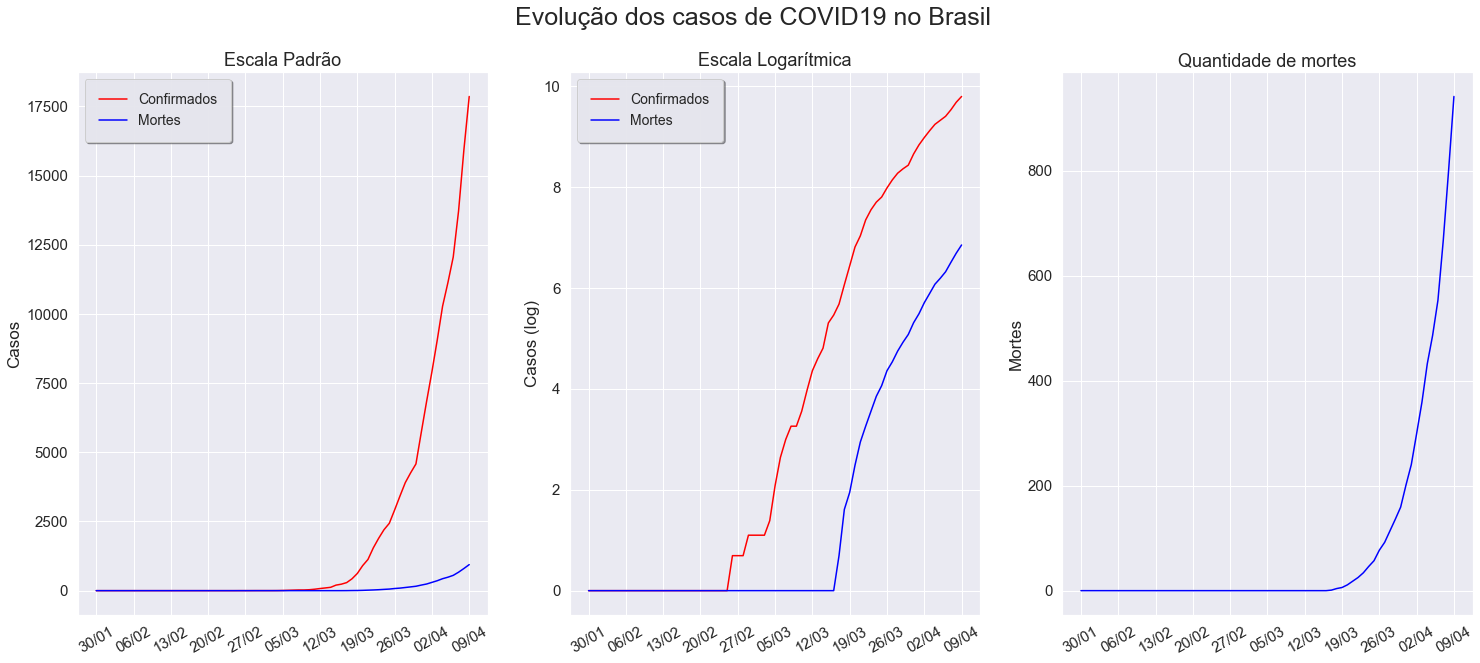

In [51]:
#Convertendo datas em formato específico para usar nos gráficos
#Usando list comprehesion para atribuir essas conversões a um dataframe
dateviewg1=[pd.to_datetime(g1.date)[x].strftime("%d/%m") for x in range(0,len(g1.date))]

f , ax = plt.subplots(nrows=1,ncols=3,figsize=(25,10))
f.suptitle("Evolução dos casos de COVID19 no Brasil",fontsize=25,y=0.97)

sns.set(style="darkgrid")

sns.lineplot(g1.date,(g1.cases),color="red",label="Confirmados",ax=ax[0])
sns.lineplot(g1.date,(g1.deaths),color="blue",label="Mortes",ax=ax[0])
ax[0].set_title("Escala Padrão",size=18)
ax[0].legend(ncol=1, loc="upper left", frameon=True,fontsize = 14,fancybox = True,framealpha = 0.95,shadow = True,borderpad = 1 )
ax[0].set_xlabel('',size=17)
ax[0].set_ylabel('Casos',size=17)
ax[0].tick_params(axis='x',labelsize=15,rotation=30)
ax[0].tick_params(axis='y',labelsize=15)
ax[0].set_xticks(g1.date[::-7])
ax[0].set_xticklabels(dateviewg1[::-7])

sns.lineplot(g1.date,np.log1p(g1.cases),color="red",label="Confirmados",ax=ax[1])
sns.lineplot(g1.date,np.log1p(g1.deaths),color="blue",label="Mortes",ax=ax[1])
ax[1].set_title("Escala Logarítmica",size=18)
ax[1].legend(ncol=1, loc="upper left", frameon=True,fontsize = 14,fancybox = True,framealpha = 0.95,shadow = True,borderpad = 1 )
ax[1].set_xlabel('',size=17)
ax[1].set_ylabel('Casos (log)',size=17)
ax[1].tick_params(axis='x',labelsize=15,rotation=30)
ax[1].tick_params(axis='y',labelsize=15)
ax[1].set_xticks(g1.date[::-7])
ax[1].set_xticklabels(dateviewg1[::-7])

sns.lineplot(g1.date,(g1.deaths),color="blue",ax=ax[2])
ax[2].set_title("Quantidade de mortes",size=18)
ax[2].set_xlabel('',size=17)
ax[2].set_ylabel('Mortes',size=17)
ax[2].tick_params(axis='x',labelsize=15,rotation=30)
ax[2].tick_params(axis='y',labelsize=15)
ax[2].set_xticks(g1.date[::-7])
ax[2].set_xticklabels(dateviewg1[::-7])

plt.show()

## A partir do dia 19 de março fica evidente no primeiro gráfico o crescimento exponencial dos casos confirmados no Brasil, e com mais 2 semanas após esse data, o número de infectados chega a 7500. E esse número aumenta mais que 2 vezes em um período de apenas uma semana, alcançando aproximadamente 17500 casos confirmados. No segundo gráfico podemos notar de uma forma mais detalhada a relação entre o número de casos confirmados e a quantidade de mortes, e assim fazer um paralelo com o último gráfico, onde o crescimento exponencial de óbitos ocorre após o dia 26 de março, chegando a mais de 800 mortes em menos de 2 semanas.

## 

## Há diferença na propagação do COVID19 entre as regiões Brasileiras ?

In [52]:
#Criando subset com as informações totais das regiões
reg=df.groupby(['Região','state'])['cases','deaths'].last().droplevel(level=1)
reg=reg.groupby('Região').sum()
reg.loc[-1]=reg.sum()
reg['Mortes por Casos (%)']=(reg.deaths/reg.cases)*100
reg=reg.rename(index={-1:'Total'},columns={'cases':'Casos Confirmados','deaths':'Casos de Mortes'})
# cmap Mapa de cores invertido / reverso 
reg.style.background_gradient(cmap="summer_r",vmin=reg.min().min(),vmax=reg.iloc[:-1,].max().max())

In [53]:
#Criando subsets com essas informações com o número de infectados e de mortes
#Pivot de Dados
reg_cases=pd.pivot_table(df,index=['date'],columns=['Região'],values=['cases'],aggfunc=np.sum)
reg_cases.columns=reg_cases.columns.get_level_values('Região')
reg_deaths=pd.pivot_table(df,index=['date'],columns=['Região'],values=['deaths'],aggfunc=np.sum)
reg_deaths.columns=reg_deaths.columns.get_level_values('Região')

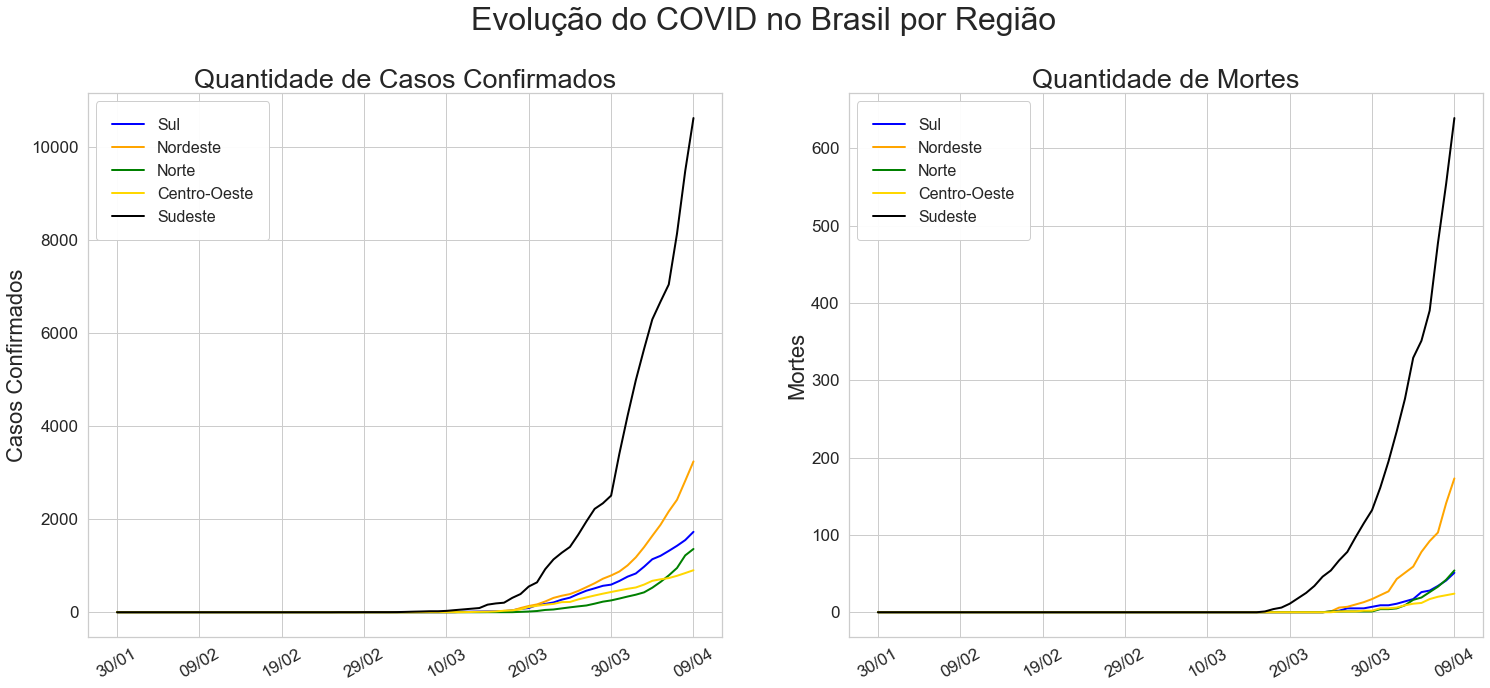

In [55]:
#Criando e personalizando visualizações
f , ax = plt.subplots(nrows=1,ncols=2,figsize=(25,10))
f.suptitle("Evolução do COVID no Brasil por Região",fontsize=32,y=1)
change_size_labels=22
change_size_titles=27
change_size_ticks=17
sns.set(style="whitegrid")

#Configurando formato de data para data personalizada para adicionar ao gráfico
dateview=[reg_cases.index.strftime('%d/%m')[x] for x in range(0,len(reg_cases.index))]

sns.lineplot(x=reg_cases.index,y='Sul',ax=ax[0],data=(reg_cases),linewidth=2,label="Sul",color="blue")
sns.lineplot(x=reg_cases.index,y='Nordeste',ax=ax[0],data=(reg_cases),linewidth=2,label="Nordeste",color="orange")
sns.lineplot(x=reg_cases.index,y='Norte',ax=ax[0],data=(reg_cases),linewidth=2,label="Norte",color="green")
sns.lineplot(x=reg_cases.index,y='Centro-Oeste',ax=ax[0],data=(reg_cases),linewidth=2,label="Centro-Oeste",color="gold")
sns.lineplot(x=reg_cases.index,y='Sudeste',ax=ax[0],data=(reg_cases),linewidth=2,label="Sudeste",color="black")
ax[0].set_title("Quantidade de Casos Confirmados",size=change_size_titles)
ax[0].set_xlabel('',size=change_size_labels)
ax[0].set_ylabel('Casos Confirmados',size=change_size_labels)
ax[0].tick_params(axis='x',labelsize=change_size_ticks,rotation=30)
ax[0].tick_params(axis='y',labelsize=change_size_ticks)
ax[0].legend(ncol=1, loc="upper left", frameon=True,fontsize = 16,fancybox = True,framealpha = 0.95,shadow = False,borderpad = 1 )
#Configurar o intervalo do eixo
ax[0].set_xticks(reg_cases.index[::-int(len(dateview)/7)])
ax[0].set_xticklabels(dateview[::-int(len(dateview)/7)])

sns.lineplot(x=reg_deaths.index,y='Sul',ax=ax[1],data=(reg_deaths),linewidth=2,label="Sul",color="blue")
sns.lineplot(x=reg_deaths.index,y='Nordeste',ax=ax[1],data=(reg_deaths),linewidth=2,label="Nordeste",color="orange")
sns.lineplot(x=reg_deaths.index,y='Norte',ax=ax[1],data=(reg_deaths),linewidth=2,label="Norte",color="green")
sns.lineplot(x=reg_deaths.index,y='Centro-Oeste',ax=ax[1],data=(reg_deaths),linewidth=2,label="Centro-Oeste",color="gold")
sns.lineplot(x=reg_deaths.index,y='Sudeste',ax=ax[1],data=(reg_deaths),linewidth=2,label="Sudeste",color="black")
ax[1].set_title("Quantidade de Mortes",size=change_size_titles)
ax[1].set_xlabel('',size=change_size_labels)
ax[1].set_ylabel('Mortes',size=change_size_labels)
ax[1].tick_params(axis='x',labelsize=change_size_ticks,rotation=30)
ax[1].tick_params(axis='y',labelsize=change_size_ticks)
ax[1].legend(ncol=1, loc="upper left", frameon=True,fontsize = 16,fancybox = True,framealpha = 0.95,shadow = False,borderpad = 1 )
#Configurar o intervalo do eixo
ax[1].set_xticks(reg_deaths.index[::-int(len(dateview)/7)])
ax[1].set_xticklabels(dateview[::-int(len(dateview)/7)])

plt.show()

## É evidente a elevada quantidade tanto de casos confirmados quanto de mortes na região Sudeste, apresentando mais que o dobro de ocorrências em relação a todas as outras regiões juntas. O crescimento desses casos também é de forma exponencial, sendo acentuado mais cedo que as demais regiões. Entretanto, o sudeste não é o único que já apresenta essa característica exponencial, devemos destacar também a região Nordestina que após o fim de março, teve aumentos consideráveis na propagação do vírus, se distanciando do grupo com menor volume de casos, formado pelas regiões Sul, Norte e Centro-Oeste.
## Deste modo, pensando na parte preditiva o modelo pode captar diferentes variações pra essas regiões. Logo, abordar as regiões brasileiras como variáveis categóricas binárias (dummies) na etapa de modelagem pode aumentar a acurácia preditiva.

## 

## Qual é a proporção do COVID19 em termos de ocupação geográfica da população ?
### Número de casos por km² por estado
### População e área total de municípios com pelo menos um caso de COVID19 pelas dimensões totais de cada estado

In [226]:
#Criando subset para análise
geo = df.groupby('state')[['cases','area_state','Densidade','Population_2019','infec_state_area','infec_state_population']].last().reset_index()
km2=1000
geo['infected_x_{}_km2'.format(km2)] = geo.cases/geo.area_state*km2
geo['habitant_x_{}_km2'.format(km2)] = geo.Population_2019/geo.area_state*km2
geo.tail()

state  cases  area_state  Densidade  Population_2019  \
22         Roraima     52  224273.831       2.70           605761   
23  Santa Catarina    501   95730.921      74.84          7164788   
24         Sergipe     39   21926.908     104.83          2298696   
25       São Paulo   7480  248219.481     184.99         45919049   
26       Tocantins     23  277720.404       5.66          1572866   

    infec_state_area  infec_state_population  infected_x_1000_km2  \
22          0.210460                0.735384             0.231859   
23          0.280885                0.709711             5.233419   
24          0.125584                0.395057             1.778637   
25          0.281406                0.821661            30.134621   
26          0.040590                0.374083             0.082817   

    habitant_x_1000_km2  
22          2700.988329  
23         74842.986207  
24        104834.480083  
25        184993.735443  
26          5663.487368

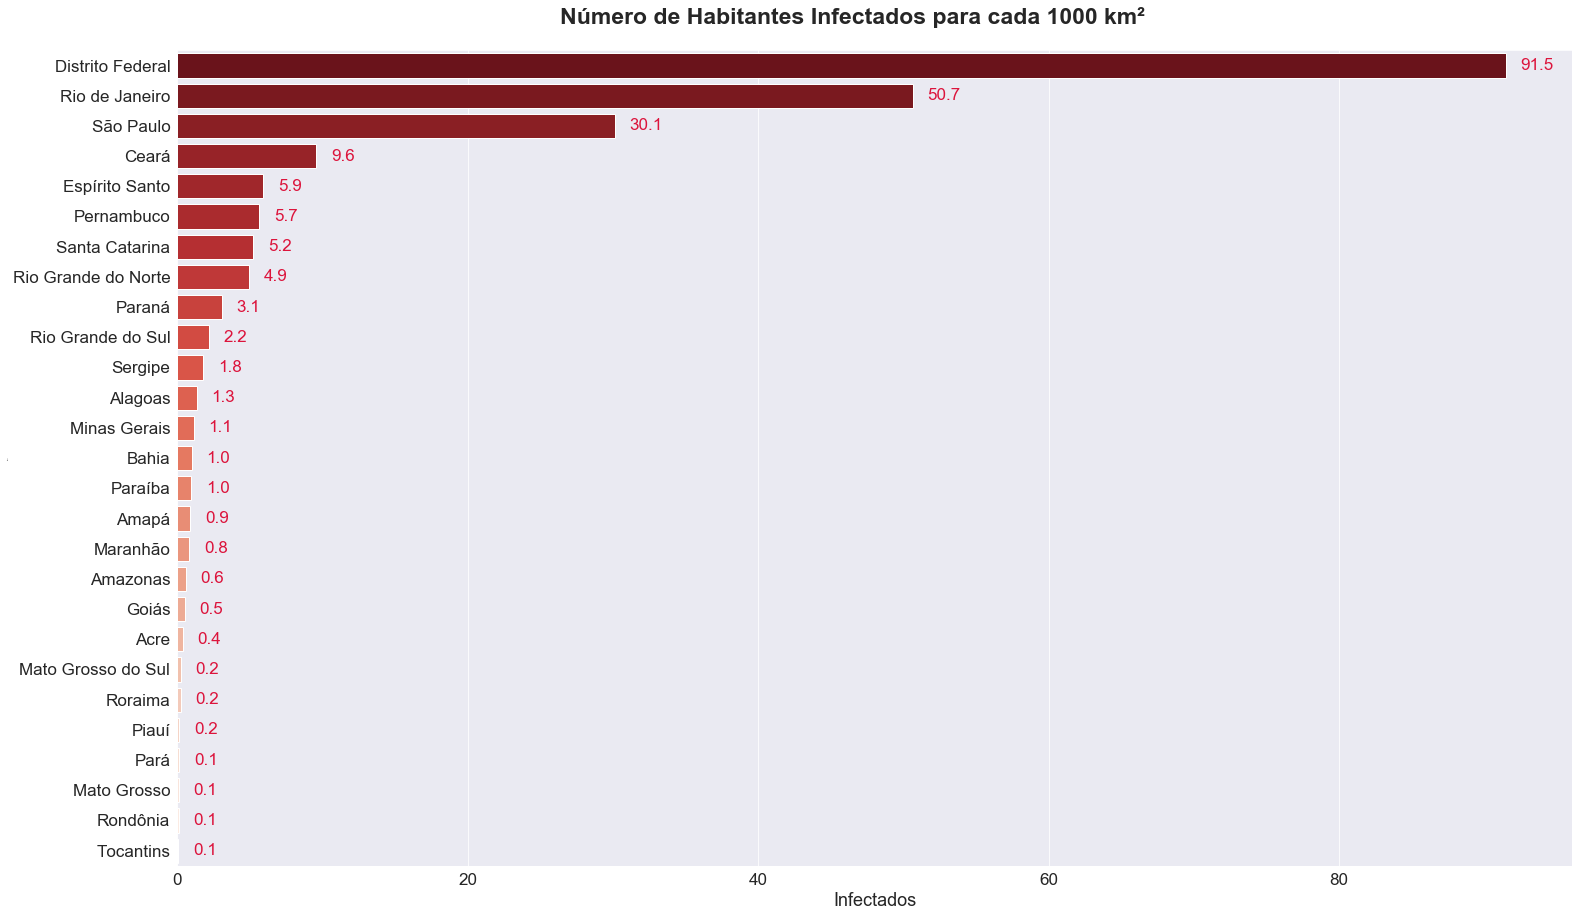

In [228]:
#Criando primeira visualização
geo_ord = geo.sort_values(by='infected_x_1000_km2',ascending=False)

fig , ax = plt.subplots(figsize = (25,15))
fig.suptitle('Número de Habitantes Infectados para cada 1000 km²',fontsize=23,weight='bold',y=0.92)
sns.set_style("darkgrid")

sns.barplot(y=geo_ord.state,x=geo_ord.infected_x_1000_km2,orient="h",palette="Reds_r")
ax.set_xlabel('Infectados',fontsize=18)
ax.set_ylabel('Estados',fontsize=0)
ax.tick_params(axis='x',labelsize=17)
ax.tick_params(axis='y',labelsize=17)

for i in range(1,28):
    ax.annotate('{:.1f}'.format(geo_ord.infected_x_1000_km2.tail(i).values[0]),(geo_ord.infected_x_1000_km2.tail(i).values[0]+1,27-i),size=17,color='crimson',va='center')

plt.show()

## Podemos perceber uma situação alarmante no Distrito Federal, mas devemos considerar também que sua área territorial é bem menor em comparação com os estados do país. Entretanto, o DF juntamente com o Rio de Janeiro e São Paulo lideram com grande folga o número de infectados para cada 1000 km², evidenciando a alta progragação do vírus nessas regiões.

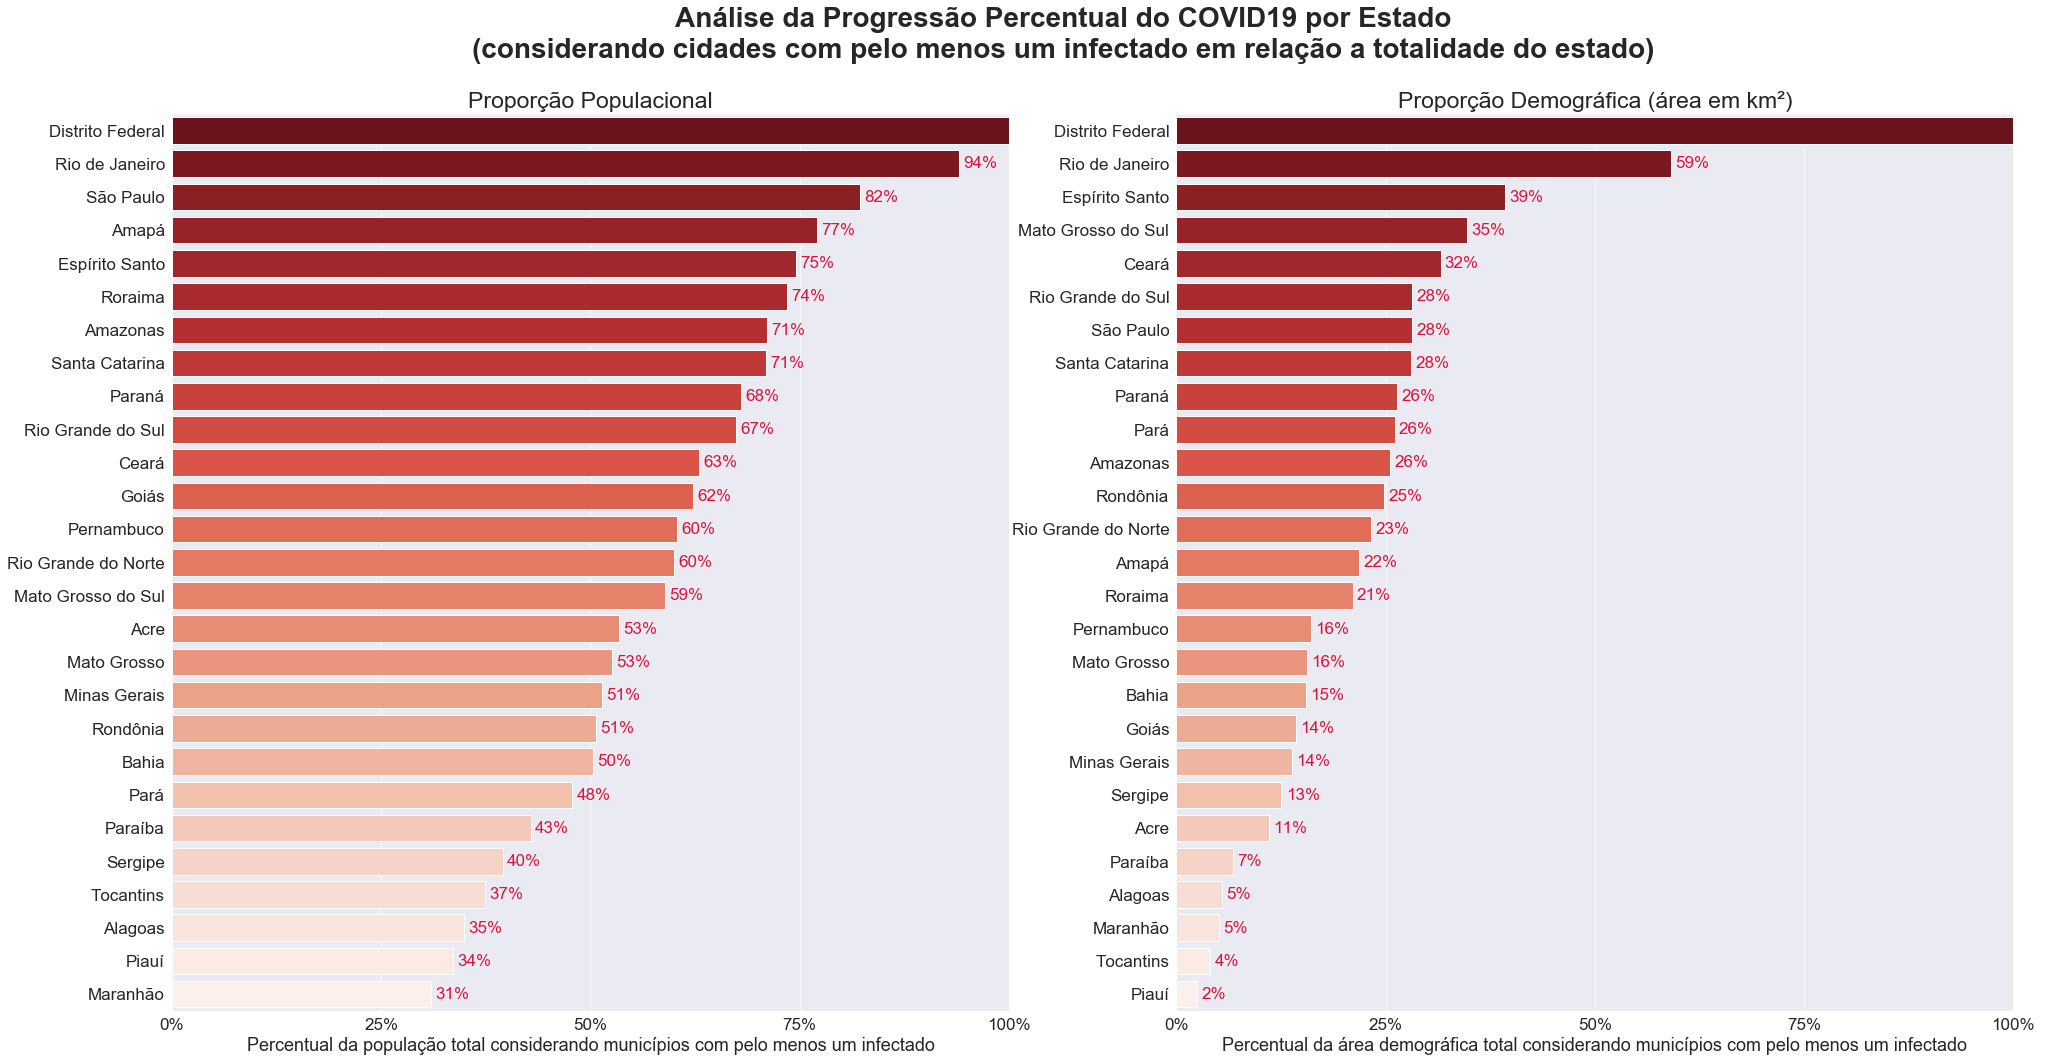

In [251]:
#Criando e personalizando segunda visualização
geo_ord = geo.sort_values(by='infec_state_population',ascending=False)

fig , ax = plt.subplots(ncols=2,nrows=1,figsize = (33,16.5))
fig.suptitle('Análise da Progressão Percentual do COVID19 por Estado\n(considerando cidades com pelo menos um infectado em relação a totalidade do estado)',
             fontsize=28,weight='bold',y=0.97)
sns.set_style("darkgrid")

sns.barplot(y=geo_ord.state,x=geo_ord.infec_state_population,orient="h",palette="Reds_r",ax=ax[0])
ax[0].set_title("Proporção Populacional",fontsize=23)
ax[0].set_xlabel('Percentual da população total considerando municípios com pelo menos um infectado',fontsize=18)
ax[0].set_ylabel('',fontsize=17)
ax[0].tick_params(axis='x',labelsize=17)
ax[0].tick_params(axis='y',labelsize=17)
ax[0].set_xticks([0.00,0.25,0.50,0.75,1.00])
ax[0].set_xticklabels(['0%','25%','50%','75%','100%'])
ax[0].set_xlim(0,1)

for i in range(1,28):
    ax[0].annotate('{:.0f}%'.format(geo_ord.infec_state_population.tail(i).values[0]*100),
                   (geo_ord.infec_state_population.tail(i).values[0]+0.005,27-i),size=17,color='crimson',va='center')

geo_ord = geo.sort_values(by='infec_state_area',ascending=False)
    
sns.barplot(y=geo_ord.state,x=geo_ord.infec_state_area,orient="h",palette="Reds_r",ax=ax[1])
ax[1].set_title("Proporção Demográfica (área em km²)",fontsize=23)
ax[1].set_xlabel('Percentual da área demográfica total considerando municípios com pelo menos um infectado',fontsize=18)
ax[1].set_ylabel('',fontsize=17)
ax[1].tick_params(axis='x',labelsize=17)
ax[1].tick_params(axis='y',labelsize=17)
ax[1].set_xticks([0.00,0.25,0.50,0.75,1.00])
ax[1].set_xticklabels(['0%','25%','50%','75%','100%'])
ax[1].set_xlim(0,1)

for i in range(1,28):
    ax[1].annotate('{:.0f}%'.format(geo_ord.infec_state_area.tail(i).values[0]*100),
                   (geo_ord.infec_state_area.tail(i).values[0]+0.005,27-i),size=17,color='crimson',va='center')

plt.show()

## Podemos perceber que mais da metade da população total da grande maioria dos estados já teve 'contato' com o COVID19. Com destaque para o Distrito Federal e os estados do Rio de Janeiro, São Paulo, Amapá e Espiríto Santo, lugares onde mais de 75% da população reside em cidades com pelo menos um caso confirmado de COVID19. No contexto territorial, temos o Distrito Federal e a região carioca com mais de 50% do seu território contendo cidades com no mínimo um infectado. Fazendo uma comparação entre as duas métricas, regiões como São Paulo, Amapá, Espiríto Santo e entre outras que possuem alto percentual populacional e baixo percentual territorial, mostram que apenas as suas grandes cidades que possuem alta densidade demográfica são as mais atingidas até o momento. Devemos destacar também os estados do Maranhão, Sergipe, Tocantins, Alagoas, Piauí e Paraíba com o status do COVID19 como 'controlado', onde possuem baixos percentuais populacionais (entre 30 e 44%) e territoriais (entre 2 e 7%).

## 

## Como é a evolução da proporção de casos confirmados na população brasileira ao longo do tempo ?

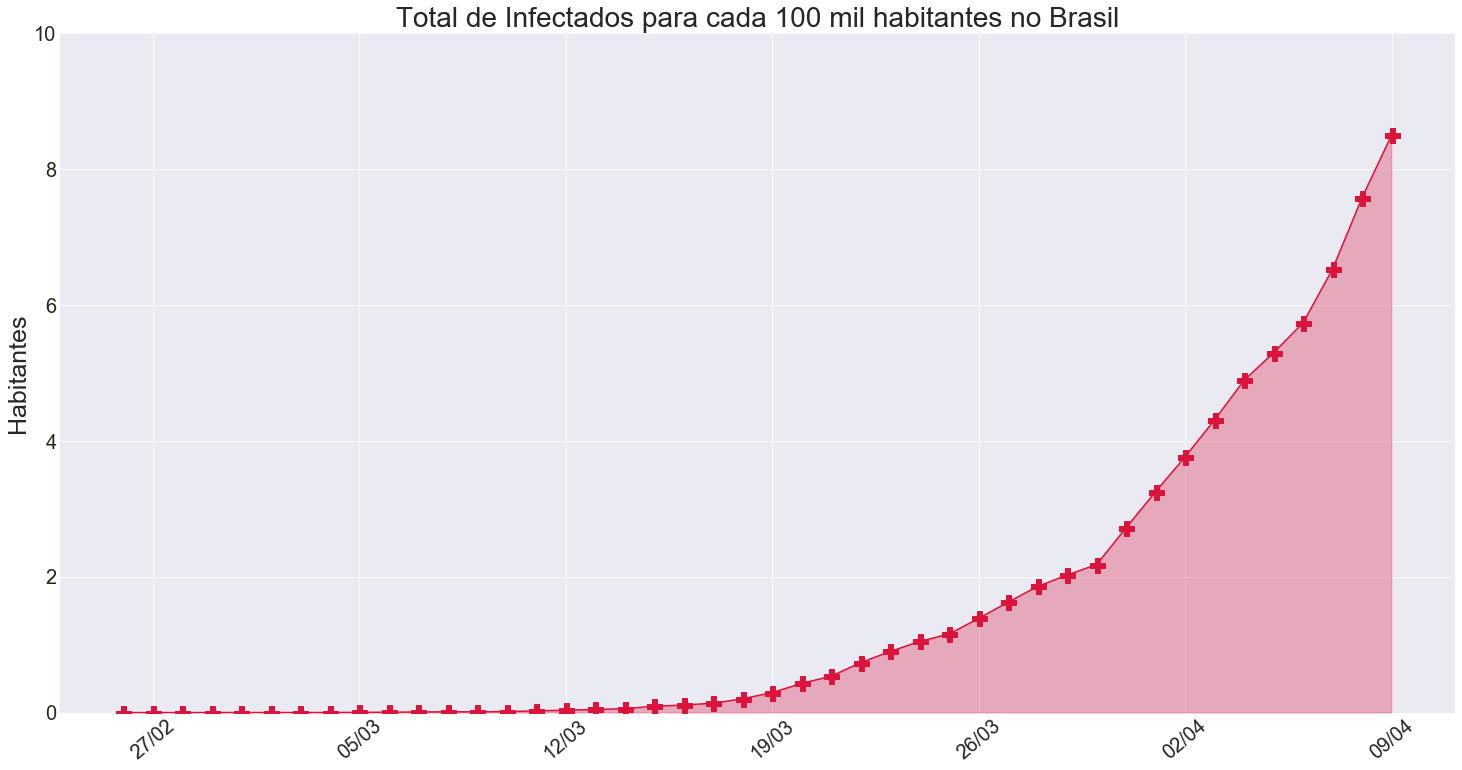

In [255]:
#Agrupando os dados e selecionando as colunas requeridas
g1= df.groupby('date').sum().reset_index()
g1=g1[['cases','date','deaths']]

#Convertendo datas em formato específico para usar nos gráficos
dateviewg1=[pd.to_datetime(g1.date)[x].strftime("%d/%m") for x in range(0,len(g1.date))]

#População total do Brasil
tot_pop=df.Population_2019.unique().sum()
grp_hab=10**5

fig , axes = plt.subplots(figsize=(25,12.5))

plt.style.use("seaborn-darkgrid")

#Selecionando a data inicial como a de primeiro caso confirmado em vez do primeiro caso suspeito
g1=g1[g1['date']>='2020-02-26']

axes.plot(g1.date, (g1.cases/tot_pop)*grp_hab, color="crimson", alpha=1,marker='P',markersize=15)
axes.fill_between( g1.date, (g1.cases/tot_pop)*grp_hab, color="crimson", alpha=0.3)
axes.set_ylim(0,10)
axes.set_xlabel('',size=25)
axes.set_ylabel('Habitantes',size=25)
axes.set_title('Total de Infectados para cada 100 mil habitantes no Brasil',size=28)
axes.tick_params(axis='x',labelsize=20,rotation=40)
axes.tick_params(axis='y',labelsize=20)
axes.set_xticks(g1.date[::-7])
axes.set_xticklabels(dateviewg1[::-7])
#axes.set_yticklabels(labels=list(range(0,2,0.25)))
axes.grid(True)

plt.show()

## Visualizando a tendência exponencial do número de infectados em relação ao tamanho da população brasileira, temos uma visão mais detalhada e compreensível. Logo, notamos que essa tendência tem início no dia 26/03, onde há aproximadamente 2 infectados para cada 100 mil habitantes, e esse número praticamente dobra a cada semana, atingindo mais de 8 casos confirmados para cada 100 mil habitantes no país.
## Implementar uma variável que capte esse aumento ao longo do tempo em cada estado pode ser interessante para a parte preditiva do modelo.

## 

## Como é a progressão do COVID19 no estado com maior número de casos ?

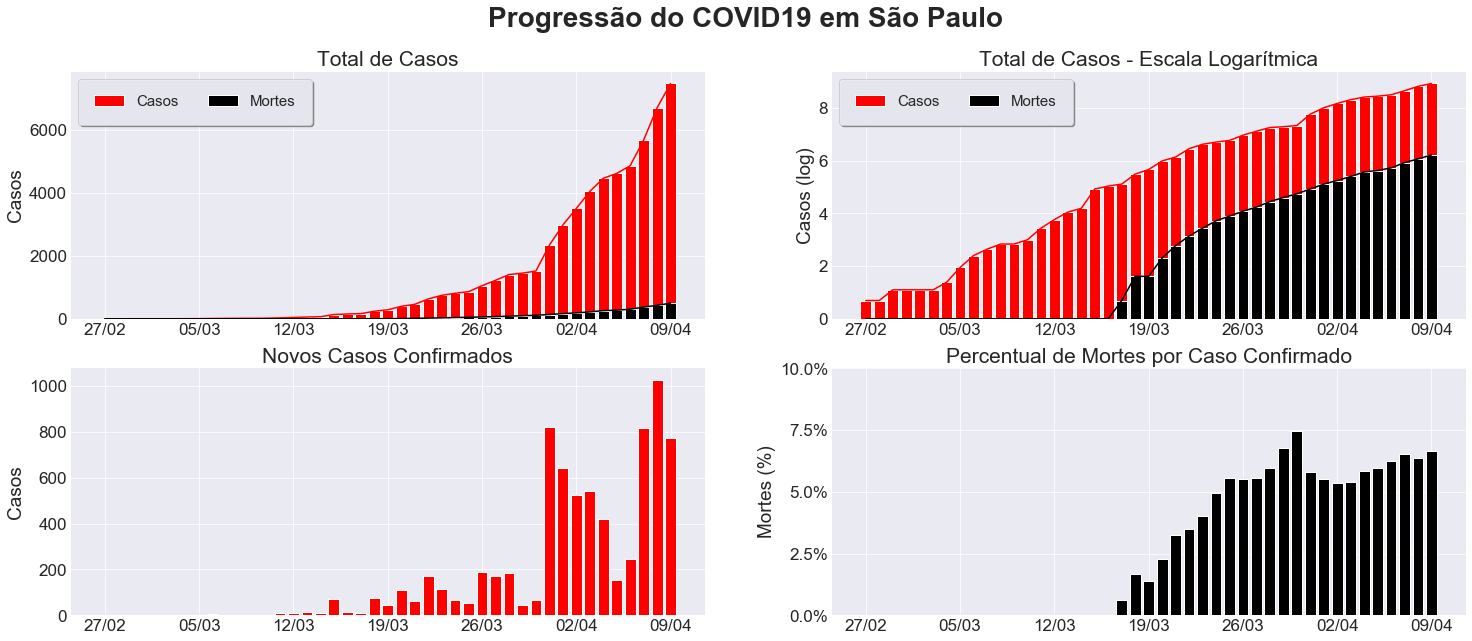

In [308]:
city='São Paulo'
g2=df[df['state']==city].reset_index(drop=True)
g2=g2[g2['date']>'2020-02-26'].reset_index(drop=True)

fig , ax = plt.subplots(nrows=2,ncols=2,figsize=(25,10))
dateview = [pd.to_datetime(g2.date)[x].strftime("%d/%m") for x in range(0,len(g2.date))]
tit=("Progressão do COVID19 em {}".format(city))
fig.suptitle(tit,y=0.97,fontsize=28,weight='bold')
sns.set_style("darkgrid")

titsize, labsize, ticksize = 21, 19, 17

ax[0,0].bar(g2.date,g2.cases,color="red",label="Casos")
ax[0,0].plot(g2.date,g2.cases,color="red")
ax[0,0].bar(g2.date,g2.deaths,color="black",label="Mortes")
ax[0,0].plot(g2.date,g2.deaths,color="black")
ax[0,0].set_title("Total de Casos".format(city),fontsize=titsize)
ax[0,0].set_xlabel('',size=labsize)
ax[0,0].set_ylabel('Casos',size=labsize)
ax[0,0].tick_params(axis='x',labelsize=ticksize)
ax[0,0].tick_params(axis='y',labelsize=ticksize)
ax[0,0].set_xticks(g2.date[::-7])
ax[0,0].set_xticklabels(dateview[::-7])
ax[0,0].legend(ncol=2, loc="upper left", frameon=True,fontsize = 15,fancybox = True,framealpha = 0.95,shadow = True,borderpad = 1.05 )

ax[0,1].bar(g2.date,np.log1p(g2.cases),color="red",label="Casos")
ax[0,1].plot(g2.date,np.log1p(g2.cases),color="red")
ax[0,1].bar(g2.date,np.log1p(g2.deaths),color="black",label="Mortes")
ax[0,1].plot(g2.date,np.log1p(g2.deaths),color="black")
ax[0,1].set_title("Total de Casos - Escala Logarítmica".format(city),fontsize=titsize)
ax[0,1].set_xlabel('',size=labsize)
ax[0,1].set_ylabel('Casos (log)',size=labsize)
ax[0,1].tick_params(axis='x',labelsize=ticksize)
ax[0,1].tick_params(axis='y',labelsize=ticksize)
ax[0,1].set_xticks(g2.date[::-7])
ax[0,1].set_xticklabels(dateview[::-7])
ax[0,1].legend(ncol=2, loc="upper left", frameon=True,fontsize = 15,fancybox = True,framealpha = 0.95,shadow = True,borderpad = 1.05 )


ax[1,0].bar(g2.date,g2.new_cases,color="red")
ax[1,0].set_title("Novos Casos Confirmados".format(city),fontsize=titsize)
ax[1,0].set_xlabel('',size=labsize)
ax[1,0].set_ylabel('Casos',size=labsize)
ax[1,0].tick_params(axis='x',labelsize=ticksize)
ax[1,0].tick_params(axis='y',labelsize=ticksize)
ax[1,0].set_xticks(g2.date[::-7])
ax[1,0].set_xticklabels(dateview[::-7])

ax[1,1].bar(g2.date,(g2.deaths/g2.cases)*100,color="black")
ax[1,1].set_title("Percentual de Mortes por Caso Confirmado".format(city),fontsize=titsize)
ax[1,1].set_xlabel('',size=labsize)
ax[1,1].set_ylabel('Mortes (%)',size=labsize)
ax[1,1].tick_params(axis='x',labelsize=ticksize)
ax[1,1].tick_params(axis='y',labelsize=ticksize)
ax[1,1].set_xticks(g2.date[::-7])
ax[1,1].set_xticklabels(dateview[::-7])
ax[1,1].set_ylim(0,10)
ax[1,1].set_yticks([0.0,2.5,5.0,7.5,10.0])
ax[1,1].set_yticklabels(labels=['0.0%','2.5%','5.0%','7.5%','10.0%'])

plt.show()

## Podemos perceber a acentuação do crescimento exponencial de infectados a partir do dia 26 de março em São Paulo, onde em uma semana a quantidade total de casos confirmados quase triplica. A taxa de mortes por infectados começa a aumentar no dia 19/03 chegando a 5% no dia 26, após esse dia essa taxa se mantém constante entre 5 e 7,5%.

## 

## Há correlação entre o volume da propagação do COVID e as características populacionais de cada estado ?

In [309]:
#Selecionando o valor máximo de colunas específicas por estado
st=df.groupby('state')['cases','deaths','Population_2019','Densidade'].max()
st.columns=['Confirmados','Mortes','População','Densidade Demográfica']
st.style.background_gradient()

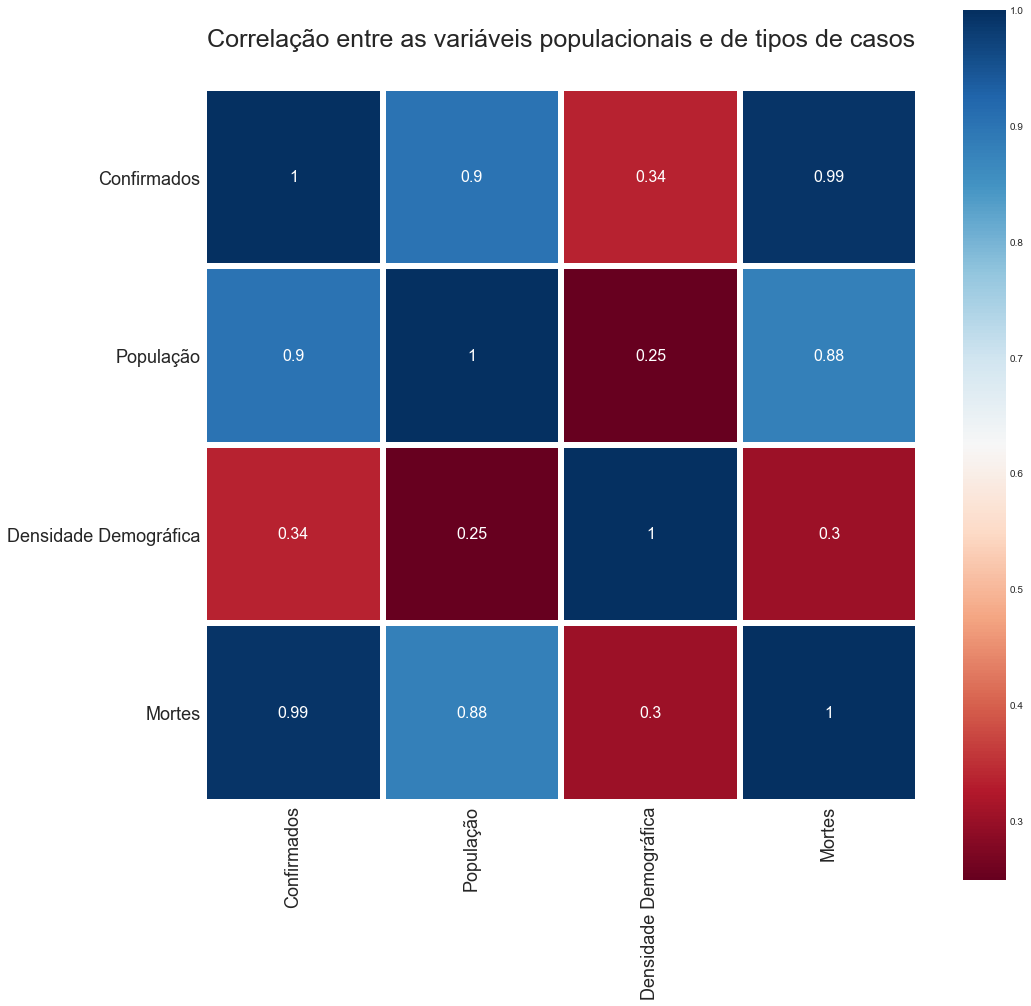

In [310]:
colormap = plt.cm.RdBu
plt.figure(figsize=(16,16))
plt.title('Correlação entre as variáveis populacionais e de tipos de casos', y=1.05, fontsize=25)
sns.heatmap(st.loc[:,['Confirmados','População','Densidade Demográfica','Mortes']].corr(),linewidths=5, square=True, cmap=colormap, linecolor='white', annot=True,annot_kws={'fontsize':16})
plt.tick_params(axis='x',labelsize=18,rotation=90)
plt.tick_params(axis='y',labelsize=18,rotation=0)

plt.show()

## Pode-se inferir que há uma alta correlação entre o número de infectados e mortos com o tamanho da população por estado. Logo, essas variáveis e derivações do relacionamento entre elas podem ajudar a identificar características específicas na modelagem, podendo aumentar a eficiência preditiva.

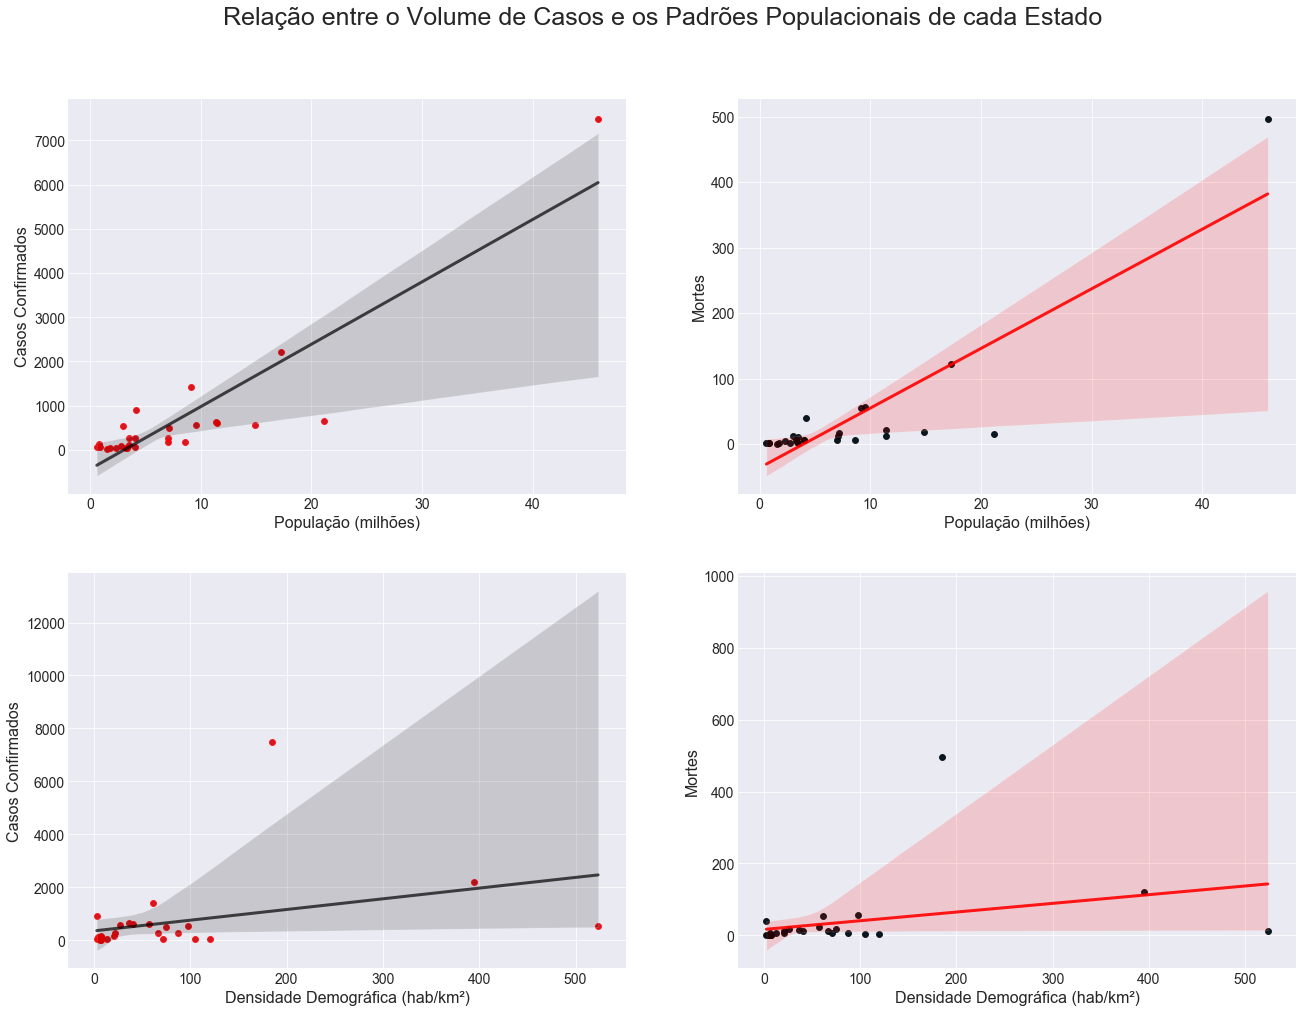

In [311]:
fig , ax = plt.subplots(2,2,figsize=(22,16))

tit="Relação entre o Volume de Casos e os Padrões Populacionais de cada Estado"
fig.suptitle(tit, fontsize=25,y=0.96)

sns.set_style("darkgrid")

sns.scatterplot(y=st.Confirmados,x=st.População,ax=ax[0,0])
sns.regplot(y=st.Confirmados,x=st.População, line_kws={"color":"black","alpha":0.7,"lw":3},ax=ax[0,0],color="red")
ax[0,0].set_xlabel('População (milhões)',size=16)
ax[0,0].set_ylabel('Casos Confirmados',size=16)
ax[0,0].tick_params(axis='x',labelsize=14)
ax[0,0].tick_params(axis='y',labelsize=14)
#ax[0,0].set_ylim(-50,800)
ax[0,0].set_xticklabels(['','0','10','20','30','40'])

sns.scatterplot(y=st.Mortes,x=st.População,ax=ax[0,1])
sns.regplot(y=st.Mortes,x=st.População, line_kws={"color":"red","alpha":0.9,"lw":3},ax=ax[0,1],color="black")
ax[0,1].set_xlabel('População (milhões)',size=16)
ax[0,1].set_ylabel('Mortes',size=16)
ax[0,1].tick_params(axis='x',labelsize=14)
ax[0,1].tick_params(axis='y',labelsize=14)
ax[0,1].set_xticklabels(['','0','10','20','30','40'])

sns.scatterplot(y=st.Confirmados,x=st['Densidade Demográfica'],ax=ax[1,0])
sns.regplot(y=st.Confirmados,x=st['Densidade Demográfica'], line_kws={"color":"black","alpha":0.7,"lw":3},ax=ax[1,0],color="red")
ax[1,0].set_xlabel('Densidade Demográfica (hab/km²)',size=16)
ax[1,0].set_ylabel('Casos Confirmados',size=16)
ax[1,0].tick_params(axis='x',labelsize=14)
ax[1,0].tick_params(axis='y',labelsize=14)

sns.scatterplot(y=st.Mortes,x=st['Densidade Demográfica'],ax=ax[1,1])
sns.regplot(y=st.Mortes,x=st['Densidade Demográfica'], line_kws={"color":"red","alpha":0.9,"lw":3},ax=ax[1,1],color="black")
ax[1,1].set_xlabel('Densidade Demográfica (hab/km²)',size=16)
ax[1,1].set_ylabel('Mortes',size=16)
ax[1,1].tick_params(axis='x',labelsize=14)
ax[1,1].tick_params(axis='y',labelsize=14)

plt.show()

## Assim sendo, temos outra confirmação, dessa vez de forma visual, entre o número de casos e o tamanho da população dos estados. Entretando, podemos perceber também alguns pontos em destaque que fogem do padrão, principalmente nos relacionamentos envolvidos com a densidade demográfica, onde há estados que possuem poucos habitantes por km² e grandes númerosde cassos, além de estados com alta densidade demográfica e sem aumento significativo no número de casos. Por outro lado, podemos investigar melhor essa relação, aprofundando na análise da densidade demográfica, sem considerar apenas o a área ocupada no território completo e sim nos grandes centros urbanos de cada estado.
## Desta forma, com essas duas análises, retiramos alguns insigths interessantes para trabalhar. Criar variáveis para captar os relacionamentos significativos é um desses insigths.

# 

# Feature Engineering
## Com objetivo de criar novas variáveis que possam ajudar na predição de novos casos ou suspeitas

In [64]:
#Copiando dataframe original
date_state=df.copy()

## Adição de variáveis que captem padrões dos períodos próximos
### Como o total, a diferença e a taxa de casos de dias anteriores

In [65]:
#Criando Variáveis

#Relacionadas ao dia anterior (d-1)
#Número de Casos Confirmados por Estado
date_state['Cases_Last_Day']=date_state.groupby(['state']).cases.shift()
#Diferença de Casos Confirmados em relação ao dia anterior a esse
date_state['Diff_Cases_Last_Day']=date_state.groupby(['state']).Cases_Last_Day.diff()

#Relacionadas ao antepenúltimo dia d-2
#Número de Casos Confirmados por Estado
date_state['Cases_Last_Day_1']=date_state.groupby(['state']).cases.shift(2)
#Diferença de Casos Confirmados em relação ao dia anterior a esse
date_state['Diff_Cases_Last_Day_1']=date_state.groupby(['state']).Cases_Last_Day_1.diff()

#Relacionadas ao dia d-3
#Número de Casos Confirmados por Estado
date_state['Cases_Last_Day_2']=date_state.groupby(['state']).cases.shift(3)
#Diferença de Casos Confirmados em relação ao dia d-3
date_state['Diff_Cases_Last_Day_2']=date_state.groupby(['state']).Cases_Last_Day_2.diff()

#Taxa de Casos Confirmados e de Mortes pelo tamanho da População e pela Densidade Demográfica do dia anterior
date_state['Cases_por_Population_Last_Day']=date_state['Cases_Last_Day']/date_state['Population_2019']
date_state['Cases_por_Densidade_Last_Day']=date_state['Cases_Last_Day']/date_state['Densidade']

date_state

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  cases_font2  new_cases_font2  \
0     164123.738  Norte  AC  ...          0.0              0.0   
1     164123.738  Norte  AC  ...          0.0              0.0   
2     164123.738  Norte  AC  ...          0.0              0.0   
3     164123.738  Norte  AC  ...          0.0              0.0   
4     164123.738  Norte  AC  ...          0.0              0.0   
...          ...    ...  ..  ...          ...              ...   
1912  277720.404  Norte  TO  ...         17.0              1.0   
1913  277720.404  Norte  TO  ...         19.0              2.0   
1914  277720.404  Norte  TO  ...         19.0              0.0   
1915  277720.404  Norte  TO  ...         23.0              4.0   
1916  277720.404  Norte  TO  ...         23.0              0.0   

      Cases_Last_Day  Diff_Cases_Last_Day  Cases_Last_Day_1  \
0                NaN                  NaN               NaN   
1                0.0                  NaN               NaN   
2                0.0                  0.0               0.0   
3                0.0                  0.0               0.0   
4                0.0                  0.0               0.0   
...              ...                  ...               ...   
1912            14.0                  2.0              12.0   
1913            17.0                  3.0              14.0   
1914            17.0                  0.0              17.0   
1915            19.0                  2.0              17.0   
1916            23.0                  4.0              19.0   

      Diff_Cases_Last_Day_1  Cases_Last_Day_2  Diff_Cases_Last_Day_2  \
0                       NaN               NaN                    NaN   
1                       NaN               NaN                    NaN   
2                       NaN               NaN                    NaN   
3                       0.0               0.0                    NaN   
4                       0.0               0.0                    0.0   
...                     ...               ...                    ...   
1912                    0.0              12.0                    0.0   
1913                    2.0              12.0                    0.0   
1914                    3.0              14.0                    2.0   
1915                    0.0              17.0                    3.0   
1916                    2.0              17.0                    0.0   

      Cases_por_Population_Last_Day  Cases_por_Densidade_Last_Day  
0                               NaN                           NaN  
1                          0.000000                      0.000000  
2                          0.000000                      0.000000  
3                          0.000000                      0.000000  
4                          0.000000                      0.000000  
...                             ...                           ...  
1912                       0.000009                      2.473498  
1913                       0.000011                      3.003534  
1914                       0.000011            

## Variáveis que captam as medidas de posição e dispersão de cada estado, dado um período de tempo
### Média, máximo e desvio Padrão da soma de casos confirmados e do número de novos casos confirmados

In [66]:
#Soma de casos confirmados
#Defininda a lista de variáveis a serem coletadas:
features=['Cases_Last_Day']
#Definindo os períodos de tempo para serem coletados:
period=[3,7]

for i in list(range(0,len(features))):
    
    for j in list(range(0,len(period))):
        
        #Média
        date_state['Mean_{}s_{}'.format(features[i],period[j])]=date_state.groupby(['state'])[features[i]].rolling(period[j]).mean().values
        #Desvio Padrão
        date_state['Desvio_{}s_{}'.format(features[i],period[j])]=date_state.groupby(['state'])[features[i]].rolling(period[j]).std().values

#Novos casos confirmados = Diferença de casos para o dia anterior
#Defininda a lista de variáveis a serem coletadas:
features=['Diff_Cases_Last_Day']
#Definindo os períodos de tempo para serem coletados:
period=[3,7]

for i in list(range(0,len(features))):
    
    for j in list(range(0,len(period))):
        
        #Média
        date_state['Mean_{}s_{}'.format(features[i],period[j])]=date_state.groupby(['state'])[features[i]].rolling(period[j]).mean().values
        #Máximo
        date_state['Max_{}s_{}'.format(features[i],period[j])]=date_state.groupby(['state'])[features[i]].rolling(period[j]).max().values
        #Desvio Padrão
        date_state['Desvio_{}s_{}'.format(features[i],period[j])]=date_state.groupby(['state'])[features[i]].rolling(period[j]).std().values
      
date_state.tail()

date      state  cases  deaths   Latitude  Longitude  Densidade  \
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  Mean_Cases_Last_Days_3  \
1912  277720.404  Norte  TO  ...               12.666667   
1913  277720.404  Norte  TO  ...               14.333333   
1914  277720.404  Norte  TO  ...               16.000000   
1915  277720.404  Norte  TO  ...               17.666667   
1916  277720.404  Norte  TO  ...               19.666667   

      Desvio_Cases_Last_Days_3  Mean_Cases_Last_Days_7  \
1912                  1.154701               11.428571   
1913                  2.516611               12.571429   
1914                  1.732051               13.571429   
1915                  1.154701               14.714286   
1916                  3.055050               16.285714   

      Desvio_Cases_Last_Days_7  Mean_Diff_Cases_Last_Days_3  \
1912                  1.618347                     0.666667   
1913                  2.299068                     1.666667   
1914                  2.507133                     1.666667   
1915                  2.927700                     1.666667   
1916                  3.988077                     2.000000   

      Max_Diff_Cases_Last_Days_3  Desvio_Diff_Cases_Last_Days_3  \
1912                         2.0                       1.154701   
1913                         3.0                       1.527525   
1914                         3.0                       1.527525   
1915                         3.0                       1.527525   
1916                         4.0                       2.000000   

      Mean_Diff_Cases_Last_Days_7  Max_Diff_Cases_Last_Days_7  \
1912                     0.714286                         2.0   
1913                     1.142857                         3.0   
1914                     1.000000                         3.0   
1915                     1.142857                         3.0   
1916                     1.571429                         4.0   

      Desvio_Diff_Cases_Last_Days_7  
1912                       0.755929  
1913                       1.069045  
1914                       1.154701  
1915                       1.214986  
1916                       1.618347  

[5 rows x 52 columns]

## One Hot
### Criando variáveis categóricas para que o modelo possa entender as possíveis diferenças da progressão de casos por estado e região

In [67]:
#Criando novas colunas para transformação
date_state['UF_CAT']=date_state.UF
date_state['REG_CAT']=date_state.Região

#Transformando as variáveis
ohe_uf = OneHotEncoder(cols=['UF_CAT','REG_CAT'],use_cat_names=True,drop_invariant=True)
date_state = ohe_uf.fit_transform(date_state)
date_state.head()

date state  cases  deaths  Latitude  Longitude  Densidade  area_state  \
0 2020-01-30  Acre      0       0 -9.047868 -70.526498       5.37  164123.738   
1 2020-01-31  Acre      0       0 -9.047868 -70.526498       5.37  164123.738   
2 2020-02-01  Acre      0       0 -9.047868 -70.526498       5.37  164123.738   
3 2020-02-02  Acre      0       0 -9.047868 -70.526498       5.37  164123.738   
4 2020-02-03  Acre      0       0 -9.047868 -70.526498       5.37  164123.738   

  Região  UF  ...  UF_CAT_RR  UF_CAT_SC  UF_CAT_SE  UF_CAT_SP  UF_CAT_TO  \
0  Norte  AC  ...          0          0          0          0          0   
1  Norte  AC  ...          0          0          0          0          0   
2  Norte  AC  ...          0          0          0          0          0   
3  Norte  AC  ...          0          0          0          0          0   
4  Norte  AC  ...          0          0          0          0          0   

   REG_CAT_Norte  REG_CAT_Nordeste  REG_CAT_Centro-Oeste  REG_CAT_Sudeste  \
0              1                 0                     0                0   
1              1                 0                     0                0   
2              1                 0                     0                0   
3              1                 0                     0                0   
4              1                 0                     0                0   

   REG_CAT_Sul  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 84 columns]

## Variáveis que captem padrões de geolocalização
### Com finalidade de identificar possíveis relacionamentos entre o número de casos e a proximidade com os estados mais infectados

In [68]:
#Visualizando os estados com maior número de casos
date_state.groupby('state')['UF','cases'].last().sort_values(by='cases',ascending=False).head(10).style.background_gradient(cmap='summer_r',vmin=0,vmax=5000)

## Calculando a distância dos estados com relação aos 3 estados com maior número de casos

In [69]:
#Selecionando a Latitude e Longitude dos estados desejados

ufs=['RJ','CE','SP']

for uf in range(0,len(ufs)):

    sploc=(date_state[date_state['UF']==ufs[uf]]['Latitude'].max(),date_state[date_state['UF']==ufs[uf]]['Longitude'].max())

    #Criando dataframe com a latitude e longitude de cada estado
    state_loc=date_state.groupby('state')[['Latitude','Longitude','cases']].last()

    #Criando lista que armazenará a distância de cada estado para os estados com maior número de casos
    state_dist=[]

    for i in range(0,state_loc.shape[0]):
        #Definindo localização do estado
        loc=(state_loc.iloc[i,0],state_loc.iloc[i,1])

        #Calculando a distância em km para o estado de SP e adicionando na lista
        state_dist.append(geopy.distance.distance(loc, sploc).km)

    #Adicionando o resultado ao dataframe
    state_loc['DIST_{}'.format(ufs[uf])]=state_dist

    #Incrementando essa variável ao dataframe principal
    date_state=date_state.merge(state_loc['DIST_{}'.format(ufs[uf])],how='left',on='state')

date_state

date      state  cases  deaths   Latitude  Longitude  Densidade  \
0    2020-01-30       Acre      0       0  -9.047868 -70.526498       5.37   
1    2020-01-31       Acre      0       0  -9.047868 -70.526498       5.37   
2    2020-02-01       Acre      0       0  -9.047868 -70.526498       5.37   
3    2020-02-02       Acre      0       0  -9.047868 -70.526498       5.37   
4    2020-02-03       Acre      0       0  -9.047868 -70.526498       5.37   
...         ...        ...    ...     ...        ...        ...        ...   
1912 2020-04-05  Tocantins     17       0 -10.885513 -48.371691       5.66   
1913 2020-04-06  Tocantins     17       0 -10.885513 -48.371691       5.66   
1914 2020-04-07  Tocantins     19       0 -10.885513 -48.371691       5.66   
1915 2020-04-08  Tocantins     23       0 -10.885513 -48.371691       5.66   
1916 2020-04-09  Tocantins     23       0 -10.885513 -48.371691       5.66   

      area_state Região  UF  ...  UF_CAT_SP  UF_CAT_TO  REG_CAT_Norte  \
0     164123.738  Norte  AC  ...          0          0              1   
1     164123.738  Norte  AC  ...          0          0              1   
2     164123.738  Norte  AC  ...          0          0              1   
3     164123.738  Norte  AC  ...          0          0              1   
4     164123.738  Norte  AC  ...          0          0              1   
...          ...    ...  ..  ...        ...        ...            ...   
1912  277720.404  Norte  TO  ...          0          1              1   
1913  277720.404  Norte  TO  ...          0          1              1   
1914  277720.404  Norte  TO  ...          0          1              1   
1915  277720.404  Norte  TO  ...          0          1              1   
1916  277720.404  Norte  TO  ...          0          1              1   

      REG_CAT_Nordeste  REG_CAT_Centro-Oeste  REG_CAT_Sudeste  REG_CAT_Sul  \
0                    0                     0                0            0   
1                    0                     0                0            0   
2                    0                     0                0            0   
3                    0                     0                0            0   
4                    0                     0                0            0   
...                ...                   ...              ...          ...   
1912                 0                     0                0            0   
1913                 0                     0                0            0   
1914                 0                     0                0            0   
1915                 0                     0                0            0   
1916                 0                     0                0            0   

          DIST_RJ      DIST_CE      DIST_SP  
0     3292.368387  3426.599583  3007.513501  
1     3292.368387  3426.599583  3007.513501  
2     3292.368387  3426.599583  3007.513501  
3     3292.368387  3426.599583  3007.513501  
4     3292.368387  3426.599583  3007.513501  
...           ...          ...          ...  
1912  1439.556063  1134.626121  1413.796601  
1913  1439.556063  1134.626121  1413.796601  
1914  1439.556063  1134.626121  1413.796601  
1915  1439.556063  1134.626121  1413.796601  
1916  1439.556063  1134.626121  1413.796601  

[1917 rows x 87 columns]

# 

# Missing Data

In [71]:
print("Verificando a quantidade de dados nulos: {}".format(date_state.isna().sum().sum()))
print("Verificando a quantidade de dados inconsistentes: {}".format(date_state.isin([float("inf")]).sum().sum()))

#Substituindo dados inconsistentes por nulos
date_state.replace([np.inf, -np.inf], np.nan, inplace=True)

Verificando a quantidade de dados nulos: 1971
Verificando a quantidade de dados inconsistentes: 1149


In [72]:
#Proporção de dados iguais a zero no dataset
date_state.isin([0]).sum().sum()/date_state.count().sum()

0.6190493648378641

In [73]:
#Shape do dataset
date_state.shape

(1917, 87)

# 

# Save and Load Data

In [74]:
#Salvando os dados
date_state.to_csv('date_state_covidbr.csv',sep=';',index=False)

In [2]:
#Carregando os dados
date_state=pd.read_csv('date_state_covidbr.csv',sep=';')
#Convertendo date de string para datetime
date_state.date = pd.to_datetime(date_state.date)
date_state.head(1)

date state  cases  deaths  Latitude  Longitude  Densidade  area_state  \
0 2020-01-30  Acre      0       0 -9.047868 -70.526498       5.37  164123.738   

  Região  UF  ...  UF_CAT_SP  UF_CAT_TO  REG_CAT_Norte  REG_CAT_Nordeste  \
0  Norte  AC  ...          0          0              1                 0   

   REG_CAT_Centro-Oeste  REG_CAT_Sudeste  REG_CAT_Sul      DIST_RJ  \
0                     0                0            0  3292.368387   

       DIST_CE      DIST_SP  
0  3426.599583  3007.513501  

[1 rows x 87 columns]

In [3]:
#Verificando o shape do dataset
date_state.shape

(1917, 87)

# 

# Adjust Missing Data
## Antes de iniciar a etapa de modelagem, decidir o procedimento adequado para tratar os valores faltantes

In [4]:
#Verificando o total e a proporção de observações nulas no dataset
print(date_state.isnull().sum().sum())
print(date_state.isnull().sum().sum()/date_state.count().sum())

3120
0.0190640294759225


## A grande maioria dos dados faltantes são resultantes das tranformações feitas ao longo da manipulação do dataset. Logo, a melhor opção é substituir os valores por zero.

In [5]:
#Substituindo dados nulos por 0
date_state=date_state.fillna(0)
#Verificando a nova proporção de dados iguais a zero no dataset
date_state.isin([0]).sum().sum()/date_state.count().sum()

0.6261759574047092

# 

# Modelagem
## Data Validation

## Vou fazer a validação de 40% dos dados, os últimos 28 dias (13/03 - 09/04). A validação da time serie será do tipo expanding, onde os modelos serão treinados com x dias e validados com y dias, posteriormente treinaremos com x+1 dias e treinaremos com y-1 dias, sendo repetido até chegar ao último dia do dataset. Assim sendo, para cada treino feito calcularemos a métrica escolhida e ao final computaremos a média e a distribuição da métrica ao longo dos dias, com finalidade de ter uma ideia melhor de como o algoritmo está se saindo.

In [7]:
#Divisão dos dados
#Dias de início e fim, respecivamente
mn, mx = 43 , 71

#Visualizando a proporção inicial de treino e validação
date_state[date_state['Day']<43].shape
date_state[date_state['Day']>=43].shape[0]
print("Dados de Validação: {:.2f}%".format(date_state[date_state['Day']>=43].shape[0]/(date_state.shape[0])*100))

Dados de Validação: 40.85%


# Baseline e Métricas

## Métricas
## A métrica de avaliação principal será o RMSLE (Root Mean Squared Logarithmic Error) para escolher quais features e modelos são mais adequados para a previsão do número de casos. Entretanto, utilizaremos o MAPE (Mean Absolute Percentual Error) como suporte para obter uma interpretação percentual mais "entendível" da performance do modelo.

In [2]:
#Criando métricas utilizando funções

#Mean Absolute Percentual Error
def MAPE(pred,target):
    p=[]
    t=[]
    
    for i in range(0,len(target)):
        if target[i] != 0:
            p.append(pred[i])
            t.append(target[i])

    p=np.array(p)
    t=np.array(t)
    return np.mean(abs(1-p/t))

#Mean Absolute Percentual Error especificado por estado
def MAPE_STATE(pred,target,state):
    p=[]
    t=[]
    s=[]
    
    for i in range(0,len(target)):
        if target[i] != 0:
            p.append(pred[i])
            t.append(target[i])
            s.append(state[i])

    p=np.array(p)
    t=np.array(t)
    s=np.array(s)
    return pd.DataFrame(list([s,t,p,abs(1-p/t)]),index=['state','target','predict','MAPE']).transpose()

#Root Mean Squared Logarithmic Error
def RMSLE(pred,target):
    
    pred=np.array(pred)
    target=np.array(target)
    
    return np.sqrt(np.mean((np.log1p(abs(pred))-np.log1p(abs(target)))**2))

#Root Squred Logarithmic Error especificado por estado
def RSLE_STATE(pred,target,state):
    p=[]
    t=[]
    s=[]
    
    for i in range(0,len(target)):
        if target[i] != 0:
            p.append(pred[i])
            t.append(target[i])
            s.append(state[i])

    p=np.array(p)
    t=np.array(t)
    s=np.array(s)
    return pd.DataFrame(list([s,t,p,np.sqrt((np.log1p(abs(p))-np.log1p(abs(t)))**2)]),index=['state','target','predict','RSLE']).transpose()

#Root Mean Squared Error
from sklearn.metrics import mean_squared_error
def RMSE(pred,target):
    
    pred=np.array(pred)
    target=np.array(target)
    
    return np.sqrt(mean_squared_error(pred,target))

## Baseline
## Vou considerar a Baseline, ou seja, o valor predito como o total de casos confirmados do dia anterior de cada estado com um aumento médio de 16%.

In [63]:
#Definindo intervalo máximo e mínimo de treino e validação, respectivamente
mn=43
mx=71

#Criando listas de métricas dos erros
error=[]
error2=[]

#Criando dataframe para análise da performance do modelo
analytics=pd.DataFrame(columns=['date','Day','target','predict_BASE','MAPE_BASE','RMSE_BASE','RMSLE_BASE'])

for i in range(mn,mx+1):
    
    if date_state[date_state['Day']==i].shape[0] !=0:
        
        #Dividindo dados em treino e teste/validação
        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]
    
        #Previsão do 'modelo'
        y_pred=test['Cases_Last_Day'].values*1.16
        y_test=test['cases'].values
        
        #################### Início da configuração da função MAPE por estado, para captar os erros individualmente
        
        y_state=test['state'].values
        
        aux=MAPE_STATE(y_pred,y_test,y_state)
        aux=aux.set_index(aux.state).drop(columns='state')
        
        if(i==mn):
            m=aux
        else:
            m=m.merge(aux,how='outer',on='state')       
        
        #################### Fim da configuração da função MAPE por estado, para captar os erros individualmente
        
        #################### Início da configuração da função RSLE por estado, para captar os erros individualmente
        
        y_state=test['state'].values
        
        aux2=RSLE_STATE(y_pred,y_test,y_state)
        aux2=aux2.set_index(aux2.state).drop(columns='state')
        
        if(i==mn):
            m2=aux2
        else:
            m2=m2.merge(aux2,how='outer',on='state')       
        
        #################### Fim da configuração da função RSLE por estado, para captar os erros individualmente
        
        #Calculando as métricas
        e = MAPE(y_pred,y_test)
        error.append(e)
        e2 = RMSLE(y_pred,y_test)
        error2.append(e2)
        
        
        #Guardando predicts, targets e outras informações para análise do desempenho do modelo
        att=pd.DataFrame({'date':test.date.max(),'Day':test.Day.max(),'target':y_test.mean(),'predict_BASE':y_pred.mean(),
                          'MAPE_BASE':MAPE(y_pred,y_test),'RMSLE_BASE':RMSLE(y_pred,y_test),'RMSE_BASE':RMSE(y_pred,y_test)},index=[0])
        
        #Atualizando dataframe de análise
        analytics=pd.concat([analytics,att]).reset_index(drop=True,level=0)

        
#Atribuindo os valores dos erros das métricas a um dataframe
er=pd.DataFrame(error,columns=['MAPE'])
er2=pd.DataFrame(error2,columns=['RMSLE'])

#Imprimindo scores da Baseline
msg=print("\nBaseline\nMédia do Erro MAPE: {:.4f}%\nMédia do Erro RMSLE: {:.4f}".format(np.mean(error)*100,np.mean(error2)))  

#Guardando DataFrames para análise do desempenho do modelo
er_base=pd.DataFrame(error,columns=['BASE_MAPE']); er2_base=pd.DataFrame(error2,columns=['BASE_RMSLE']); an_base=analytics; msg;
m_base=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['BASE_MAPE']);
m2_base=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['BASE_RSLE']); ms2=m2_base.copy();
ms=m_base.copy(); ANALYTICS=an_base.copy();


Baseline
Média do Erro MAPE: 17.3427%
Média do Erro RMSLE: 0.2252


## Análise do Treino e Validação

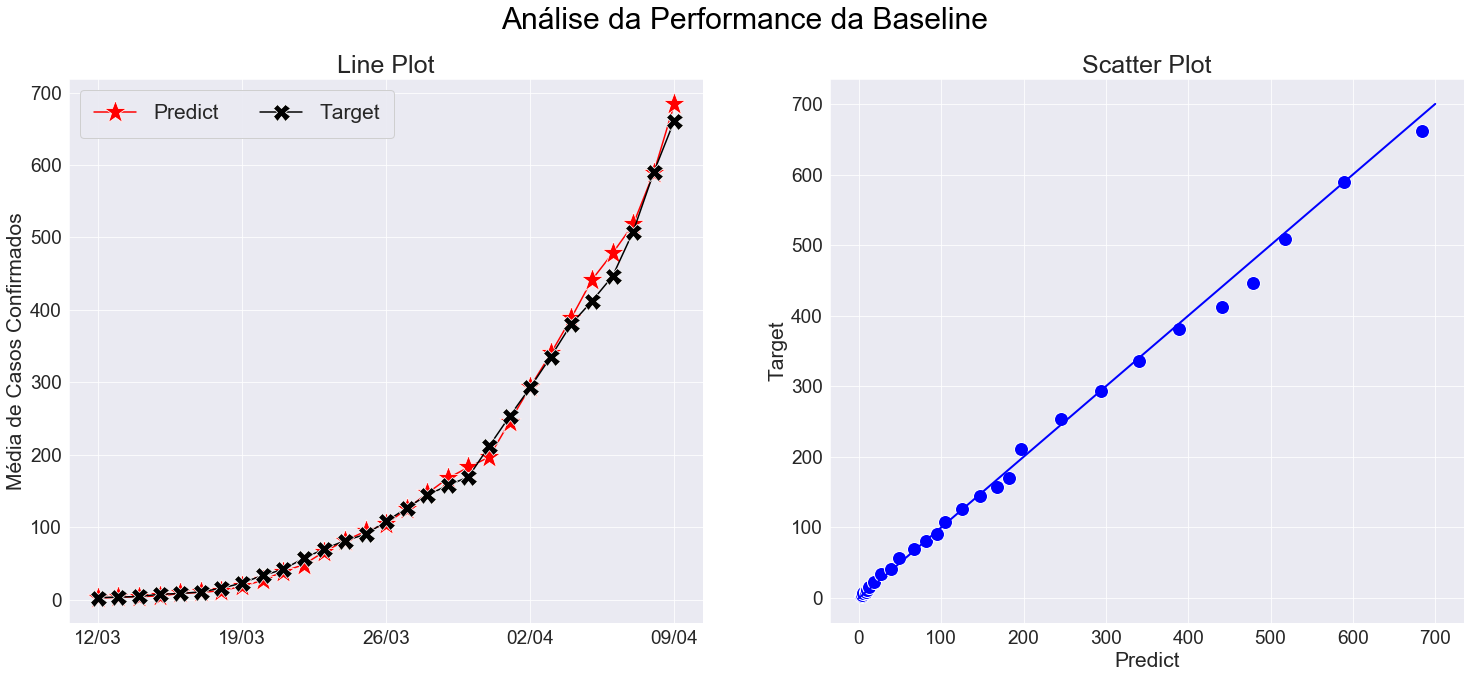

In [35]:
fig , ax = plt.subplots(ncols=2,nrows=1,figsize=(25,10))
fig.suptitle("Análise da Performance da Baseline",fontsize=30,y=0.98,color="black")

#Definindo tamanho das fontes
sizelabel , sizetick , sizetit = 21 , 19 , 25

#Personalizando o formato da data mostrada nos ticks
dateview=[pd.to_datetime(an_base.date)[x].strftime("%d/%m") for x in range(0,len(an_base.date))]

sns.set_style("darkgrid")
sns.lineplot(x=an_base.date,y=an_base.predict_BASE,color="red",marker='*',markersize=24,ax=ax[0],linestyle=':',label='Predict')
sns.lineplot(x=an_base.date,y=an_base.target,color="black",marker='X',markersize=17,ax=ax[0],label='Target')
ax[0].set_ylabel('Média de Casos Confirmados',fontsize=sizelabel)
ax[0].set_title('Line Plot',fontsize=sizetit)
ax[0].set_xlabel('',fontsize=sizelabel)
ax[0].tick_params(axis='x',labelsize=sizetick)
ax[0].tick_params(axis='y',labelsize=sizetick)
ax[0].set_xticks(an_base.date[::-7])
ax[0].set_xticklabels(dateview[::-7])
ax[0].legend(ncol=2,fontsize=21,loc="upper left",frameon=True,framealpha=0.90,borderpad = 0.7)

ax[1].plot(an_base.predict_BASE,an_base.target,color="blue",marker='o',linestyle='none',markersize=14, markeredgecolor="white", markeredgewidth=1) #line_kws={"color":"black","alpha":0.7,"lw":3}
plt.plot([0, 700], [0, 700], color="blue", lw=2, linestyle='solid', label="_not in legend")
ax[1].set_ylabel('Target',fontsize=sizelabel)
ax[1].set_title('Scatter Plot',fontsize=sizetit)
ax[1].set_xlabel('Predict',fontsize=sizelabel)
ax[1].tick_params(axis='x',labelsize=sizetick)
ax[1].tick_params(axis='y',labelsize=sizetick)

plt.show()

## Análise das Métricas
## MAPE

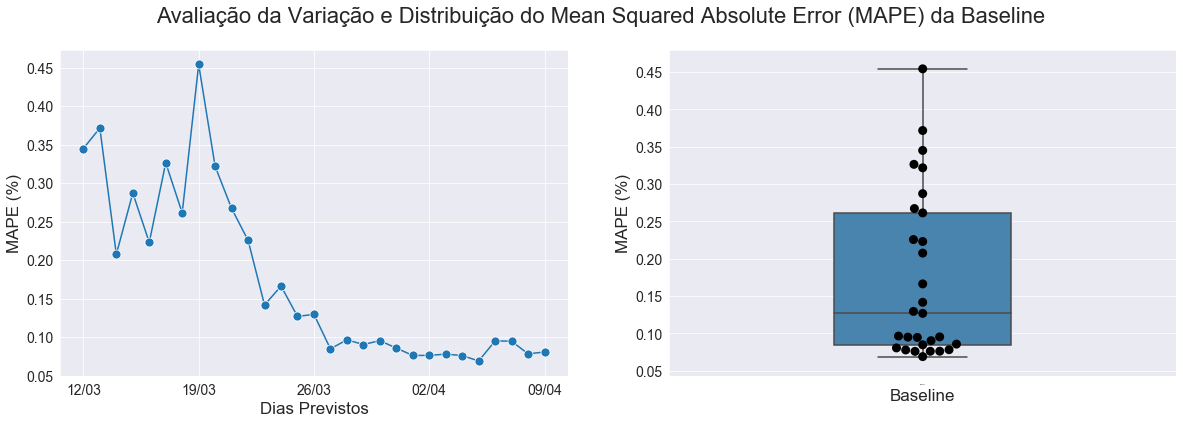

In [36]:
fig , ax = plt.subplots(figsize=(20,6),nrows=1,ncols=2)

sns.set_style("darkgrid")
fig.suptitle("Avaliação da Variação e Distribuição do Mean Squared Absolute Error (MAPE) da Baseline",fontsize=22)

#Gráfico de Linhas
sns.lineplot(x=an_base.date,y=an_base.MAPE_BASE,palette=["blue"],marker='o',linestyle='-',markersize=9,ax=ax[0],legend=False)
ax[0].set_ylabel("MAPE (%)",size=17)
ax[0].set_xlabel("Dias Previstos",size=17)
ax[0].tick_params(axis='x',labelsize=14)
ax[0].tick_params(axis='y',labelsize=14)
ax[0].set_xticks(an_base.date[::-7])
ax[0].set_xticklabels(dateview[::-7])

#Boxplot
sns.boxplot(data=er_base, palette="Blues_d",orient="v",width=0.35,ax=ax[1])
sns.swarmplot(data=er_base, palette=["black"],orient="v",color=.20,size=9,ax=ax[1])
ax[1].set_ylabel("MAPE (%)",size=17)
ax[1].set_xlabel("Baseline",size=17)
ax[1].tick_params(axis='x',labelsize=0)
ax[1].tick_params(axis='y',labelsize=14)
plt.show()

## RMSLE

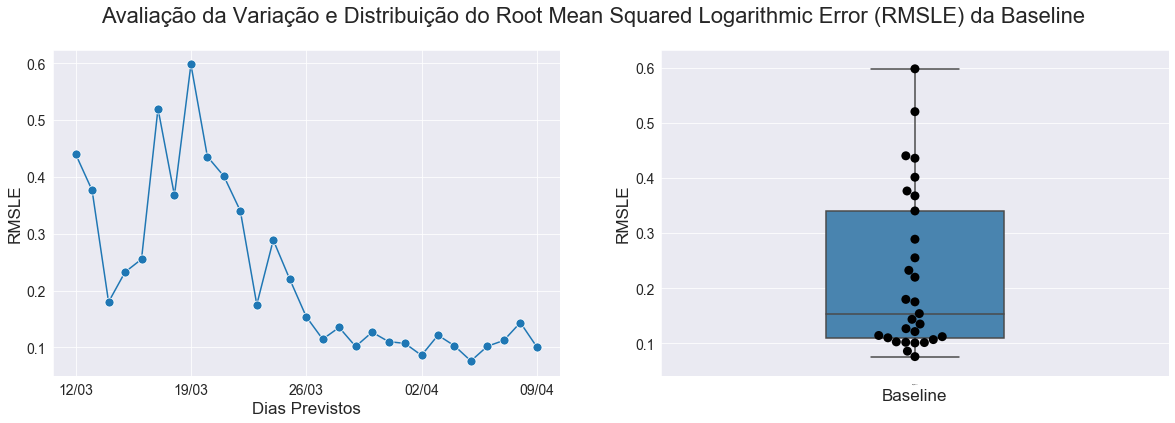

In [37]:
fig , ax = plt.subplots(figsize=(20,6),nrows=1,ncols=2)

sns.set_style("darkgrid")
fig.suptitle("Avaliação da Variação e Distribuição do Root Mean Squared Logarithmic Error (RMSLE) da Baseline",fontsize=22)

#Gráfico de Linhas
sns.lineplot(x=an_base.date,y=an_base.RMSLE_BASE,palette=["blue"],marker='o',linestyle='-',markersize=9,ax=ax[0],legend=False)
ax[0].set_ylabel("RMSLE",size=17)
ax[0].set_xlabel("Dias Previstos",size=17)
ax[0].tick_params(axis='x',labelsize=14)
ax[0].tick_params(axis='y',labelsize=14)
ax[0].set_xticks(an_base.date[::-7])
ax[0].set_xticklabels(dateview[::-7])

#Boxplot
sns.boxplot(data=er2_base, palette="Blues_d",orient="v",width=0.35,ax=ax[1])
sns.swarmplot(data=er2_base, palette=["black"],orient="v",color=.20,size=9,ax=ax[1])
ax[1].set_ylabel("RMSLE",size=17)
ax[1].set_xlabel("Baseline",size=17)
ax[1].tick_params(axis='x',labelsize=0)
ax[1].tick_params(axis='y',labelsize=14)
plt.show()

## RSLE e MAPE por Estado

In [38]:
pd.concat([m2_base,m_base],axis=1).sort_values(by='BASE_RSLE',ascending=True).style.background_gradient(cmap='hot_r',vmin=0,vmax=.5)

## Com base nessas análises, podemos concluir que a baseline atingiu um bom aproveitamento com uma dinâmica simples, onde prevemos o total de casos do dia seguinte como o número de casos do dia anterior com um acréscimo de 16%. Logo, resta a dúvida se modelos de Machine Learning conseguirão superar esse tipo de baseline.

## Outra conclusão que obtemos é a seguinte. Com base no número de casos confirmados por dia devemos atribuir valores diferentes para a análise das métricas de cada estado, por exemplo se compararmos um erro de 25% na previsão de dois estados, onde um possui um baixo número de casos confirmados por dia (ex.: 20, teremos um erro de +-5) e outro com um alto (ex.: 200, teremos um erro de +-50), a margem de erro será relativamente diferente para os dois. Logo, devemos determinar a métrica objetiva de acordo com o volume médio de casos de cada estado.

## Visualizando a média de casos confirmados por dia nos estados

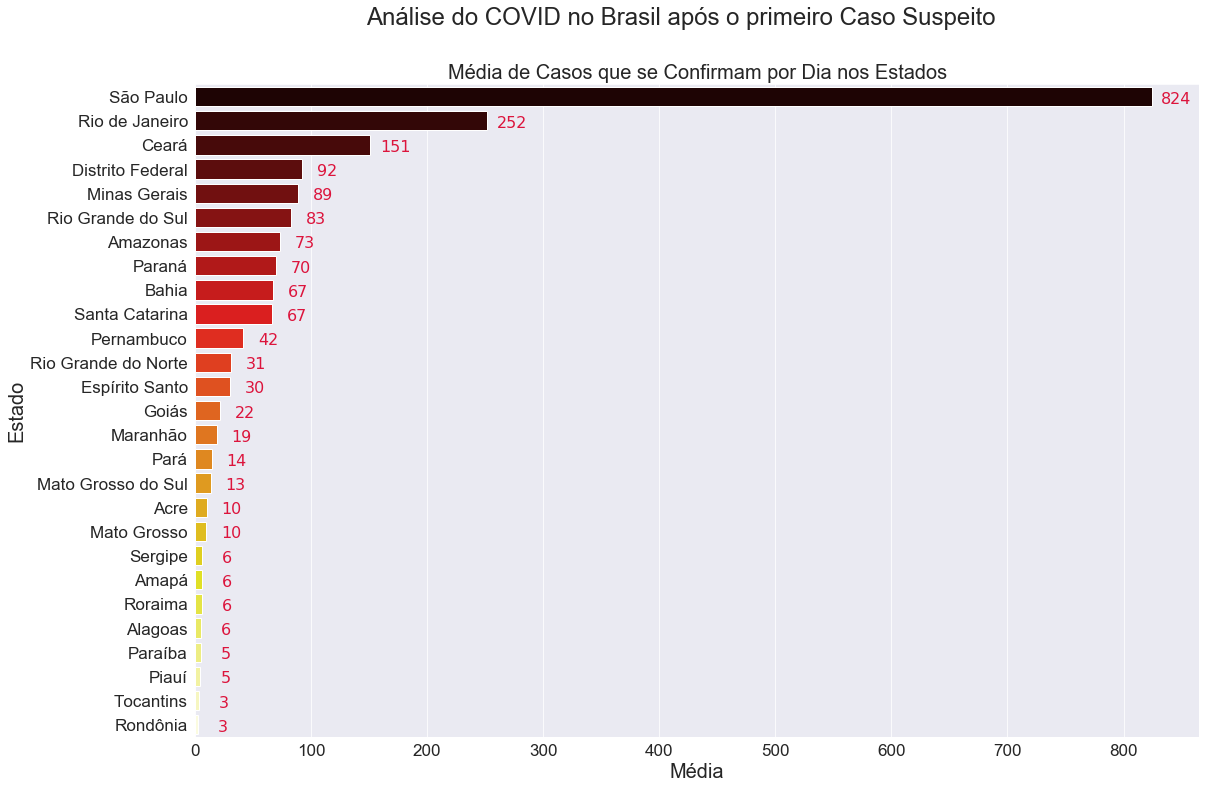

In [20]:
#Selecionando dataframe e criando visualização
mean_cases=pd.DataFrame(date_state.groupby('state').mean().cases).reset_index()
mean_cases.sort_values(by='cases',ascending=False,ignore_index=True,inplace=True)

fig , ax = plt.subplots(figsize=(18,12),nrows=1,ncols=1)

sns.set_style("darkgrid")
fig.suptitle("Análise do COVID no Brasil após o primeiro Caso Suspeito",fontsize=24,y=0.97)
sns.barplot(x=mean_cases.cases,y=mean_cases.state,orient='h',palette="hot") #,label=mean_cases.state
ax.set_ylabel("Estado",size=20)
ax.set_title("Média de Casos que se Confirmam por Dia nos Estados",fontsize=20)
ax.set_xlabel("Média",size=20)
ax.tick_params(axis='x',labelsize=17)
ax.tick_params(axis='y',labelsize=17)
#ax.set(xticks=range(0,210,10))

#Colocando valores no gráfico
for valor in range(0,27):
    label = "{:,.0f}".format(mean_cases.cases[valor])
    ax.annotate(label, (mean_cases.cases[valor],mean_cases.state.index[valor]), textcoords="offset points", xytext=(25,-2), ha='center',va='center',
                size=16, color = 'crimson',alpha=1,style='normal',fontname='Futura')#,family='sans-serif'
    
plt.show()

## Logo devemos atribuir métricas com valores de avaliação diferentes para cada grupo de estados sendo dividos em:
### Grupo 1 : São Paulo (RMSLE < 0.10)
### Grupo 2 : Estados com média maior que 100, com exceção de SP - Rio de Janeiro e Ceará (RMSLE < 0.15)
### Grupo 3 : Estados com média entre 20 e 100 (RMSLE < 0.20)
### Grupo 4 : Estados com média entre 5 e 20 (RMSLE < 0.25)

# 

# MODELAGEM

## Escolher as features adequadas para introdução nos modelos, onde retiraremos variáveis obsoletas (que não serão atualizadas nas previsões no futuro), inadequadas (formatos diferentes) e desnecessárias (variáveis que se substituem de forma semelhante ou até por uma variável melhor)

In [39]:
#Visualizando variáveis finais do dataset
date_state.columns.values

array(['date', 'state', 'cases', 'deaths', 'Latitude', 'Longitude',
       'Densidade', 'area_state', 'Região', 'UF', 'Population_2019',
       'Day', 'new_cases', 'new_deaths', 'Semana_do_Ano', 'Dia_do_Ano',
       'Mes', 'Dia', 'Isolamento', 'Dias_de_Isolamento', 'IIS_BR',
       'IIS_per_Cases', 'count_cities', 'Population_2019_cities',
       'area_cities', 'cases_cities', 'Densidade_cities',
       'Hab_per_Case_cities', 'Case_per_Km2_cities',
       'Hab_per_Cases_per_Km2_cities', 'infec_state_area',
       'infec_state_population', 'cases_font2', 'new_cases_font2',
       'Cases_Last_Day', 'Diff_Cases_Last_Day', 'Cases_Last_Day_1',
       'Diff_Cases_Last_Day_1', 'Cases_Last_Day_2',
       'Diff_Cases_Last_Day_2', 'Cases_por_Population_Last_Day',
       'Cases_por_Densidade_Last_Day', 'Mean_Cases_Last_Days_3',
       'Desvio_Cases_Last_Days_3', 'Mean_Cases_Last_Days_7',
       'Desvio_Cases_Last_Days_7', 'Mean_Diff_Cases_Last_Days_3',
       'Max_Diff_Cases_Last_Days_3', 'Desvio

In [40]:
#Selecionando as features
features = [
       'Densidade', 'area_state', 'Population_2019',
       'Day', 'Semana_do_Ano', 'Dia_do_Ano',
       'Mes', 'Dia', 'Isolamento', 'Dias_de_Isolamento',
       'Cases_Last_Day', 'Diff_Cases_Last_Day', 'Cases_Last_Day_1',
       'Diff_Cases_Last_Day_1', 'Cases_Last_Day_2',
       'Diff_Cases_Last_Day_2', 'Cases_por_Population_Last_Day',
       'Cases_por_Densidade_Last_Day', 'Mean_Cases_Last_Days_3',
       'Desvio_Cases_Last_Days_3', 'Mean_Cases_Last_Days_7',
       'Desvio_Cases_Last_Days_7', 'Mean_Diff_Cases_Last_Days_3',
       'Max_Diff_Cases_Last_Days_3', 'Desvio_Diff_Cases_Last_Days_3',
       'Mean_Diff_Cases_Last_Days_7', 'Max_Diff_Cases_Last_Days_7',
       'Desvio_Diff_Cases_Last_Days_7', 'UF_CAT_AC', 'UF_CAT_AL',
       'UF_CAT_AP', 'UF_CAT_AM', 'UF_CAT_BA', 'UF_CAT_CE', 'UF_CAT_DF',
       'UF_CAT_ES', 'UF_CAT_GO', 'UF_CAT_MA', 'UF_CAT_MT', 'UF_CAT_MS',
       'UF_CAT_MG', 'UF_CAT_PR', 'UF_CAT_PB', 'UF_CAT_PA', 'UF_CAT_PE',
       'UF_CAT_PI', 'UF_CAT_RN', 'UF_CAT_RS', 'UF_CAT_RJ', 'UF_CAT_RO',
       'UF_CAT_RR', 'UF_CAT_SC', 'UF_CAT_SE', 'UF_CAT_SP', 'UF_CAT_TO',
       'REG_CAT_Norte', 'REG_CAT_Nordeste', 'REG_CAT_Centro-Oeste',
       'REG_CAT_Sudeste', 'REG_CAT_Sul', 'DIST_RJ', 'DIST_CE', 'DIST_SP'
            ]

#Quantidade selecionada
len(features)

63

## Inicialmente, começaremos com a análise da eficiência dos seguintes algoritmos sem qualquer mudança de parâmetros e considerando apenas uma variável, o número total de casos do dia anterior.
### Random Forest, k-NN Regressor, Linear Regression, XGB Regressor, Decision Trees (CART), LightGBM e Ridge Regression

In [23]:
#Configurando variáveis
error=[]
error2=[]

#Instânciando modelos
models=[RandomForestRegressor(n_jobs=-1,random_state=0),
        KNeighborsRegressor(n_jobs=-1),
        LinearRegression(n_jobs=-1),
        XGBRegressor(n_jobs=-1,random_state=0),
        DecisionTreeRegressor(random_state=0),
        LGBMRegressor(n_jobs=-1,random_state=0),
        Ridge(random_state=0)]

name_mod=['RF','KNN','LR','XGB','CART','LGBM','RID']

for num in range(0,len(models)):
    
    error=[]
    error2=[]

    for i in range(mn,mx+1):
        if date_state[date_state['Day']==i].shape[0] !=0:

            train=date_state[date_state['Day']<i]
            test=date_state[date_state['Day']==i]

            sel=['Cases_Last_Day']
            X_train=train.loc[:,sel].values
            y_train=train['cases'].values
            X_test=test.loc[:,sel].values
            y_test=test['cases'].values

            model=models[num]
            model.fit(X_train,y_train)

            y_pred=model.predict(X_test)

            e = MAPE(y_pred,y_test)
            error.append(e)
            e2 = RMSLE(y_pred,y_test)
            error2.append(e2)     

    #Imprimir mensagem para cada algorimo mostrando os scores
    msg=print("\n{}\nMédia do Erro MAPE: {:.4f}%\nMédia do Erro RMSLE: {:.4f}".format(name_mod[num],np.mean(error)*100,np.mean(error2)))


RF
Média do Erro MAPE: 22.9735%
Média do Erro RMSLE: 0.2529

KNN
Média do Erro MAPE: 22.2962%
Média do Erro RMSLE: 0.2622

LR
Média do Erro MAPE: 20.0074%
Média do Erro RMSLE: 0.2174

XGB
Média do Erro MAPE: 23.8018%
Média do Erro RMSLE: 0.2581

CART
Média do Erro MAPE: 23.6353%
Média do Erro RMSLE: 0.2574

LGBM
Média do Erro MAPE: 53.0264%
Média do Erro RMSLE: 0.4612

RID
Média do Erro MAPE: 20.0037%
Média do Erro RMSLE: 0.2174


## Logo, sem qualquer tipo de tunning (modificação nos parâmetros), os melhores algoritmos pelo critério de RMSLE foram o Ridge e a Linear Regression, respectivamente, conseguindo superar a baseline que possui RMSLE de 0.2252. O XGBoost Regressor, a Decision Trees (CART) e a Random Forest também apresentaram bons resultados iniciais, e por uma diferença de aproximadamente 3 centésimos ficaram atrás da baseline. Logo atrás desses 3 algoritmos vem o k-NN Regressor com RMSLE de 0.2622. Já o LightGBM  apresentou um resultado muito ruim, apresentando mais que o dobro do score alcançado pela Baseline.
## Porém, vale ressaltar que ajustes nos hiperparâmetros e adição de boas features podem e devem melhorar os resultados dos algoritmos, a questão é se essa melhora será significativa a ponto de conseguirem bater a baseline. Deste modo, em seguida irei tunar os hiperparâmetros de alguns algoritmos conhecidos de forma intuitiva/manual para tentar aumentar a performance dos modelos. Posteriormente, utilizarei os métodos da Random Search e do Bayesian Optimize para realizar esse tunning de forma automática e bem mais eficiente, uma vez que buscam minimizar o erro definido de forma direta.

# 

## Realizando o tunning de forma manual

In [41]:
#Configurando variáveis
error=[]
error2=[]

models=[RandomForestRegressor(n_jobs=-1,random_state=0,n_estimators=125),
        KNeighborsRegressor(n_jobs=-1,n_neighbors=3),
        LinearRegression(n_jobs=-1),
        XGBRegressor(n_jobs=-1,random_state=0,n_estimators=75),
        DecisionTreeRegressor(random_state=0),
        LGBMRegressor(n_jobs=-1,random_state=0,n_estimators=250,learning_rate=0.01),
        Ridge(random_state=0,alpha=0.03,normalize=True,fit_intercept=True)]

name_mod=['RF','KNN','LR','XGB','CART','LGBM','RID']

#Definindo os modelos a serem treinados com o tunning

for num in range(0,len(models)):

    error=[]
    error2=[]
    
    for i in range(mn,mx+1):
        if date_state[date_state['Day']==i].shape[0] !=0:

            train=date_state[date_state['Day']<i]
            test=date_state[date_state['Day']==i]

            sel=['Cases_Last_Day']
            X_train=train.loc[:,sel].values
            y_train=train['cases'].values
            X_test=test.loc[:,sel].values
            y_test=test['cases'].values

            model=models[num]
            model.fit(X_train,y_train)

            y_pred=model.predict(X_test)

            e = MAPE(y_pred,y_test)
            error.append(e)
            e2 = RMSLE(y_pred,y_test)
            error2.append(e2)       

    #Imprimir mensagem para cada algorimo mostrando os scores
    msg=print("\n{}\nMédia do Erro MAPE: {:.4f}%\nMédia do Erro RMSLE: {:.4f}".format(name_mod[num],np.mean(error)*100,np.mean(error2)))


RF
Média do Erro MAPE: 22.9767%
Média do Erro RMSLE: 0.2529

KNN
Média do Erro MAPE: 22.7549%
Média do Erro RMSLE: 0.2596

LR
Média do Erro MAPE: 20.0074%
Média do Erro RMSLE: 0.2174

XGB
Média do Erro MAPE: 23.7483%
Média do Erro RMSLE: 0.2575

CART
Média do Erro MAPE: 23.6353%
Média do Erro RMSLE: 0.2574

LGBM
Média do Erro MAPE: 48.9563%
Média do Erro RMSLE: 0.4543

RID
Média do Erro MAPE: 19.4012%
Média do Erro RMSLE: 0.2163


## Com esses breves ajustes baseados no conhecimento de cada algoritmo e seus parâmetros, podemos perceber algumas pequenas melhoras nos scores do k-NN e do LGBM, os demais não obtiveram melhoras significativas. Desta forma, com um tunning realizado de forma mais eficaz pode ser que ocorra um aumento nas métricas de forma que conseguigam se aproximar da baseline.

# 

## Tunar hiperparâmetros dos modelos utilizando dois métodos do scikit-optimize

## Grid Search x Random Search x Bayesian Optimization (minimizar a loss function)

### GS - Faz uma busca exaustiva, dando importância igual para os mesmos parâmetros, gastando mais tempo e recurso computacional.
### RS - Faz uma busca aleatória, explorando melhor os espaços.
### BO - Monta um dataset com os parâmetros e o respectivo score, com finalidade de prever o score, e o método utilizará esse modelo para guiar a busca que minimizará a loss function e consequentemente obtendo um melhor score, explorando com mais efetividade os espaços.

## LightGBM
## Random Search

In [30]:
?LGBMRegressor

In [95]:
#Definindo função para treino

def train_lgbm(params):
    #Regularizadores para que não ocorra memorização dos dados, o temido overfitting
    learning_rate = params[0] #contribuição de cada árvore no modelo
    num_leaves = params[1] #núm. max. de folhas em cada árvore (nós) #quanto mais, maior a complexidade do modelo
    min_child_samples = params[2] #núm. de exemplos em cada nó nas árvores do modelo (regular o número de amostras para se obter uma estimativa confiável)
    subsample = params[3] #cria uma amostra para cada árvore em vez de utilizar todos os dados
    colsample_bytree = params[4] #limita cada árvore com um número limitado de features
    
    model = LGBMRegressor(learning_rate=learning_rate,num_leaves=num_leaves,min_child_samples=min_child_samples,
                          subsample=subsample,colsample_bytree=colsample_bytree,random_state=0,subsample_freq=1,n_estimators=100,n_jobs=-1)

    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    return RMSLE(y_pred,y_test)

#Específicar o intervalo de otimização de cada hiperparâmetro
space = [(1e-3,1e-1,'log-uniform'), #learning rate objetivo em explorar valores baixos
        (2,128), #num_leaves
        (1,100), #min_child_samples
        (0.05,1.0), #subsamples
        (0.1,1.0)] #colsample bytree

In [43]:
#Definindo intervalo de treino e validação
mn=71
mx=71

In [96]:
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features #['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        rs_hip_lgbm = dummy_minimize(train_lgbm,space,random_state=0,verbose=0,n_calls=50)
        print(rs_hip_lgbm.x)
        print(rs_hip_lgbm.fun)

[0.025572734343076983, 34, 12, 0.9235084830574399, 0.7428171695942003]
0.2802063998664331


## Bayesian Optimization

In [97]:

    
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features #['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        bo_hip_lgbm = gp_minimize(train_lgbm,space,random_state=0,verbose=0,n_calls=50,n_random_starts=10)
        #random starts seleciona 10 pontos iniciais aleatoriamente para iniciar a busca, em seguida com a criação do modelo com os parâmetros e scores ele seleciona sempre o ponto mais promissor
        #desta forma, ele concede mais importância aos parâmetros relevantes
        
        print(bo_hip_lgbm.x)
        print(bo_hip_lgbm.fun)

[0.1, 115, 1, 0.4682239281869186, 1.0]
0.10592825535343237


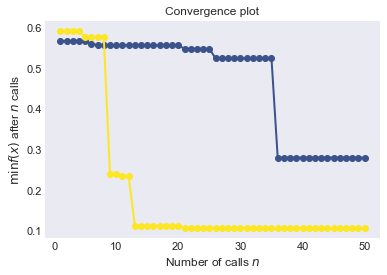

In [98]:
#Resultado gráfico do procedimento de otimização dos dois métodos
plot_convergence(rs_hip_lgbm,bo_hip_lgbm)

## Podemos perceber um resultado altamente significativo no tunning dos hiperparâmetros do LightGBM, principalmente com o Bayesian Optimize, produzindo uma melhora no RMSLE.

## Random Forest
## Random Search

In [224]:
?RandomForestRegressor

In [99]:
def train_rf(params):
    n_estimators = params[0] 
    min_samples_leaf = params[1]
    ccp_alpha = params[2]
    
    model = RandomForestRegressor(n_estimators = n_estimators,min_samples_leaf=min_samples_leaf,ccp_alpha=ccp_alpha,random_state=0,n_jobs=-1)

    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    return RMSLE(y_pred,y_test)

space = [(1,100), (1,128), (0.0,2.0)]

In [100]:

    
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features #['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        rs_hip_rf = dummy_minimize(train_rf,space,random_state=0,verbose=0,n_calls=50)
        print(rs_hip_rf.x)
        print(rs_hip_rf.fun)

[12, 3, 0.2635957248087844]
0.14381374061851285


## Bayesian Optimization

In [101]:
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features #['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        bo_hip_rf = gp_minimize(train_rf,space,random_state=0,verbose=0,n_calls=50,n_random_starts=10)
        
        print(bo_hip_rf.x)
        print(bo_hip_rf.fun)

[66, 1, 0.0]
0.13591793590151066


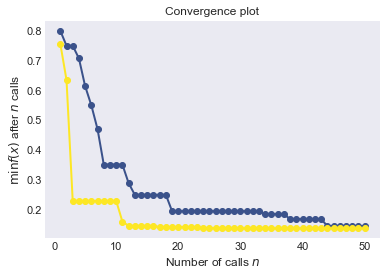

In [102]:
plot_convergence(rs_hip_rf,bo_hip_rf)

## Comparando os resultados dos métodos, concluímos que não há diferença significativa entre os dois, mas o Bayesian Optimize ainda fica na frente.

## k-NN Regressor
## Random Search

In [242]:
?KNeighborsRegressor

In [103]:
def train_knn(params):
    n_neighbors = params[0] 
    weights = params[1]
    algorithm = params[2]
    leaf_size = params[3]
    p = params[4]
    
    model = KNeighborsRegressor(n_neighbors=n_neighbors,weights=weights,algorithm=algorithm,leaf_size=leaf_size,p=p,n_jobs=-1)

    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    return RMSLE(y_pred,y_test)

space = [(1,50), ['uniform', 'distance'], ['auto', 'ball_tree', 'kd_tree', 'brute'],(1,50),[1,2]]

In [104]:
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features #['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        rs_hip_knn = dummy_minimize(train_knn,space,random_state=0,verbose=0,n_calls=50)
        print(rs_hip_knn.x)
        print(rs_hip_knn.fun)

[1, 'uniform', 'kd_tree', 39, 1]
0.1591972216564028


## Bayesian Optimization

In [105]:
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features #['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        bo_hip_knn = gp_minimize(train_knn,space,random_state=0,verbose=0,n_calls=50,n_random_starts=10)
        
        print(bo_hip_knn.x)
        print(bo_hip_knn.fun)

[1, 'uniform', 'ball_tree', 46, 1]
0.1591972216564028


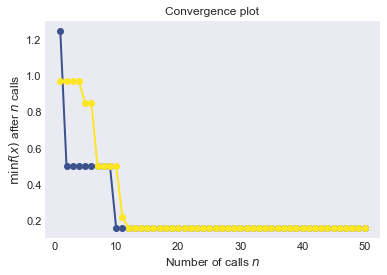

In [106]:
plot_convergence(rs_hip_knn,bo_hip_knn)

## Pelos resultados obtidos, é possível perceber que não há diferença na performance do algoritmo com o tunning desses parâmetros.

## CART
## Random Search

In [264]:
?DecisionTreeRegressor

In [107]:
def train_cart(params):
    min_samples_leaf = params[0] 
    ccp_alpha = params[1]
    splitter = params[2]
    criterion = params[3]
    max_features = params[4]
    min_samples_split = params[5]
    
    model = DecisionTreeRegressor(random_state=0,min_samples_leaf = min_samples_leaf,
                        ccp_alpha = ccp_alpha,splitter = splitter,criterion = criterion,min_samples_split=min_samples_split)
                         
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    return RMSLE(y_pred,y_test)

space = [(1,256),(0.0,1.0), ["best", "random"],["mse", "friedman_mse"],["auto", "sqrt", "log2"],(2,128)]

In [108]:
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features #['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        rs_hip_cart = dummy_minimize(train_cart,space,random_state=0,verbose=0,n_calls=50)
        print(rs_hip_cart.x)
        print(rs_hip_cart.fun)

[3, 0.2700079731921649, 'random', 'friedman_mse', 'auto', 21]
0.1893530066625916


## Bayesian Optimization

In [109]:
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features #['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        bo_hip_cart = gp_minimize(train_cart,space,random_state=0,verbose=0,n_calls=50,n_random_starts=10)
        
        print(bo_hip_cart.x)
        print(bo_hip_cart.fun)

[1, 0.0, 'random', 'friedman_mse', 'auto', 2]
0.18179310977940719


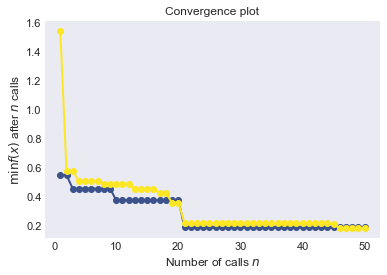

In [110]:
plot_convergence(rs_hip_cart,bo_hip_cart)

## Com base nos resultados obtidos, é possível perceber que não há diferença na performance do algoritmo com o tunning desses parâmetros.

## Ridge Regression
## Random Search

In [271]:
?Ridge

In [111]:
def train_rid(params):
    #normalize = params[0] 
    #fit_intercept = params[1]
    alpha = params[0]
    #solver = params[3]
    #max_iter = params[4]
    
    model = Ridge(alpha=alpha,normalize=True,fit_intercept=True) #normalize=normalize,fit_intercept=fit_intercept,alpha=alpha,solver=solver,max_iter=max_iter)

    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    return RMSLE(y_pred,y_test)

#space = [['True', 'False'],['True', 'False'],(0.0,5),['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],(500,1000)]
space = [(0.00,0.1)]

In [112]:

     
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features #['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        rs_hip_rid = dummy_minimize(train_rid,space,random_state=0,verbose=0,n_calls=50)
        print(rs_hip_rid.x)
        print(rs_hip_rid.fun)

[0.014035078041264517]
0.10537124429435382


## Bayesian Optimization

In [113]:
for i in range(mn,mx+1):
    if date_state[date_state['Day']==i].shape[0] !=0:

        train=date_state[date_state['Day']<i]
        test=date_state[date_state['Day']==i]

        sel=features#['Cases_Last_Day']
        X_train=train.loc[:,sel]
        y_train=train['cases'].values
        X_test=test.loc[:,sel].values
        y_test=test['cases'].values
            
        bo_hip_rid = gp_minimize(train_rid,space,random_state=0,verbose=0,n_calls=50,n_random_starts=10)
        
        print(bo_hip_rid.x)
        print(bo_hip_rid.fun)

[0.013801730894282022]
0.10536906280097857


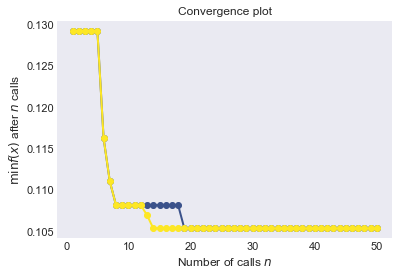

In [114]:
plot_convergence(rs_hip_rid,bo_hip_rid)

## O parâmetro que está tendo valor significativo para a otimização do algoritmo é o alpha, os demais não influenciam na minimização do erro. Porém, os dois métodos obtém resultados praticamente iguais.

# 

## Resultado do treinos com os tunnings

In [45]:
#Configurando variáveis
mn=43
mx=71

models=[RandomForestRegressor(n_jobs=-1,random_state=0,n_estimators=66,min_samples_leaf=1,ccp_alpha=0.0),
        KNeighborsRegressor(n_neighbors=1,weights='uniform',algorithm='ball_tree',leaf_size=46,p=1),
        LinearRegression(n_jobs=-1),
        XGBRegressor(n_jobs=-1,random_state=0),
        DecisionTreeRegressor(min_samples_leaf=1,ccp_alpha=0,splitter='random',criterion='friedman_mse',max_features='auto',min_samples_split=2,random_state=0),
        LGBMRegressor(n_jobs=-1,random_state=0,n_estimators=100,learning_rate=0.1,num_leaves = 115,min_child_samples = 1,subsample = 0.4682239281869186,
                      colsample_bytree = 1.0),
        Ridge(random_state=0,alpha=0.013801730894282022)]


name_mod=['RF','KNN','LR','XGB','CART','LGBM','RID']

for num in range(0,len(models)):
    
    error=[]
    error2=[]
    
    for i in range(mn,mx+1):
        if date_state[date_state['Day']==i].shape[0] !=0:

            train=date_state[date_state['Day']<i]
            test=date_state[date_state['Day']==i]

            sel=['Cases_Last_Day']
            X_train=train.loc[:,sel].values
            y_train=train['cases'].values
            X_test=test.loc[:,sel].values
            y_test=test['cases'].values

            model=models[num]
            model.fit(X_train,y_train)

            y_pred=model.predict(X_test)

            e = MAPE(y_pred,y_test)
            error.append(e)
            e2 = RMSLE(y_pred,y_test)
            error2.append(e2)

    #Imprimir mensagem para cada algorimo mostrando os scores
    msg=print("\n{}\nMédia do Erro MAPE: {:.4f}%\nMédia do Erro RMSLE: {:.4f}".format(name_mod[num],np.mean(error)*100,np.mean(error2)))


RF
Média do Erro MAPE: 22.9692%
Média do Erro RMSLE: 0.2531

KNN
Média do Erro MAPE: 27.7604%
Média do Erro RMSLE: 0.2901

LR
Média do Erro MAPE: 20.0074%
Média do Erro RMSLE: 0.2174

XGB
Média do Erro MAPE: 23.8018%
Média do Erro RMSLE: 0.2581

CART
Média do Erro MAPE: 23.9308%
Média do Erro RMSLE: 0.2587

LGBM
Média do Erro MAPE: 23.3230%
Média do Erro RMSLE: 0.2556

RID
Média do Erro MAPE: 20.0073%
Média do Erro RMSLE: 0.2174


## Percebemos apenas uma melhora significativa no algoritmo do LGBM, ultrapassando o score atingido por vários modelos, porém ainda sem superar a Baseline. Os algoritmos restantes não obtiveram nada de acréscimo, pelo contrário, alguns scores até pioraram. Contudo, há alguns motivos para essa situação como: os algoritmos podem estarem em seus limites de otimização ou os hiperparâmetros não foram explorados da forma correta ou o uso dos métodos de otimização não foram adequados.

## Portanto, com todas essas etapas de otimização os únicos algoritmos que superaram a baseline foram os modelos Ridge Regressor e a Linear Regression. Outro desataque é o LightGBM, que obteve uma melhora considerável na otimização dos parâmetros, sem contar que ele juntamente com os outros algoritmos podem conseguir melhoras substanciais com a adição de novas variáveis significativas ao modelo.
## Deste modo, treinaremos o modelo novamente com os melhores hiperparâmetros obtidos, onde o único que vamos alterar do ajuste manual para o automático é o LGBM. Em sequência, analisaremos a performance desses modelos durante o treino e validação e posteriormente realizaremos o feature selection para os modelos.

In [46]:
models=[RandomForestRegressor(n_jobs=-1,random_state=0,n_estimators=125),
        KNeighborsRegressor(n_jobs=-1,n_neighbors=3),
        LinearRegression(n_jobs=-1),
        XGBRegressor(n_jobs=-1,random_state=0,n_estimators=75),
        DecisionTreeRegressor(random_state=0),
        LGBMRegressor(n_jobs=-1,random_state=0,n_estimators=100,learning_rate=0.1,num_leaves = 115,min_child_samples = 1,subsample = 0.4682239281869186,colsample_bytree = 1.0),
        Ridge(random_state=0,alpha=0.03,normalize=True,fit_intercept=True)]

name_mod=['RF','KNN','LR','XGB','CART','LGBM','RID']

#Definindo os modelos a serem treinados com o tunning
#...

#Criando dataframe para análise da performance do modelo
analytics=pd.DataFrame(columns=['date','Day','target','predict','MAPE','RMSE','RMSLE'])

for num in range(0,len(models)):
    
    error=[]
    error2=[]
    analytics=pd.DataFrame(columns=['date','Day','target','predict_{}'.format(name_mod[num]),'MAPE_{}'.format(name_mod[num]),'RMSE_{}'.format(name_mod[num]),'RMSLE_{}'.format(name_mod[num])])
    
    for i in range(mn,mx+1):
        if date_state[date_state['Day']==i].shape[0] !=0:

            train=date_state[date_state['Day']<i]
            test=date_state[date_state['Day']==i]

            sel=['Cases_Last_Day']
            X_train=train.loc[:,sel].values
            y_train=train['cases'].values
            X_test=test.loc[:,sel].values
            y_test=test['cases'].values

            model=models[num]
            model.fit(X_train,y_train)

            y_pred=model.predict(X_test)

            y_state=test['state'].values
            aux=MAPE_STATE(y_pred,y_test,y_state)
            aux=aux.set_index(aux.state).drop(columns='state')
            if(i==mn):
                m=aux
            else:
                m=m.merge(aux,how='outer',on='state')
                
            aux2=RSLE_STATE(y_pred,y_test,y_state)
            aux2=aux2.set_index(aux2.state).drop(columns='state')
            if(i==mn):
                m2=aux2
            else:
                m2=m2.merge(aux2,how='outer',on='state')                 
            
            e = MAPE(y_pred,y_test)
            error.append(e)
            e2 = RMSLE(y_pred,y_test)
            error2.append(e2)              

            #Guardando predicts, targets e outras informações para análise do desempenho do modelo
            att=pd.DataFrame({'date':test.date.max(),'Day':test.Day.max(),'target':y_test.mean(),'predict_{}'.format(name_mod[num]):y_pred.mean(),
                              'MAPE_{}'.format(name_mod[num]):MAPE(y_pred,y_test),'RMSLE_{}'.format(name_mod[num]):RMSLE(y_pred,y_test),'RMSE_{}'.format(name_mod[num]):RMSE(y_pred,y_test)},index=[0])

            #Atualizando dataframe de análise
            analytics=pd.concat([analytics,att]).reset_index(drop=True,level=0)        

    #Imprimir mensagem para cada algorimo mostrando os scores
    msg=print("\n{}\nMédia do Erro MAPE: {:.4f}%\nMédia do Erro RMSLE: {:.4f}".format(name_mod[num],np.mean(error)*100,np.mean(error2)))
    
    if name_mod[num] == 'RF':
        er_rf=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_rf=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_rf=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_rf],axis=1);
        m2_rf=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_rf],axis=1);
        an_rf=analytics; ANALYTICS=ANALYTICS.merge(an_rf.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'KNN':
        er_knn=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_knn=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_knn=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_knn],axis=1);
        m2_knn=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_knn],axis=1);
        an_knn=analytics; ANALYTICS=ANALYTICS.merge(an_knn.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'LR':
        er_lr=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_lr=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_lr=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_lr],axis=1);
        m2_lr=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_lr],axis=1);
        an_lr=analytics; ANALYTICS=ANALYTICS.merge(an_lr.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'XGB':
        er_xgb=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_xgb=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_xgb=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_xgb],axis=1);
        m2_xgb=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_xgb],axis=1);
        an_xgb=analytics; ANALYTICS=ANALYTICS.merge(an_xgb.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'CART':
        er_cart=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_cart=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_cart=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_cart],axis=1);
        m2_cart=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_cart],axis=1);
        an_cart=analytics; ANALYTICS=ANALYTICS.merge(an_cart.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'LGBM':
        er_lgbm=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_lgbm=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_lgbm=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_lgbm],axis=1);
        m2_lgbm=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_lgbm],axis=1);
        an_lgbm=analytics; ANALYTICS=ANALYTICS.merge(an_lgbm.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'RID':
        er_rid=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_rid=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_rid=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_rid],axis=1);
        m2_rid=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_rid],axis=1);
        an_rid=analytics; ANALYTICS=ANALYTICS.merge(an_rid.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
        
#Detalhe: sempre que for usado o dataframe ANALYTICS para avaliar a performance, a Baseline deve ser treinada novamente, para reiniciar o dataframe.


RF
Média do Erro MAPE: 22.9767%
Média do Erro RMSLE: 0.2529

KNN
Média do Erro MAPE: 22.7549%
Média do Erro RMSLE: 0.2596

LR
Média do Erro MAPE: 20.0074%
Média do Erro RMSLE: 0.2174

XGB
Média do Erro MAPE: 23.7483%
Média do Erro RMSLE: 0.2575

CART
Média do Erro MAPE: 23.6353%
Média do Erro RMSLE: 0.2574

LGBM
Média do Erro MAPE: 23.3230%
Média do Erro RMSLE: 0.2556

RID
Média do Erro MAPE: 19.4012%
Média do Erro RMSLE: 0.2163


## Análise gráfica do treino e validação dos algoritmos

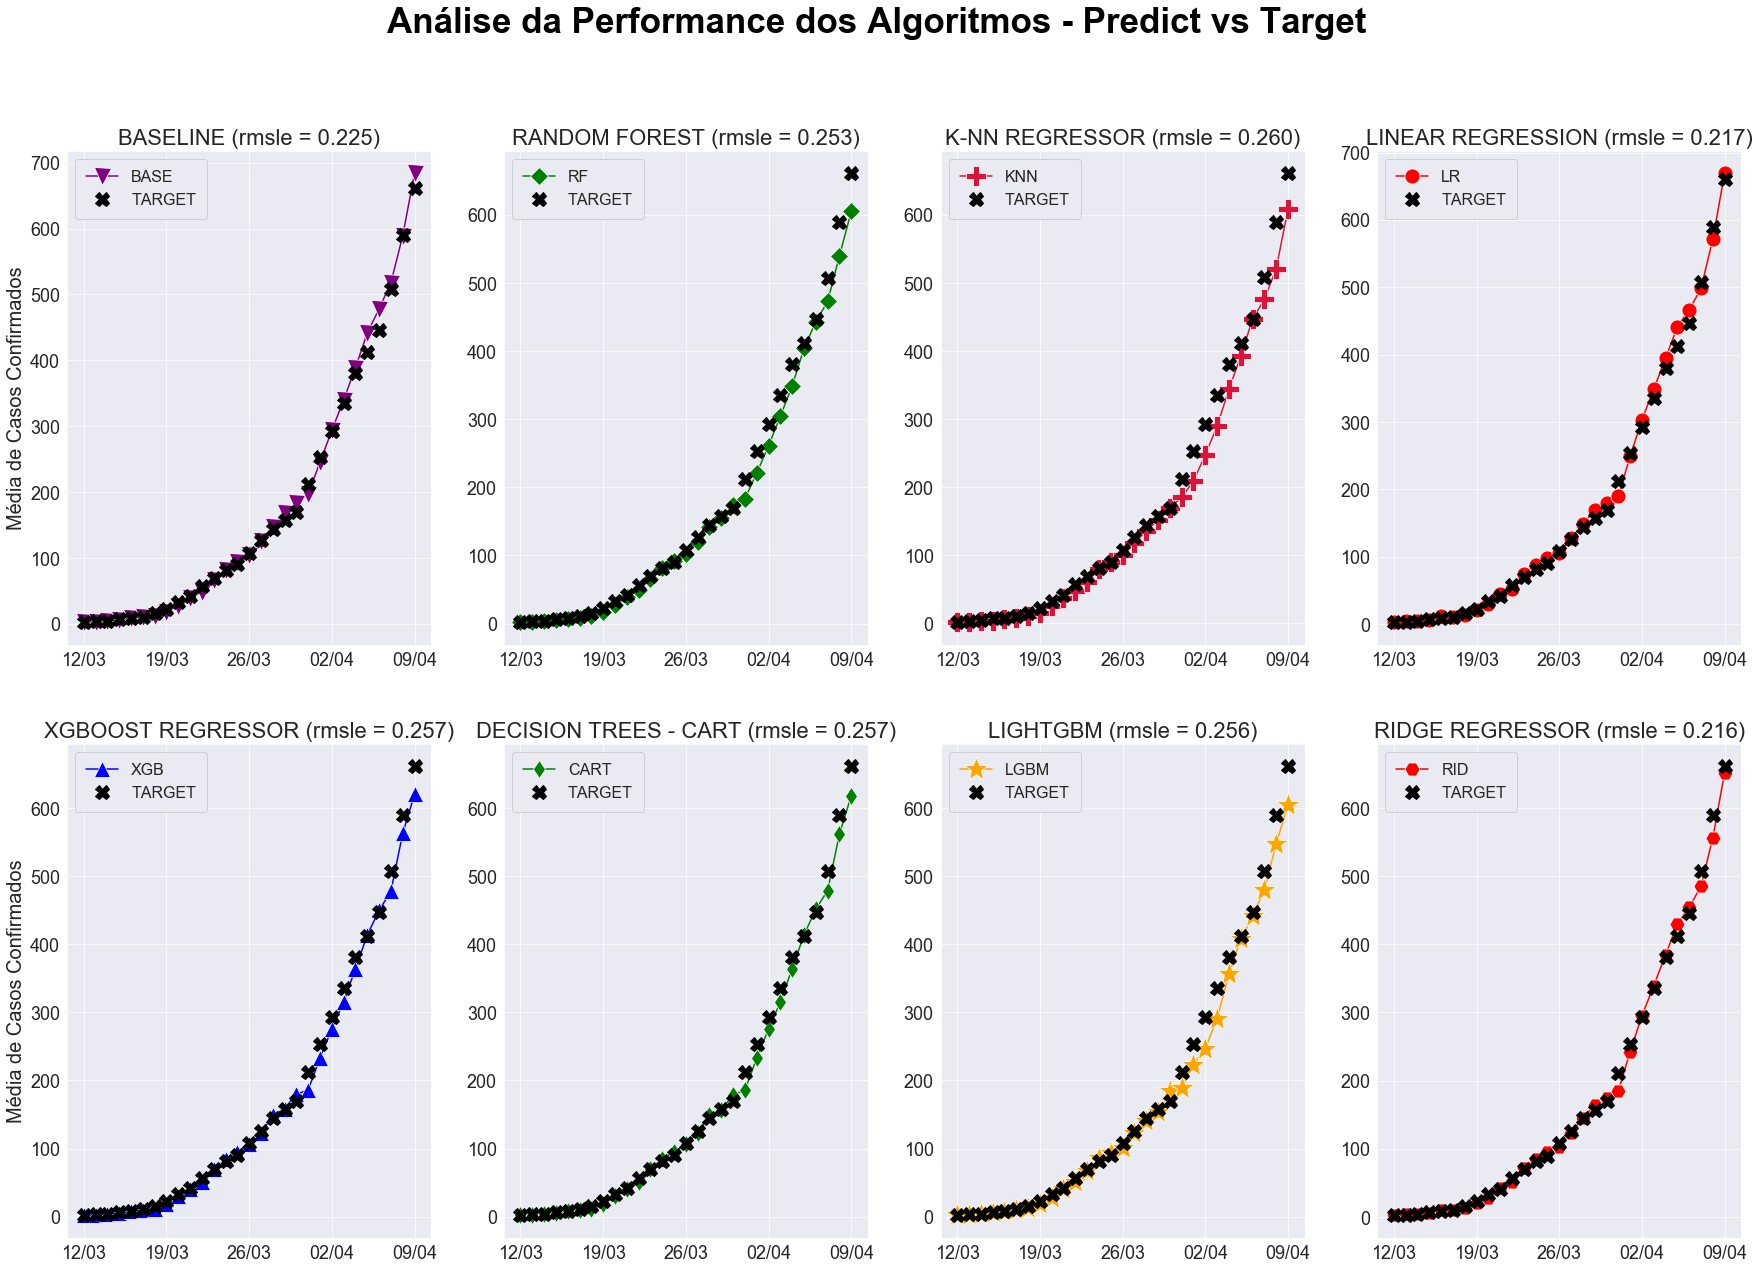

In [47]:
nrows , ncols = 2 , 4
fig , ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(30,20))
fig.suptitle("Análise da Performance dos Algoritmos - Predict vs Target",fontsize=35,y=0.98,color="black",weight='bold')

#Definindo tamanho das fontes
sizelabel , sizetick , sizetit = 20 , 18 , 22

#Personalizando o formato da data mostrada nos ticks
dateview=[pd.to_datetime(an_lr.date)[x].strftime("%d/%m") for x in range(0,len(an_lr.date))]

sns.set_style("darkgrid")

sns.lineplot(x=an_base.date,y=an_base.predict_BASE,color="purple",marker='v',markersize=17,ax=ax[0,0],label='BASE')
ax[0,0].set_title('BASELINE (rmsle = {:.3f})'.format(np.mean(er2_base).values[0]),fontsize=sizetit)
sns.lineplot(x=an_rf.date,y=an_rf.predict_RF,color="green",marker='D',markersize=13,ax=ax[0,1],label='RF')
ax[0,1].set_title('RANDOM FOREST (rmsle = {:.3f})'.format(np.mean(er2_rf).values[0]),fontsize=sizetit)
sns.lineplot(x=an_knn.date,y=an_knn.predict_KNN,color="crimson",marker='P',markersize=20,ax=ax[0,2],label='KNN')
ax[0,2].set_title('K-NN REGRESSOR (rmsle = {:.3f})'.format(np.mean(er2_knn).values[0]),fontsize=sizetit)
sns.lineplot(x=an_lr.date,y=an_lr.predict_LR,color="red",marker='o',markersize=15,ax=ax[0,3],label='LR')
ax[0,3].set_title('LINEAR REGRESSION (rmsle = {:.3f})'.format(np.mean(er2_lr).values[0]),fontsize=sizetit)

sns.lineplot(x=an_xgb.date,y=an_xgb.predict_XGB,color="blue",marker='^',markersize=16,ax=ax[1,0],label='XGB')
ax[1,0].set_title('XGBOOST REGRESSOR (rmsle = {:.3f})'.format(np.mean(er2_xgb).values[0]),fontsize=sizetit)
sns.lineplot(x=an_cart.date,y=an_cart.predict_CART,color="green",marker='d',markersize=13,ax=ax[1,1],label='CART')
ax[1,1].set_title('DECISION TREES - CART (rmsle = {:.3f})'.format(np.mean(er2_cart).values[0]),fontsize=sizetit)
sns.lineplot(x=an_lgbm.date,y=an_lgbm.predict_LGBM,color="orange",marker='*',markersize=25,ax=ax[1,2],label='LGBM')
ax[1,2].set_title('LIGHTGBM (rmsle = {:.3f})'.format(np.mean(er2_lgbm).values[0]),fontsize=sizetit)
sns.lineplot(x=an_rid.date,y=an_rid.predict_RID,color="red",marker='H',markersize=15,ax=ax[1,3],label='RID')
ax[1,3].set_title('RIDGE REGRESSOR (rmsle = {:.3f})'.format(np.mean(er2_rid).values[0]),fontsize=sizetit)

for i in range(0,nrows):
    for j in range(0,ncols):
        ax[i,j].plot(an_lr.date,an_lr.target,color="black",marker='X',label='TARGET',alpha=1,linestyle='none',markersize=14)
        ax[i,j].set_ylabel('Média de Casos Confirmados',fontsize=sizelabel) if((i==0 and j==0) or (j==0 and i==1)) else ax[i,j].set_ylabel('',fontsize=sizelabel)
        ax[i,j].set_xlabel('',fontsize=sizelabel)
        ax[i,j].tick_params(axis='x',labelsize=sizetick,rotation=0)
        ax[i,j].tick_params(axis='y',labelsize=sizetick)
        ax[i,j].set_xticks(an_lr.date[::-7])
        ax[i,j].set_xticklabels(dateview[::-7])
        ax[i,j].legend(ncol=1,fontsize=16,loc="upper left",frameon=True,framealpha=0.90,borderpad = 0.7)

plt.show()

## É evidente que os algoritmos com mais performance é o Ridge Regressor e a Linear Regression, com leve destaque para o Ridge que é uma "evolução" da Linear Regression, onde é incrementado um parâmetro regularizador denominado alpha, em que quanto menor ele é, mais os coeficientes das features insignificativas são penalizadas, aproximando os coeficientes de zero. Logo, um modelo com essa característica será muito últil na fase de seleção de variáveis. Pois, no proceso de feature selection, o modelo irá conceder menos importância a features desnecessárias, diminuindo a magnitude de seus coeficientes.
## Com base nos gráficos concluimos que os demais algoritmos tem dificuldade em ultrapassar ou acompanhar o valor da target, principalmente nos últimos dias, onde o crescimentto do número de casos confirmados é maior. Desta forma, notamos limitações preditivas neles.
## Entretanto, escolher um algoritmo que possui uma abordagem diferente dos modelos lineares pode ser interessante para análise e consequentemente o forecast. Assim sendo, dentre essas opções com menor RMSLE, temos a Random Forest, o LightGBM, o XGBoost e a Decision Trees (CART). Com destaque para o LightGBM, pois obteve uma melhora sensacional no ajuste dos parâmetros e creio que pode obter melhores resultados com features significativas. Por outro lado, graficamente o modelo deixa a desejar na previsão dos últimos dias, ficando bem atrás da target. Deste modo, podemos optar pelo XGboost que dentre os citados é o que melhor consegue se aproximar da target nesse período.
## Entretanto, a escolha dos demais modelos para análise do problema também é válida, uma vez que um dos objetivos é encontrar as features mais relevantes para previsão de novos casos de COVID19 por estado e consequentemente no Brasil.

## Análise Comparativa das Métricas dos Algoritmos

In [48]:
#Definindo subsets para análise
ANL_RMSLE = ANALYTICS.loc[:,['RMSLE_BASE','RMSLE_CART', 'RMSLE_KNN', 'RMSLE_LGBM', 'RMSLE_LR', 'RMSLE_RF','RMSLE_RID', 'RMSLE_XGB']]
ANL_MAPE = ANALYTICS.loc[:,['MAPE_BASE', 'MAPE_CART', 'MAPE_KNN', 'MAPE_LGBM', 'MAPE_LR','MAPE_RF', 'MAPE_RID', 'MAPE_XGB']]

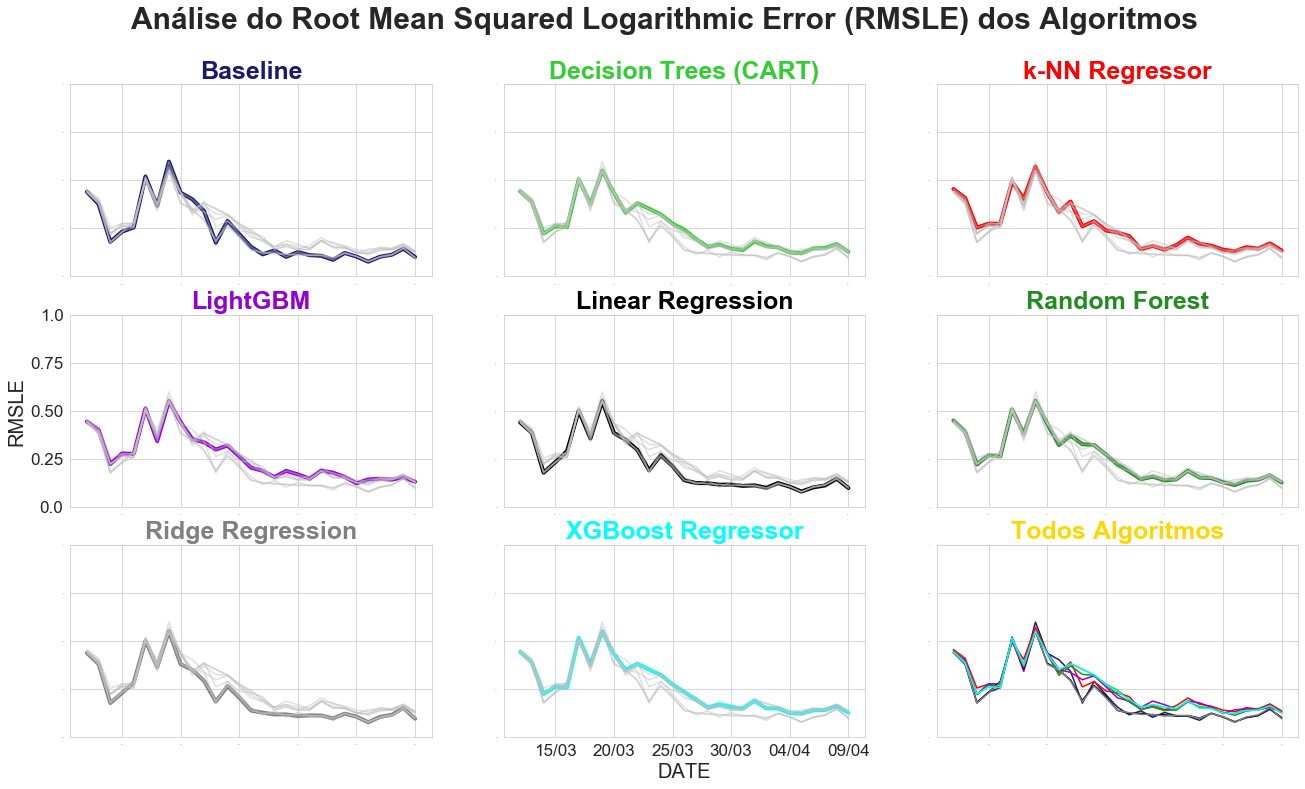

In [51]:
ncols , nrows = 3 , 3
fig , ax = plt.subplots(ncols=ncols, nrows=nrows,figsize=(22,12))
fig.suptitle('Análise do Root Mean Squared Logarithmic Error (RMSLE) dos Algoritmos',fontsize=30,weight='bold',y=0.97)
sns.set_style("whitegrid")

cont=0
names=['Baseline','Decision Trees (CART)','k-NN Regressor','LightGBM','Linear Regression','Random Forest','Ridge Regression','XGBoost Regressor','NULL']
colors=['midnightblue','limegreen','red','darkviolet','black','forestgreen','gray','cyan','gold']
dateview = [ANALYTICS.date[d].strftime("%d/%m") for d in range(0,len(ANALYTICS.date))]

for i in range(0,nrows):
    for j in range(0,ncols):
        if (i==2) and (j==2):
            for num in range(0,8):
                ax[i,j].plot(ANALYTICS.date,ANL_RMSLE.iloc[:,num],color=colors[num])
                ax[i,j].set_title('Todos Algoritmos',fontsize=25,color='gold',weight='bold')
                ax[i,j].set_ylim(0,1)
                ax[i,j].set_ylabel('',fontsize=0)
                ax[i,j].set_yticks([0,0.25,0.5,0.75,1])
                ax[i,j].set_yticklabels(['0.0','0.25','0.50','0.75','1.0'])
                ax[i,j].tick_params(axis='y',labelsize=0)
                ax[i,j].tick_params(axis='x',labelsize=0,rotation=0)
                ax[i,j].set_xticks(ANALYTICS.date[::-5])
                ax[i,j].set_xticklabels(dateview[::-5])
        else:
            ax[i,j].plot(ANALYTICS.date,ANL_RMSLE.iloc[:,cont],color=colors[cont],linewidth=4)
            ax[i,j].set_title(names[cont],fontsize=25,color=colors[cont],weight='bold')
            ax[i,j].set_ylim(0,1)
            ax[i,j].set_ylabel('',fontsize=0)
            ax[i,j].set_yticks([0,0.25,0.5,0.75,1])
            ax[i,j].set_yticklabels(['0.0','0.25','0.50','0.75','1.0'])
            ax[i,j].tick_params(axis='y',labelsize=0)
            ax[i,j].tick_params(axis='x',labelsize=0,rotation=0)
            ax[i,j].set_xticks(ANALYTICS.date[::-5])
            ax[i,j].set_xticklabels(dateview[::-5])
            cont=cont+1
            
            for num in range(0,8):
                ax[i,j].plot(ANALYTICS.date,ANL_RMSLE.iloc[:,num],color='silver',alpha=0.5)
        
        if i==1 and j==0:
            ax[i,j].set_ylabel('RMSLE',fontsize=20)
            
        if i==2 and j==1:
            ax[i,j].set_xlabel('DATE',fontsize=20)
            
        if i==2 and j==1:
            ax[i,j].tick_params(axis='x',labelsize=17,rotation=0)
            
        if j==0 and i==1:
            ax[i,j].tick_params(axis='y',labelsize=17)            

plt.show()

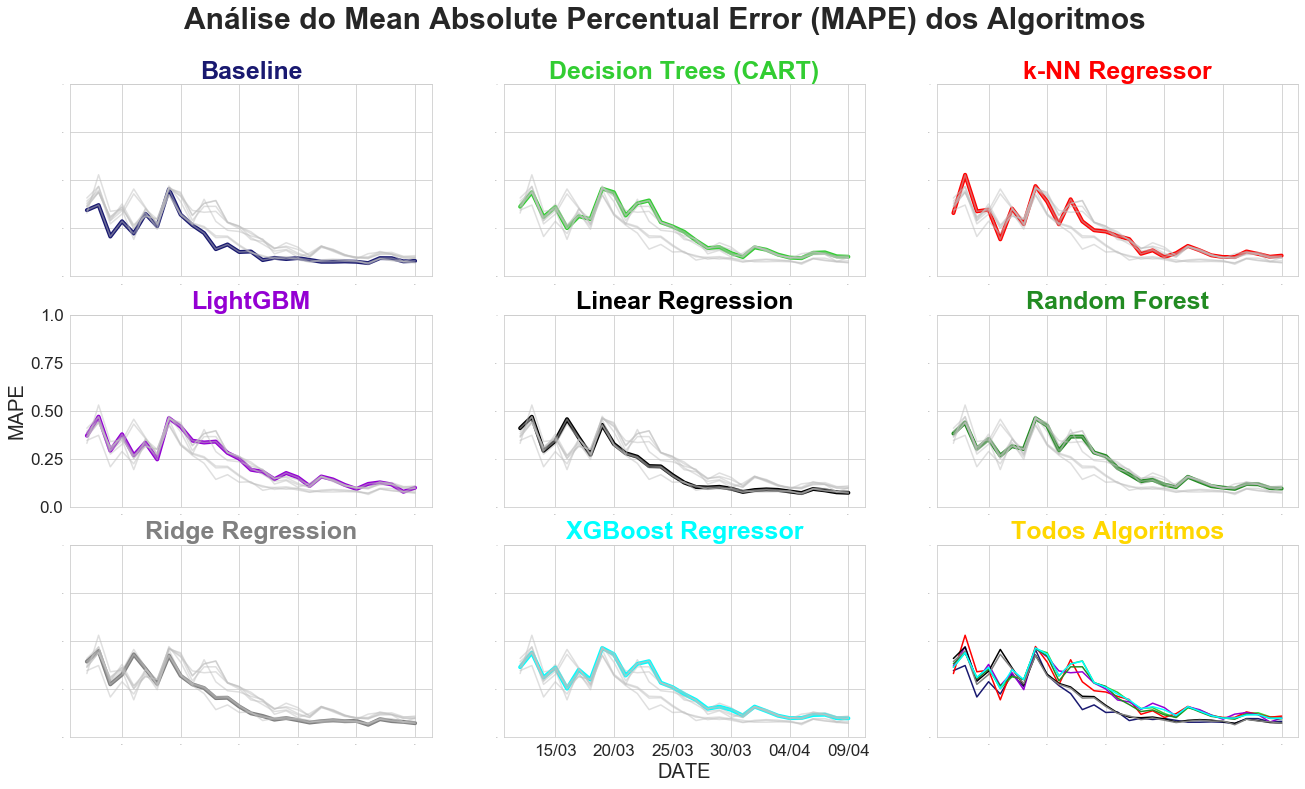

In [52]:
ncols , nrows = 3 , 3
fig , ax = plt.subplots(ncols=ncols, nrows=nrows,figsize=(22,12))
fig.suptitle('Análise do Mean Absolute Percentual Error (MAPE) dos Algoritmos',fontsize=30,weight='bold',y=0.97)
sns.set_style("whitegrid")

cont=0
names=['Baseline','Decision Trees (CART)','k-NN Regressor','LightGBM','Linear Regression','Random Forest','Ridge Regression','XGBoost Regressor','NULL']
colors=['midnightblue','limegreen','red','darkviolet','black','forestgreen','gray','cyan','gold']
dateview = [ANALYTICS.date[d].strftime("%d/%m") for d in range(0,len(ANALYTICS.date))]

for i in range(0,nrows):
    for j in range(0,ncols):
        if (i==2) and (j==2):
            for num in range(0,8):
                ax[i,j].plot(ANALYTICS.date,ANL_MAPE.iloc[:,num],color=colors[num])
                ax[i,j].set_title('Todos Algoritmos',fontsize=25,color='gold',weight='bold')
                ax[i,j].set_ylim(0,1)
                ax[i,j].set_ylabel('',fontsize=0)
                ax[i,j].set_yticks([0,0.25,0.5,0.75,1])
                ax[i,j].set_yticklabels(['0.0','0.25','0.50','0.75','1.0'])
                ax[i,j].tick_params(axis='y',labelsize=0)
                ax[i,j].tick_params(axis='x',labelsize=0,rotation=0)
                ax[i,j].set_xticks(ANALYTICS.date[::-5])
                ax[i,j].set_xticklabels(dateview[::-5])
        else:
            ax[i,j].plot(ANALYTICS.date,ANL_MAPE.iloc[:,cont],color=colors[cont],linewidth=4)
            ax[i,j].set_title(names[cont],fontsize=25,color=colors[cont],weight='bold')
            ax[i,j].set_ylim(0,1)
            ax[i,j].set_ylabel('',fontsize=0)
            ax[i,j].set_yticks([0,0.25,0.5,0.75,1])
            ax[i,j].set_yticklabels(['0.0','0.25','0.50','0.75','1.0'])
            ax[i,j].tick_params(axis='y',labelsize=0)
            ax[i,j].tick_params(axis='x',labelsize=0,rotation=0)
            ax[i,j].set_xticks(ANALYTICS.date[::-5])
            ax[i,j].set_xticklabels(dateview[::-5])
            cont=cont+1
            
            for num in range(0,8):
                ax[i,j].plot(ANALYTICS.date,ANL_MAPE.iloc[:,num],color='silver',alpha=0.5)
        
        if i==1 and j==0:
            ax[i,j].set_ylabel('MAPE',fontsize=20)
            
        if i==2 and j==1:
            ax[i,j].set_xlabel('DATE',fontsize=20)
            
        if i==2 and j==1:
            ax[i,j].tick_params(axis='x',labelsize=17,rotation=0)
            
        if j==0 and i==1:
            ax[i,j].tick_params(axis='y',labelsize=17)            

plt.show()

## Olhando para as duas métricas fica ainda mais evidente a predominância dos modelos lineares de Linear Regression e de Ridge Regressor, principalmente nos últimos dias. Devemos destacar também o desempenho consistente da Baseline. Os demais, obtiveram desempenhos semelhantes e podem ser tratados como um grupo.

## Análise da Distribuição das Métricas dos Algoritmos

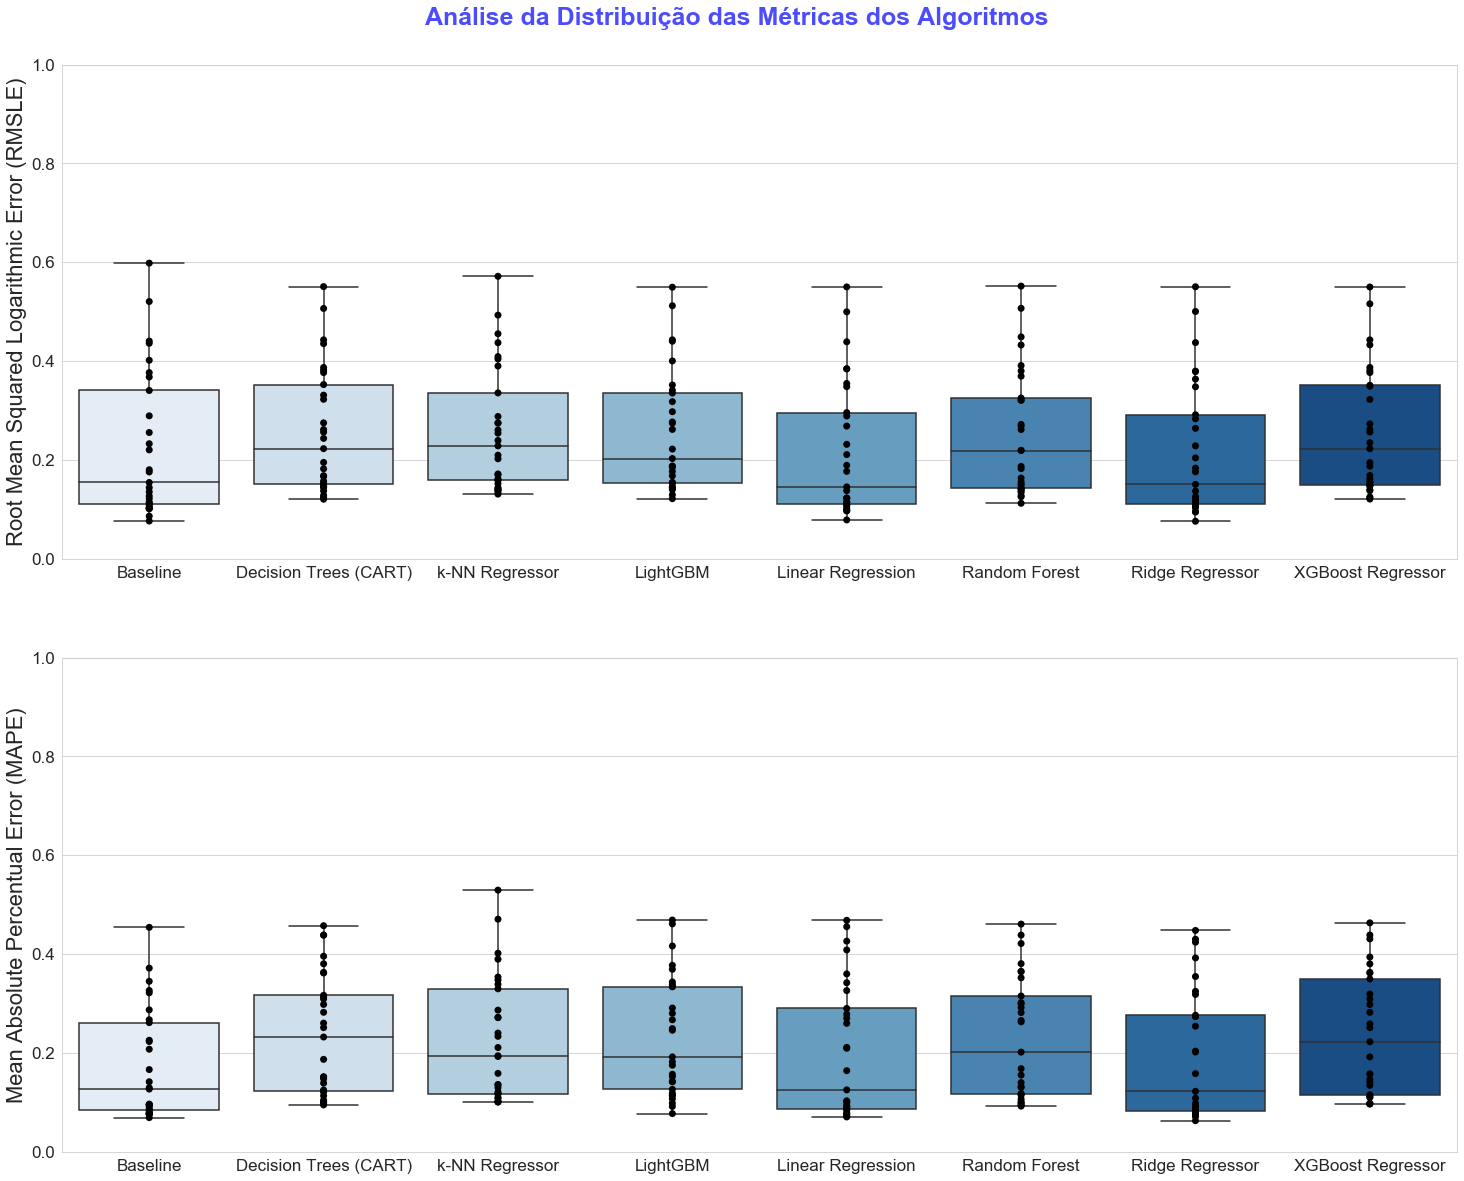

In [53]:
fig , ax = plt.subplots(ncols=1,nrows=2,figsize=(25,20))

fig.suptitle('Análise da Distribuição das Métricas dos Algoritmos',fontsize=25,weight='bold',color='blue',y=0.92,alpha=0.7)

sns.set_style("darkgrid")

sns.boxplot(data=ANL_RMSLE,palette="Blues",ax=ax[0])
sns.stripplot(data=ANL_RMSLE, color="black", jitter=0, size=7,ax=ax[0])
ax[0].set_ylim(0,1)
ax[0].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax[0].set_xticklabels(['Baseline','Decision Trees (CART)','k-NN Regressor','LightGBM','Linear Regression','Random Forest','Ridge Regressor','XGBoost Regressor'])
ax[0].tick_params(axis='y',labelsize=17)
ax[0].tick_params(axis='x',labelsize=17)
ax[0].set_xlabel('',fontsize=22)
ax[0].set_ylabel('Root Mean Squared Logarithmic Error (RMSLE)',fontsize=22)

sns.boxplot(data=ANL_MAPE,palette="Blues",ax=ax[1])
sns.stripplot(data=ANL_MAPE, color="black", jitter=0, size=7,ax=ax[1])
ax[1].set_ylim(0,1)
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax[1].set_xticklabels(['Baseline','Decision Trees (CART)','k-NN Regressor','LightGBM','Linear Regression','Random Forest','Ridge Regressor','XGBoost Regressor'])
ax[1].tick_params(axis='y',labelsize=17)
ax[1].tick_params(axis='x',labelsize=17)
ax[1].set_xlabel('',fontsize=22)
ax[1].set_ylabel('Mean Absolute Percentual Error (MAPE)',fontsize=22)

plt.show()

## Levando em consideração a análise do RMSLE, temos alguns pontos a serem destacados. A Baseline apresenta uma das maiores variações, porém possui juntamente com o Ridge Regressor e a Linear Regression, os menores valores para a Mediana além de apresentaemr a distribuição abaixo da Mediana de forma bem compacta, mostrando a pequena variabilidade para o RMSLE ao longo dos dias. Outro algoritmo que deve ser destacado por essa característica é o LightGBM, porém o único ponto negativo é que ele possui o valor da Mediana um pouco maior que os modelos citados anteriormente. Os demais algoritmos, dispõem de distribuições semelhantes.

## Visualizando Métricas por Estado
## MAPE

In [54]:
#Visualizando o MAPE (%) de cada algoritmo por estado
ms['MEAN_SEM_BASE'] = ms.iloc[:,1:].transpose().mean()
ms['MEAN_ALL'] = ms.transpose().mean()
ms.style.background_gradient(cmap="hot_r",vmin=0,vmax=.5)

## RSLE

In [55]:
#Visualizando o RSLE de cada algoritmo por estado
ms2['MEAN_SEM_BASE'] = ms2.iloc[:,1:].transpose().mean()
ms2['MEAN_ALL'] = ms2.transpose().mean()
ms2.style.background_gradient(cmap="hot_r",vmin=0,vmax=.5)

## Com uma visão mais específica das métricas por estado, abrimos possibilidades para escolher os melhores algoritmos para cada estado, e assim otimizar mais ainda a eficiência da previsão do número total de casos confirmados.

# 

## Agora vamos realizar o Feature Selection com apenas um modelo escolhido (Linear Regression) e posteriormente com todos os modelos.

In [56]:
#Selecionando as features
features = [
       'Densidade', 'area_state', 'Population_2019',
       'Day', 'Semana_do_Ano', 'Dia_do_Ano',
       'Mes', 'Dia', 'Isolamento', 'Dias_de_Isolamento',
       'Cases_Last_Day', 'Diff_Cases_Last_Day', 'Cases_Last_Day_1',
       'Diff_Cases_Last_Day_1', 'Cases_Last_Day_2',
       'Diff_Cases_Last_Day_2', 'Cases_por_Population_Last_Day',
       'Cases_por_Densidade_Last_Day', 'Mean_Cases_Last_Days_3',
       'Desvio_Cases_Last_Days_3', 'Mean_Cases_Last_Days_7',
       'Desvio_Cases_Last_Days_7', 'Mean_Diff_Cases_Last_Days_3',
       'Max_Diff_Cases_Last_Days_3', 'Desvio_Diff_Cases_Last_Days_3',
       'Mean_Diff_Cases_Last_Days_7', 'Max_Diff_Cases_Last_Days_7',
       'Desvio_Diff_Cases_Last_Days_7', 'UF_CAT_AC', 'UF_CAT_AL',
       'UF_CAT_AP', 'UF_CAT_AM', 'UF_CAT_BA', 'UF_CAT_CE', 'UF_CAT_DF',
       'UF_CAT_ES', 'UF_CAT_GO', 'UF_CAT_MA', 'UF_CAT_MT', 'UF_CAT_MS',
       'UF_CAT_MG', 'UF_CAT_PR', 'UF_CAT_PB', 'UF_CAT_PA', 'UF_CAT_PE',
       'UF_CAT_PI', 'UF_CAT_RN', 'UF_CAT_RS', 'UF_CAT_RJ', 'UF_CAT_RO',
       'UF_CAT_RR', 'UF_CAT_SC', 'UF_CAT_SE', 'UF_CAT_SP', 'UF_CAT_TO',
       'REG_CAT_Norte', 'REG_CAT_Nordeste', 'REG_CAT_Centro-Oeste',
       'REG_CAT_Sudeste', 'REG_CAT_Sul', 'DIST_RJ', 'DIST_CE', 'DIST_SP'
            ]

#Quantidade selecionada
len(features)

63

In [130]:
%%time

feat = features.copy()
selection=[]
add = 'yes'
rep = 0
num_sel = 1

while add == 'yes':
    
    feat_sel=pd.DataFrame(columns=['FEAT','MAPE','RMSLE'])
    
    for var in range(0,len(feat)):

        selection.append(feat[var])
        error=[]
        error2=[]
        if var==0:
            add = 'no'

        for i in range(mn,mx+1):
            if date_state[date_state['Day']==i].shape[0] !=0:

                train=date_state[date_state['Day']<i]
                test=date_state[date_state['Day']==i]

                sel=selection
                X_train=train.loc[:,sel].values
                y_train=train['cases'].values
                X_test=test.loc[:,sel].values
                y_test=test['cases'].values

                model=LinearRegression(n_jobs=-1)
                model.fit(X_train,y_train)

                y_pred=model.predict(X_test)

                e = MAPE(y_pred,y_test)
                error.append(e)               
                e2 = RMSLE(y_pred,y_test)
                error2.append(e2)

        if rep==0:
            min_rmsle = np.mean(error2)
            var_min_rmsle = feat[var]
            add = 'yes'
        else:
            if np.mean(error2) < min_rmsle:
                min_rmsle = np.mean(error2)
                var_min_rmsle = feat[var]
                add = 'yes'
    
        att=pd.DataFrame({'FEAT':format(sel[:]),'MAPE':np.mean(error),'RMSLE':np.mean(error2)},index=[0])
        feat_sel=pd.concat([feat_sel,att]).reset_index(level=0,drop=True)
        feat_sel.to_csv('LR_TEST_num_sel_{}.csv'.format(num_sel),sep=';')
        rep=rep+1
        selection=selection[:-1]

    if add == 'yes':
        selection.append(var_min_rmsle)
        feat.remove(var_min_rmsle)
        print("+ {} : {:.4f}\n".format(var_min_rmsle,min_rmsle))
        num_sel = num_sel +1
        
print(selection)
print('\n')

+ Cases_Last_Day : 0.2174

+ UF_CAT_AL : 0.2170

+ UF_CAT_TO : 0.2166

+ UF_CAT_SE : 0.2163

+ DIST_CE : 0.2162

+ UF_CAT_RO : 0.2162

+ Mes : 0.2155

+ UF_CAT_AP : 0.2146

+ UF_CAT_PB : 0.2142

+ UF_CAT_AC : 0.2141

['Cases_Last_Day', 'UF_CAT_AL', 'UF_CAT_TO', 'UF_CAT_SE', 'DIST_CE', 'UF_CAT_RO', 'Mes', 'UF_CAT_AP', 'UF_CAT_PB', 'UF_CAT_AC']


Wall time: 4min 1s


# 

## Forward Feature Selection para todos os modelos

In [174]:
%%time

models=[RandomForestRegressor(n_jobs=-1,random_state=0,n_estimators=125),
        KNeighborsRegressor(n_jobs=-1,n_neighbors=3),
        LinearRegression(n_jobs=-1),
        XGBRegressor(n_jobs=-1,random_state=0,n_estimators=75),
        DecisionTreeRegressor(random_state=0),
        LGBMRegressor(n_jobs=-1,random_state=0,n_estimators=100,learning_rate=0.1,num_leaves = 115,min_child_samples = 1,subsample = 0.4682239281869186,colsample_bytree = 1.0),
        Ridge(random_state=0,alpha=0.03,normalize=True,fit_intercept=True)]

name_mod=['RF','KNN','LR','XGB','CART','LGBM','RID']
fullname_mod=['Random Forest','k-NN Regressor','Linear Regression','XGBoost Regressor','Decision Trees - CART','LightGBM','Ridge Regressor']

mn=43
mx=71

for num in range(0,len(models)):
    
    print("\nForward Feature Selection com {}\n".format(fullname_mod[num]))

    feat = features.copy() #devem ser colocadas dentro do loop dos modelos pq algumas variáveis são excluídas da lista durante o processo de feature selection
    selection=[]
    add = 'yes'
    rep = 0
    num_sel = 1
    error=[]
    error2=[]   
    
    while add == 'yes':

        feat_sel=pd.DataFrame(columns=['FEAT','MAPE','RMSLE'])

        for var in range(0,len(feat)):

            selection.append(feat[var])
            error=[]
            error2=[]
            if var==0:
                add = 'no'

            for i in range(mn,mx+1):
                if date_state[date_state['Day']==i].shape[0] !=0:

                    train=date_state[date_state['Day']<i]
                    test=date_state[date_state['Day']==i]

                    sel=selection
                    X_train=train.loc[:,sel].values
                    y_train=train['cases'].values
                    X_test=test.loc[:,sel].values
                    y_test=test['cases'].values

                    model=models[num]
                    model.fit(X_train,y_train)

                    y_pred=model.predict(X_test)                  

                    e = MAPE(y_pred,y_test)
                    error.append(e)               
                    e2 = RMSLE(y_pred,y_test)
                    error2.append(e2)
                    

            if rep==0:
                min_rmsle = np.mean(error2)
                var_min_rmsle = feat[var]
                add = 'yes'
            else:
                if np.mean(error2) < min_rmsle:
                    min_rmsle = np.mean(error2)
                    var_min_rmsle = feat[var]
                    add = 'yes'

            att=pd.DataFrame({'FEAT':format(sel[:]),'MAPE':np.mean(error),'RMSLE':np.mean(error2)},index=[0])
            feat_sel=pd.concat([feat_sel,att]).reset_index(level=0,drop=True)
            feat_sel.to_csv('{}_num_sel_{}.csv'.format(name_mod[num],num_sel),sep=';')
            rep=rep+1
            selection=selection[:-1]

        if add == 'yes':
            selection.append(var_min_rmsle)
            feat.remove(var_min_rmsle)
            print("+ {} : {:.4f}".format(var_min_rmsle,min_rmsle))
            num_sel = num_sel +1
            
        if len(feat) == 0:
            add = 'no'

    print(selection)


Forward Feature Selection com Random Forest

+ Cases_Last_Day : 0.2529
+ Semana_do_Ano : 0.2455
+ Cases_Last_Day_1 : 0.2404
+ REG_CAT_Sul : 0.2373
+ Mean_Diff_Cases_Last_Days_7 : 0.2352
+ UF_CAT_PE : 0.2329
+ UF_CAT_MG : 0.2328
+ UF_CAT_DF : 0.2320
+ Mean_Cases_Last_Days_3 : 0.2320
+ UF_CAT_AM : 0.2315
+ UF_CAT_SE : 0.2304
+ UF_CAT_GO : 0.2302
+ UF_CAT_BA : 0.2301
+ UF_CAT_SP : 0.2300
+ UF_CAT_MT : 0.2298
['Cases_Last_Day', 'Semana_do_Ano', 'Cases_Last_Day_1', 'REG_CAT_Sul', 'Mean_Diff_Cases_Last_Days_7', 'UF_CAT_PE', 'UF_CAT_MG', 'UF_CAT_DF', 'Mean_Cases_Last_Days_3', 'UF_CAT_AM', 'UF_CAT_SE', 'UF_CAT_GO', 'UF_CAT_BA', 'UF_CAT_SP', 'UF_CAT_MT']

Forward Feature Selection com k-NN Regressor

+ Cases_Last_Day : 0.2596
+ Max_Diff_Cases_Last_Days_3 : 0.2506
+ Dias_de_Isolamento : 0.2443
+ REG_CAT_Sul : 0.2435
+ Desvio_Cases_Last_Days_7 : 0.2426
+ UF_CAT_AM : 0.2418
+ Mean_Diff_Cases_Last_Days_7 : 0.2414
+ UF_CAT_TO : 0.2413
+ UF_CAT_PA : 0.2411
+ Cases_por_Population_Last_Day : 0.2410
+ 

## Com as seleções feitas podemos perceber melhoras bem significativas no desempenho dos modelos, principalmente na Random Forest, k-NN e XGBoost. Outro ponto a ser destacado é a escolha em comum por parte dos algoritmos de algumas variáveis específicas, 'Cases_Last_Day' é evidente que seria unânime uma vez que possui relação direta com o total de casos confirmados do dia seguinte. Variáveis como: 'Semana_do_Ano', 'Mes', 'REG_CAT_Sul', 'UF_CAT_AM' e 'UF_CAT_TO' são frequentemente selecionadas.

# 

## Treinando os modelos com os tunnings e suas respectivas novas features

In [64]:
models=[RandomForestRegressor(n_jobs=-1,random_state=0,n_estimators=125),
        KNeighborsRegressor(n_jobs=-1,n_neighbors=3),
        LinearRegression(n_jobs=-1),
        XGBRegressor(n_jobs=-1,random_state=0,n_estimators=75),
        DecisionTreeRegressor(random_state=0),
        LGBMRegressor(n_jobs=-1,random_state=0,n_estimators=100,learning_rate=0.1,num_leaves = 115,min_child_samples = 1,subsample = 0.4682239281869186,colsample_bytree = 1.0),
        Ridge(random_state=0,alpha=0.03,normalize=True,fit_intercept=True)]

name_mod=['RF','KNN','LR','XGB','CART','LGBM','RID']

feat_mod = [['Cases_Last_Day', 'Semana_do_Ano', 'Cases_Last_Day_1', 'REG_CAT_Sul', 'Mean_Diff_Cases_Last_Days_7', 'UF_CAT_PE',
             'UF_CAT_MG', 'UF_CAT_DF', 'Mean_Cases_Last_Days_3', 'UF_CAT_AM', 'UF_CAT_SE', 'UF_CAT_GO', 'UF_CAT_BA', 'UF_CAT_SP', 'UF_CAT_MT'],
            ['Cases_Last_Day', 'Max_Diff_Cases_Last_Days_3', 'Dias_de_Isolamento', 'REG_CAT_Sul', 'Desvio_Cases_Last_Days_7',
             'UF_CAT_AM', 'Mean_Diff_Cases_Last_Days_7', 'UF_CAT_TO', 'UF_CAT_PA', 'Cases_por_Population_Last_Day', 'UF_CAT_PR'],
            ['Cases_Last_Day', 'UF_CAT_AL', 'UF_CAT_TO', 'UF_CAT_SE', 'DIST_CE', 'UF_CAT_RO', 'Mes', 'UF_CAT_AP', 'UF_CAT_PB', 'UF_CAT_AC'],
            ['Cases_Last_Day', 'Semana_do_Ano', 'Diff_Cases_Last_Day', 'REG_CAT_Sul', 'Desvio_Diff_Cases_Last_Days_7', 'Mean_Cases_Last_Days_7', 'Mes'],
            ['Cases_Last_Day', 'Semana_do_Ano', 'UF_CAT_DF', 'UF_CAT_RN'],
            ['Cases_Last_Day', 'UF_CAT_CE'],
            ['Cases_Last_Day', 'UF_CAT_TO', 'UF_CAT_AL', 'UF_CAT_SE', 'UF_CAT_RO', 'UF_CAT_MS', 'UF_CAT_AC', 'REG_CAT_Sul', 'UF_CAT_PI', 'UF_CAT_GO']]

#Criando dataframe para análise da performance do modelo
analytics=pd.DataFrame(columns=['date','Day','target','predict','MAPE','RMSE','RMSLE'])

for num in range(0,len(models)):
    
    error=[]
    error2=[]
    analytics=pd.DataFrame(columns=['date','Day','target','predict_{}'.format(name_mod[num]),'MAPE_{}'.format(name_mod[num]),'RMSE_{}'.format(name_mod[num]),'RMSLE_{}'.format(name_mod[num])])
    
    for i in range(mn,mx+1):
        if date_state[date_state['Day']==i].shape[0] !=0:

            train=date_state[date_state['Day']<i]
            test=date_state[date_state['Day']==i]

            sel=feat_mod[num]
            X_train=train.loc[:,sel].values
            y_train=train['cases'].values
            X_test=test.loc[:,sel].values
            y_test=test['cases'].values

            model=models[num]
            model.fit(X_train,y_train)

            y_pred=model.predict(X_test)

            y_state=test['state'].values
            aux=MAPE_STATE(y_pred,y_test,y_state)
            aux=aux.set_index(aux.state).drop(columns='state')
            if(i==mn):
                m=aux
            else:
                m=m.merge(aux,how='outer',on='state')
                
            aux2=RSLE_STATE(y_pred,y_test,y_state)
            aux2=aux2.set_index(aux2.state).drop(columns='state')
            if(i==mn):
                m2=aux2
            else:
                m2=m2.merge(aux2,how='outer',on='state')                          
                
            e = MAPE(y_pred,y_test)
            error.append(e)
            e2 = RMSLE(y_pred,y_test)
            error2.append(e2)              

            #Guardando predicts, targets e outras informações para análise do desempenho do modelo
            att=pd.DataFrame({'date':test.date.max(),'Day':test.Day.max(),'target':y_test.mean(),'predict_{}'.format(name_mod[num]):y_pred.mean(),
                              'MAPE_{}'.format(name_mod[num]):MAPE(y_pred,y_test),'RMSLE_{}'.format(name_mod[num]):RMSLE(y_pred,y_test),'RMSE_{}'.format(name_mod[num]):RMSE(y_pred,y_test)},index=[0])

            #Atualizando dataframe de análise
            analytics=pd.concat([analytics,att]).reset_index(drop=True,level=0)        

    #Imprimir mensagem para cada algorimo mostrando os scores
    msg=print("\n{}\nMédia do Erro MAPE: {:.4f}%\nMédia do Erro RMSLE: {:.4f}".format(name_mod[num],np.mean(error)*100,np.mean(error2)))
    
    #Salvando o modelo
    joblib.dump(model,'model_{}.pkl'.format(name_mod[num]))
    
    if name_mod[num] == 'RF':
        er_rf=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_rf=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_rf=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_rf],axis=1);
        m2_rf=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_rf],axis=1);
        an_rf=analytics; ANALYTICS=ANALYTICS.merge(an_rf.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'KNN':
        er_knn=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_knn=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_knn=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_knn],axis=1);
        m2_knn=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_knn],axis=1);
        an_knn=analytics; ANALYTICS=ANALYTICS.merge(an_knn.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'LR':
        er_lr=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_lr=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_lr=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_lr],axis=1);
        m2_lr=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_lr],axis=1);
        an_lr=analytics; ANALYTICS=ANALYTICS.merge(an_lr.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'XGB':
        er_xgb=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_xgb=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_xgb=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_xgb],axis=1);
        m2_xgb=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_xgb],axis=1);
        an_xgb=analytics; ANALYTICS=ANALYTICS.merge(an_xgb.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'CART':
        er_cart=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_cart=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_cart=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_cart],axis=1);
        m2_cart=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_cart],axis=1);
        an_cart=analytics; ANALYTICS=ANALYTICS.merge(an_cart.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'LGBM':
        er_lgbm=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_lgbm=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_lgbm=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_lgbm],axis=1);
        m2_lgbm=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_lgbm],axis=1);
        an_lgbm=analytics; ANALYTICS=ANALYTICS.merge(an_lgbm.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
    elif name_mod[num] == 'RID':
        er_rid=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_rid=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_rid=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); ms=pd.concat([ms,m_rid],axis=1);
        m2_rid=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); ms2=pd.concat([ms2,m2_rid],axis=1);
        an_rid=analytics; ANALYTICS=ANALYTICS.merge(an_rid.iloc[:,[1,3,4,5,6]],how='left',on='Day'); msg;
        
#Detalhe: sempre que for usado o dataframe ANALYTICS para avaliar a performance, a Baseline deve ser treinada novamente, para reiniciar o dataframe.


RF
Média do Erro MAPE: 19.1786%
Média do Erro RMSLE: 0.2298

KNN
Média do Erro MAPE: 20.5064%
Média do Erro RMSLE: 0.2410

LR
Média do Erro MAPE: 20.3244%
Média do Erro RMSLE: 0.2141

XGB
Média do Erro MAPE: 20.2562%
Média do Erro RMSLE: 0.2343

CART
Média do Erro MAPE: 22.0785%
Média do Erro RMSLE: 0.2518

LGBM
Média do Erro MAPE: 23.2174%
Média do Erro RMSLE: 0.2549

RID
Média do Erro MAPE: 19.1388%
Média do Erro RMSLE: 0.2138


## Com todo esse processo realizado obtivemos bastante melhora nos scores dos algoritmos, sendo que alguns melhoraram mais com os tunnings (LGBM), outros melhoraram com as novas features (RF e XGB), outros se otimizaram equilibradamente com os dois processos (KNN e CART) e finalmente os últimos dois se apresentaram mais eficazes desde o início com os tipos de dados apresentado e não melhoram tanto com esses processos (LR e RID).
## Contudo, apenas Ridge Regressor e a Linear Regression superaram a Baseline (RMSLE = 0.2252) apresentando RMSLE de 0.2138 e 0.2141, respectivamente. Devemos também destacar a ótima aproximação da Random Forest para a Baseline, ficando atrás por menos de meio centésimo (0.0046).

## Análise gráfica do treino e validação dos algoritmos

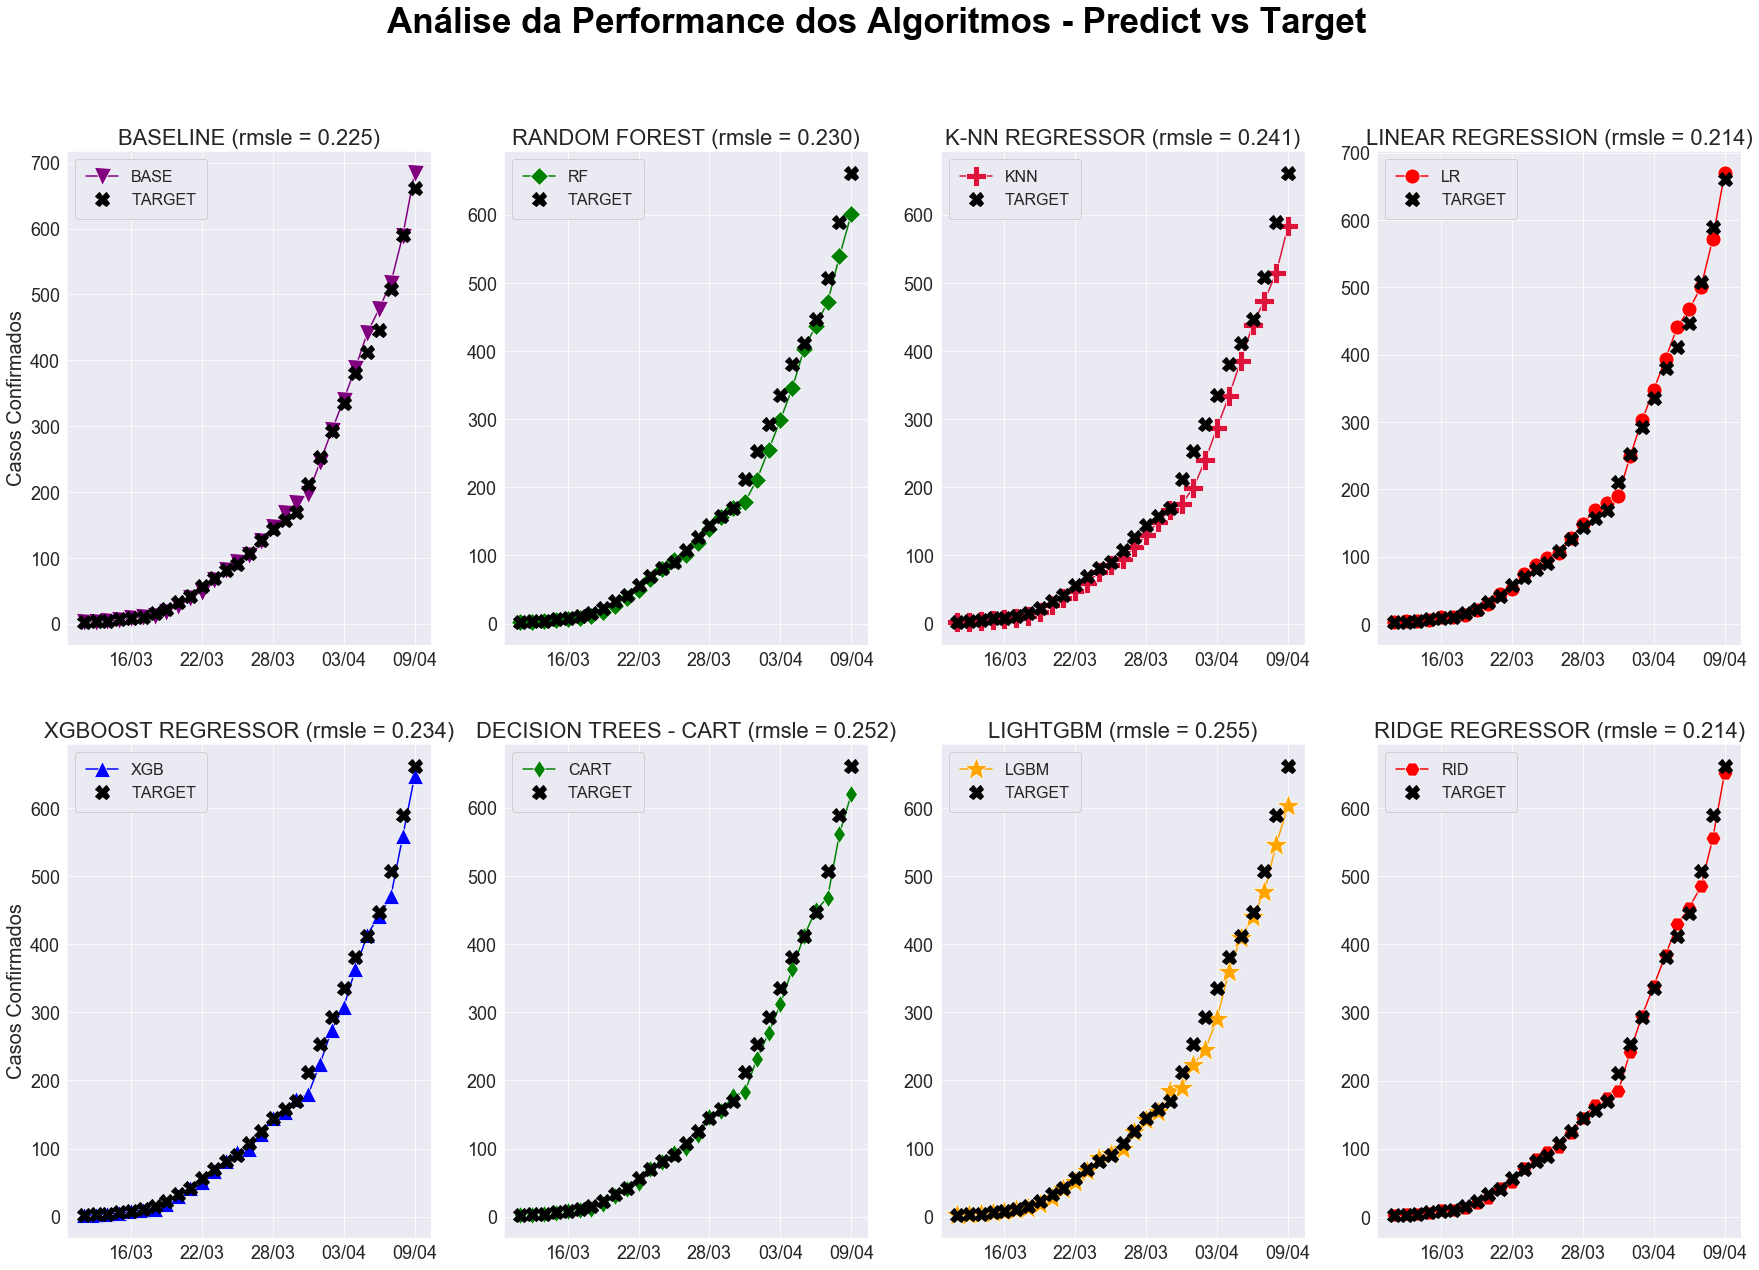

In [65]:
nrows , ncols = 2 , 4
fig , ax = plt.subplots(ncols=ncols,nrows=nrows,figsize=(30,20))
fig.suptitle("Análise da Performance dos Algoritmos - Predict vs Target",fontsize=35,y=0.98,color="black",weight='bold')

#Definindo tamanho das fontes
sizelabel , sizetick , sizetit = 20 , 18 , 22

#Personalizando o formato da data mostrada nos ticks
dateview=[pd.to_datetime(an_lr.date)[x].strftime("%d/%m") for x in range(0,len(an_lr.date))]

sns.set_style("darkgrid")

sns.lineplot(x=an_base.date,y=an_base.predict_BASE,color="purple",marker='v',markersize=17,ax=ax[0,0],label='BASE')
ax[0,0].set_title('BASELINE (rmsle = {:.3f})'.format(np.mean(er2_base).values[0]),fontsize=sizetit)
sns.lineplot(x=an_rf.date,y=an_rf.predict_RF,color="green",marker='D',markersize=13,ax=ax[0,1],label='RF')
ax[0,1].set_title('RANDOM FOREST (rmsle = {:.3f})'.format(np.mean(er2_rf).values[0]),fontsize=sizetit)
sns.lineplot(x=an_knn.date,y=an_knn.predict_KNN,color="crimson",marker='P',markersize=20,ax=ax[0,2],label='KNN')
ax[0,2].set_title('K-NN REGRESSOR (rmsle = {:.3f})'.format(np.mean(er2_knn).values[0]),fontsize=sizetit)
sns.lineplot(x=an_lr.date,y=an_lr.predict_LR,color="red",marker='o',markersize=15,ax=ax[0,3],label='LR')
ax[0,3].set_title('LINEAR REGRESSION (rmsle = {:.3f})'.format(np.mean(er2_lr).values[0]),fontsize=sizetit)

sns.lineplot(x=an_xgb.date,y=an_xgb.predict_XGB,color="blue",marker='^',markersize=16,ax=ax[1,0],label='XGB')
ax[1,0].set_title('XGBOOST REGRESSOR (rmsle = {:.3f})'.format(np.mean(er2_xgb).values[0]),fontsize=sizetit)
sns.lineplot(x=an_cart.date,y=an_cart.predict_CART,color="green",marker='d',markersize=13,ax=ax[1,1],label='CART')
ax[1,1].set_title('DECISION TREES - CART (rmsle = {:.3f})'.format(np.mean(er2_cart).values[0]),fontsize=sizetit)
sns.lineplot(x=an_lgbm.date,y=an_lgbm.predict_LGBM,color="orange",marker='*',markersize=25,ax=ax[1,2],label='LGBM')
ax[1,2].set_title('LIGHTGBM (rmsle = {:.3f})'.format(np.mean(er2_lgbm).values[0]),fontsize=sizetit)
sns.lineplot(x=an_rid.date,y=an_rid.predict_RID,color="red",marker='H',markersize=15,ax=ax[1,3],label='RID')
ax[1,3].set_title('RIDGE REGRESSOR (rmsle = {:.3f})'.format(np.mean(er2_rid).values[0]),fontsize=sizetit)

for i in range(0,nrows):
    for j in range(0,ncols):
        #sns.lineplot(x=an_lr.date,y=an_lr.target,color="black",marker='X',markersize=17,ax=ax[i,j],label='TARGET',alpha=1)
        ax[i,j].plot(an_lr.date,an_lr.target,color="black",marker='X',label='TARGET',alpha=1,linestyle='none',markersize=14)
        #EM VEZ DE USAR O LINEPLOT PARA A TARGET USAR APENAS O SCATTER PLOT
        ax[i,j].set_ylabel('Casos Confirmados',fontsize=sizelabel) if((i==0 and j==0) or (j==0 and i==1)) else ax[i,j].set_ylabel('',fontsize=sizelabel)
        ax[i,j].set_xlabel('',fontsize=sizelabel)
        ax[i,j].tick_params(axis='x',labelsize=sizetick,rotation=0)
        ax[i,j].tick_params(axis='y',labelsize=sizetick)
        ax[i,j].set_xticks(an_lr.date[::-6])
        ax[i,j].set_xticklabels(dateview[::-6])
        ax[i,j].legend(ncol=1,fontsize=16,loc="upper left",frameon=True,framealpha=0.90,borderpad = 0.7)

plt.show()

## Comparando com a análise feita apenas com os tunnings anteriormente, temos que a adição das features ajudou bastante os algoritmos a acompanhar a target, principalmente o XGBoost Regressor. Alguns algoritmos como LightGBM, Linear Regression e Ridge Regressor não obtiveram melhora significativa.

## Análise Comparativa das Métricas dos Algoritmos

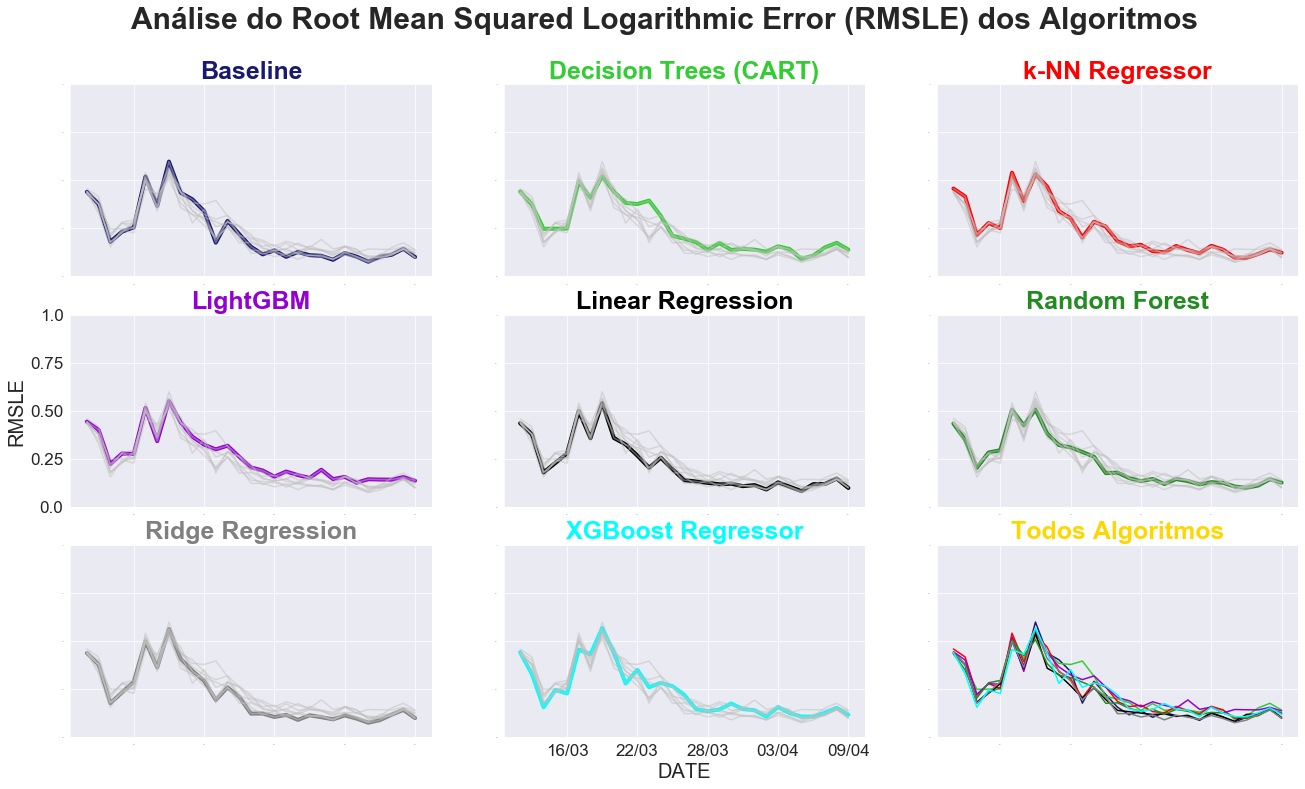

In [66]:
ANL_RMSLE = ANALYTICS.loc[:,['RMSLE_BASE','RMSLE_CART', 'RMSLE_KNN', 'RMSLE_LGBM', 'RMSLE_LR', 'RMSLE_RF','RMSLE_RID', 'RMSLE_XGB']]
ANL_MAPE = ANALYTICS.loc[:,['MAPE_BASE', 'MAPE_CART', 'MAPE_KNN', 'MAPE_LGBM', 'MAPE_LR','MAPE_RF', 'MAPE_RID', 'MAPE_XGB']]

ncols , nrows = 3 , 3
fig , ax = plt.subplots(ncols=ncols, nrows=nrows,figsize=(22,12))
fig.suptitle('Análise do Root Mean Squared Logarithmic Error (RMSLE) dos Algoritmos',fontsize=30,weight='bold',y=0.97)
sns.set_style("whitegrid")

cont=0
names=['Baseline','Decision Trees (CART)','k-NN Regressor','LightGBM','Linear Regression','Random Forest','Ridge Regression','XGBoost Regressor','NULL']
colors=['midnightblue','limegreen','red','darkviolet','black','forestgreen','gray','cyan','gold']
dateview = [ANALYTICS.date[d].strftime("%d/%m") for d in range(0,len(ANALYTICS.date))]

for i in range(0,nrows):
    for j in range(0,ncols):
        if (i==2) and (j==2):
            for num in range(0,8):
                ax[i,j].plot(ANALYTICS.date,ANL_RMSLE.iloc[:,num],color=colors[num])
                ax[i,j].set_title('Todos Algoritmos',fontsize=25,color='gold',weight='bold')
                ax[i,j].set_ylim(0,1)
                ax[i,j].set_ylabel('',fontsize=0)
                ax[i,j].set_yticks([0,0.25,0.5,0.75,1])
                ax[i,j].set_yticklabels(['0.0','0.25','0.50','0.75','1.0'])
                ax[i,j].tick_params(axis='y',labelsize=0)
                ax[i,j].tick_params(axis='x',labelsize=0,rotation=0)
                ax[i,j].set_xticks(ANALYTICS.date[::-6])
                ax[i,j].set_xticklabels(dateview[::-6])
        else:
            ax[i,j].plot(ANALYTICS.date,ANL_RMSLE.iloc[:,cont],color=colors[cont],linewidth=4)
            ax[i,j].set_title(names[cont],fontsize=25,color=colors[cont],weight='bold')
            ax[i,j].set_ylim(0,1)
            ax[i,j].set_ylabel('',fontsize=0)
            ax[i,j].set_yticks([0,0.25,0.5,0.75,1])
            ax[i,j].set_yticklabels(['0.0','0.25','0.50','0.75','1.0'])
            ax[i,j].tick_params(axis='y',labelsize=0)
            ax[i,j].tick_params(axis='x',labelsize=0,rotation=0)
            ax[i,j].set_xticks(ANALYTICS.date[::-6])
            ax[i,j].set_xticklabels(dateview[::-6])
            cont=cont+1
            
            for num in range(0,8):
                ax[i,j].plot(ANALYTICS.date,ANL_RMSLE.iloc[:,num],color='silver',alpha=0.5)
        
        if i==1 and j==0:
            ax[i,j].set_ylabel('RMSLE',fontsize=20)
            
        if i==2 and j==1:
            ax[i,j].set_xlabel('DATE',fontsize=20)
            
        if i==2 and j==1:
            ax[i,j].tick_params(axis='x',labelsize=17,rotation=0)
            
        if j==0 and i==1:
            ax[i,j].tick_params(axis='y',labelsize=17)            

plt.show()

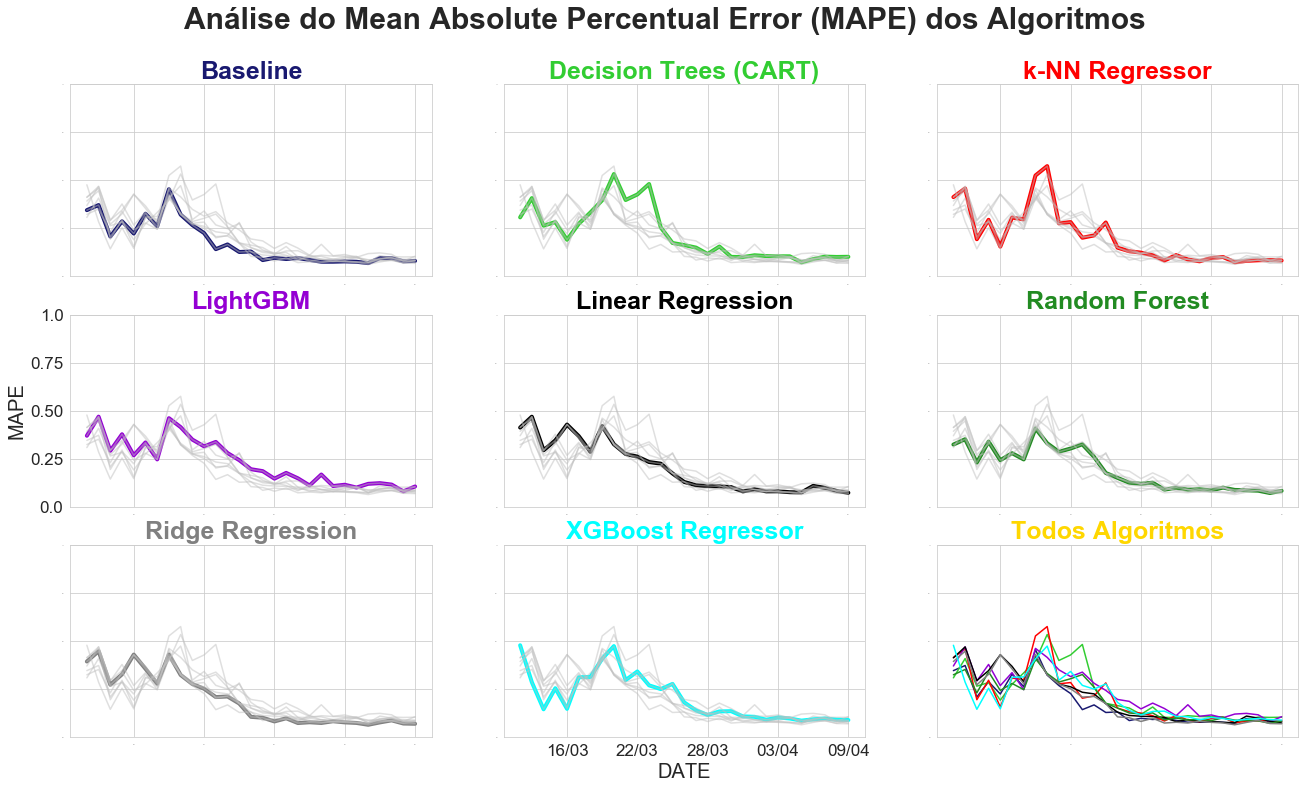

In [67]:
ncols , nrows = 3 , 3
fig , ax = plt.subplots(ncols=ncols, nrows=nrows,figsize=(22,12))
fig.suptitle('Análise do Mean Absolute Percentual Error (MAPE) dos Algoritmos',fontsize=30,weight='bold',y=0.97)
sns.set_style("whitegrid")

cont=0
names=['Baseline','Decision Trees (CART)','k-NN Regressor','LightGBM','Linear Regression','Random Forest','Ridge Regression','XGBoost Regressor','NULL']
colors=colors=['midnightblue','limegreen','red','darkviolet','black','forestgreen','gray','cyan','gold']
dateview = [ANALYTICS.date[d].strftime("%d/%m") for d in range(0,len(ANALYTICS.date))]

for i in range(0,nrows):
    for j in range(0,ncols):
        if (i==2) and (j==2):
            for num in range(0,8):
                ax[i,j].plot(ANALYTICS.date,ANL_MAPE.iloc[:,num],color=colors[num])
                ax[i,j].set_title('Todos Algoritmos',fontsize=25,color='gold',weight='bold')
                ax[i,j].set_ylim(0,1)
                ax[i,j].set_ylabel('',fontsize=0)
                ax[i,j].set_yticks([0,0.25,0.5,0.75,1])
                ax[i,j].set_yticklabels(['0.0','0.25','0.50','0.75','1.0'])
                ax[i,j].tick_params(axis='y',labelsize=0)
                ax[i,j].tick_params(axis='x',labelsize=0,rotation=0)
                ax[i,j].set_xticks(ANALYTICS.date[::-6])
                ax[i,j].set_xticklabels(dateview[::-6])
        else:
            ax[i,j].plot(ANALYTICS.date,ANL_MAPE.iloc[:,cont],color=colors[cont],linewidth=4)
            ax[i,j].set_title(names[cont],fontsize=25,color=colors[cont],weight='bold')
            ax[i,j].set_ylim(0,1)
            ax[i,j].set_ylabel('',fontsize=0)
            ax[i,j].set_yticks([0,0.25,0.5,0.75,1])
            ax[i,j].set_yticklabels(['0.0','0.25','0.50','0.75','1.0'])
            ax[i,j].tick_params(axis='y',labelsize=0)
            ax[i,j].tick_params(axis='x',labelsize=0,rotation=0)
            ax[i,j].set_xticks(ANALYTICS.date[::-6])
            ax[i,j].set_xticklabels(dateview[::-6])
            cont=cont+1
            
            for num in range(0,8):
                ax[i,j].plot(ANALYTICS.date,ANL_MAPE.iloc[:,num],color='silver',alpha=0.5)
        
        if i==1 and j==0:
            ax[i,j].set_ylabel('MAPE',fontsize=20)
            
        if i==2 and j==1:
            ax[i,j].set_xlabel('DATE',fontsize=20)
            
        if i==2 and j==1:
            ax[i,j].tick_params(axis='x',labelsize=17,rotation=0)
            
        if j==0 and i==1:
            ax[i,j].tick_params(axis='y',labelsize=17)            

plt.show()

## Comparando com a análise feita apenas com os tunnings temos que os modelos da Baseline, Linear Regression e Ridge Regressor ainda possuem predominância de menores scores, principalmente nos últimos dias.

## Análise da Distribuição das Métricas dos Algoritmos

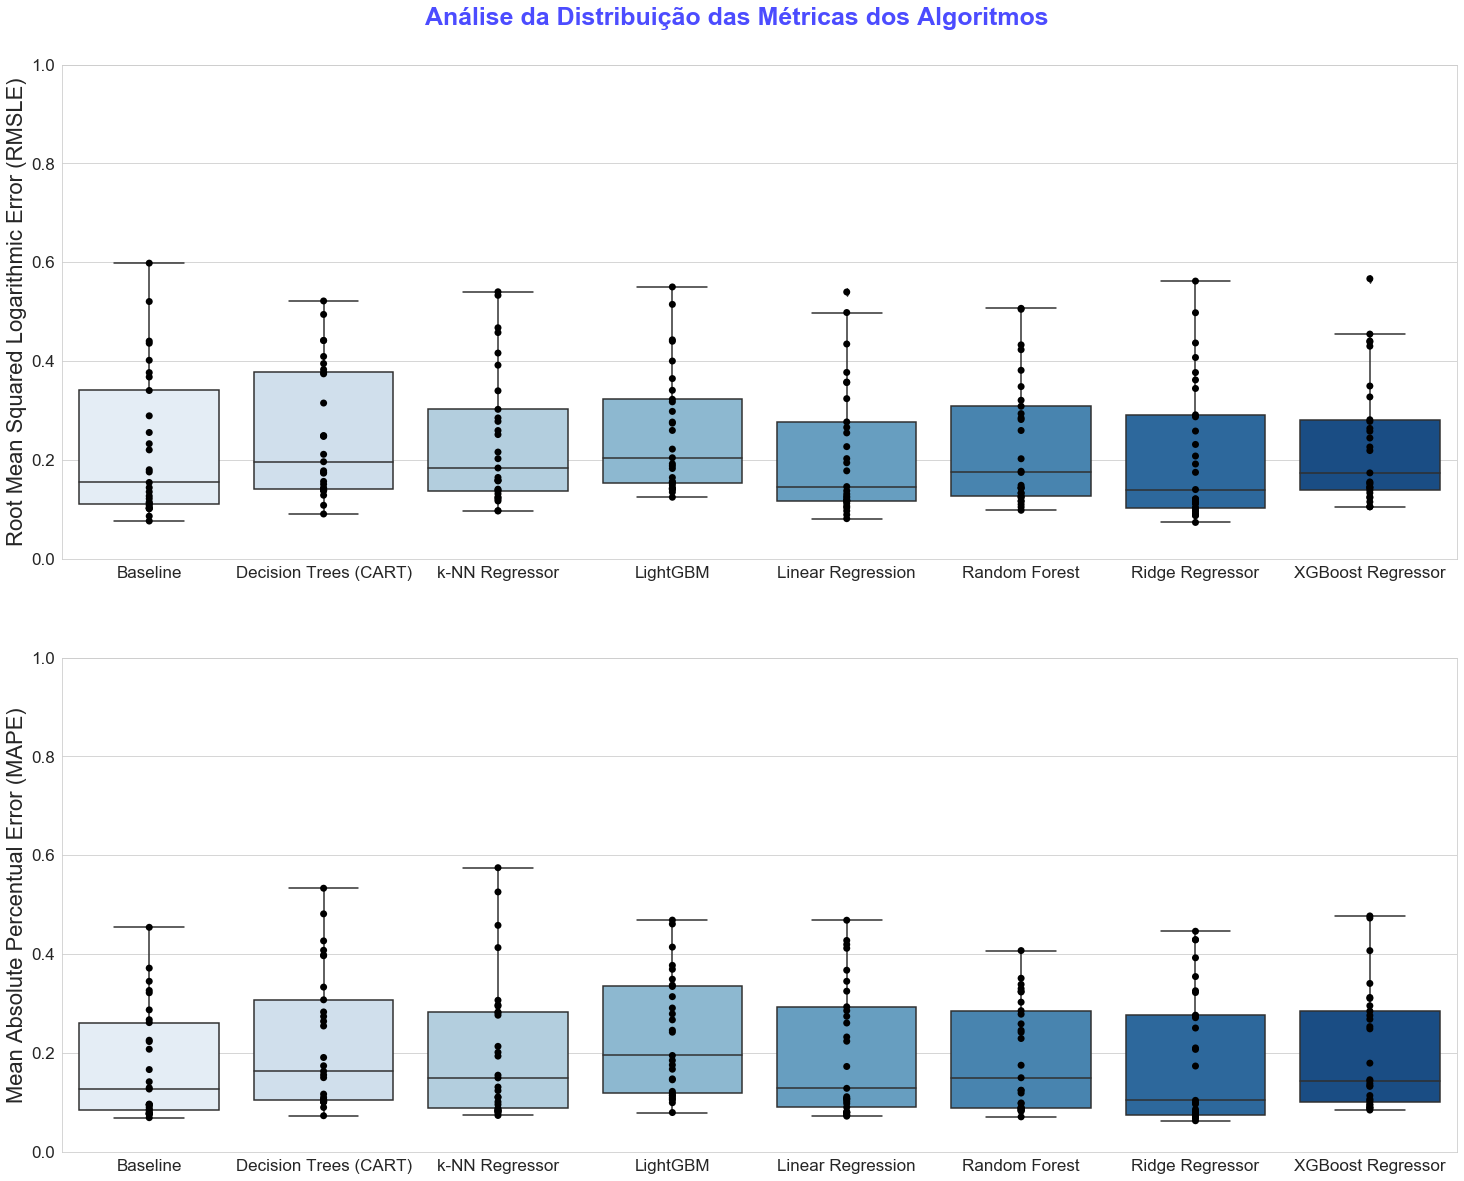

In [69]:
fig , ax = plt.subplots(ncols=1,nrows=2,figsize=(25,20))

fig.suptitle('Análise da Distribuição das Métricas dos Algoritmos',fontsize=25,weight='bold',color='blue',y=0.92,alpha=0.7)

sns.set_style("darkgrid")

sns.boxplot(data=ANL_RMSLE,palette="Blues",ax=ax[0])
sns.stripplot(data=ANL_RMSLE, color="black", jitter=0, size=7,ax=ax[0])
ax[0].set_ylim(0,1)
ax[0].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax[0].set_xticklabels(['Baseline','Decision Trees (CART)','k-NN Regressor','LightGBM','Linear Regression','Random Forest','Ridge Regressor','XGBoost Regressor'])
ax[0].tick_params(axis='y',labelsize=17)
ax[0].tick_params(axis='x',labelsize=17)
ax[0].set_xlabel('',fontsize=22)
ax[0].set_ylabel('Root Mean Squared Logarithmic Error (RMSLE)',fontsize=22)

sns.boxplot(data=ANL_MAPE,palette="Blues",ax=ax[1])
sns.stripplot(data=ANL_MAPE, color="black", jitter=0, size=7,ax=ax[1])
ax[1].set_ylim(0,1)
ax[1].set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])
ax[1].set_xticklabels(['Baseline','Decision Trees (CART)','k-NN Regressor','LightGBM','Linear Regression','Random Forest','Ridge Regressor','XGBoost Regressor'])
ax[1].tick_params(axis='y',labelsize=17)
ax[1].tick_params(axis='x',labelsize=17)
ax[1].set_xlabel('',fontsize=22)
ax[1].set_ylabel('Mean Absolute Percentual Error (MAPE)',fontsize=22)

plt.show()

## Analisando o RMSLE também em comparação com essa mesma análise feita anteriormente temos que o algoritmo de k-NN Regressor melhorou bastante, uma vez que ele apresenta boa mediana além de ter uma distribuição abaixo da mediana bem compacta, evidenciando a baixa variabilidade em erros menores.

## Visualizando Métricas por Estado
## MAPE

In [70]:
ms['MEAN_SEM_BASE'] = ms.iloc[:,1:].transpose().mean()
ms['MEAN_ALL'] = ms.transpose().mean()
#Visualizando o MAPE (%) de cada algoritmo por estado
ms.style.background_gradient(cmap="hot_r",vmin=0,vmax=.5)

In [71]:
ms2['MEAN_SEM_BASE'] = ms2.iloc[:,1:].transpose().mean()
ms2['MEAN_ALL'] = ms2.transpose().mean()
#Visualizando o RSLE de cada algoritmo por estado
ms2.style.background_gradient(cmap="hot_r",vmin=0,vmax=.5)

## Visualizando Graficamente o RSLE por Estado
### Com finalidade de inferir se o melhor algoritmo escolhido pode ser trocado por outro que apresenta melhor métrica de forma significativa para um determinado estado.

In [72]:
ms2 = ms2.rename(columns={'BASE_RSLE':'Baseline','RF_RSLE':'Random Forest','KNN_RSLE':'k-NN Regressor','LR_RSLE':'Linear Regression',
                          'XGB_RSLE':'XGBoost','CART_RSLE':'Decision Trees','LGBM_RSLE':'LightGBM','RID_RSLE':'Ridge Regressor'})
ms2.drop(columns=['MEAN_SEM_BASE','MEAN_ALL'],inplace=True)

Lista de estados com os melhores algoritmos:

Baseline: ['Bahia', 'Espírito Santo', 'Goiás', 'Paraná', 'Pernambuco', 'São Paulo']
Random Forest: ['Alagoas', 'Amapá']
k-NN Regressor: ['Distrito Federal', 'Piauí', 'Rondônia', 'Roraima']
Linear Regression: ['Maranhão', 'Pará']
XGBoost: ['Amazonas', 'Paraíba', 'Rio Grande do Norte', 'Santa Catarina', 'Tocantins']
Decision Trees:[]
LightGBM: []
Ridge Regressor:['Acre', 'Ceará', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Rio Grande do Sul', 'Rio de Janeiro', 'Sergipe']



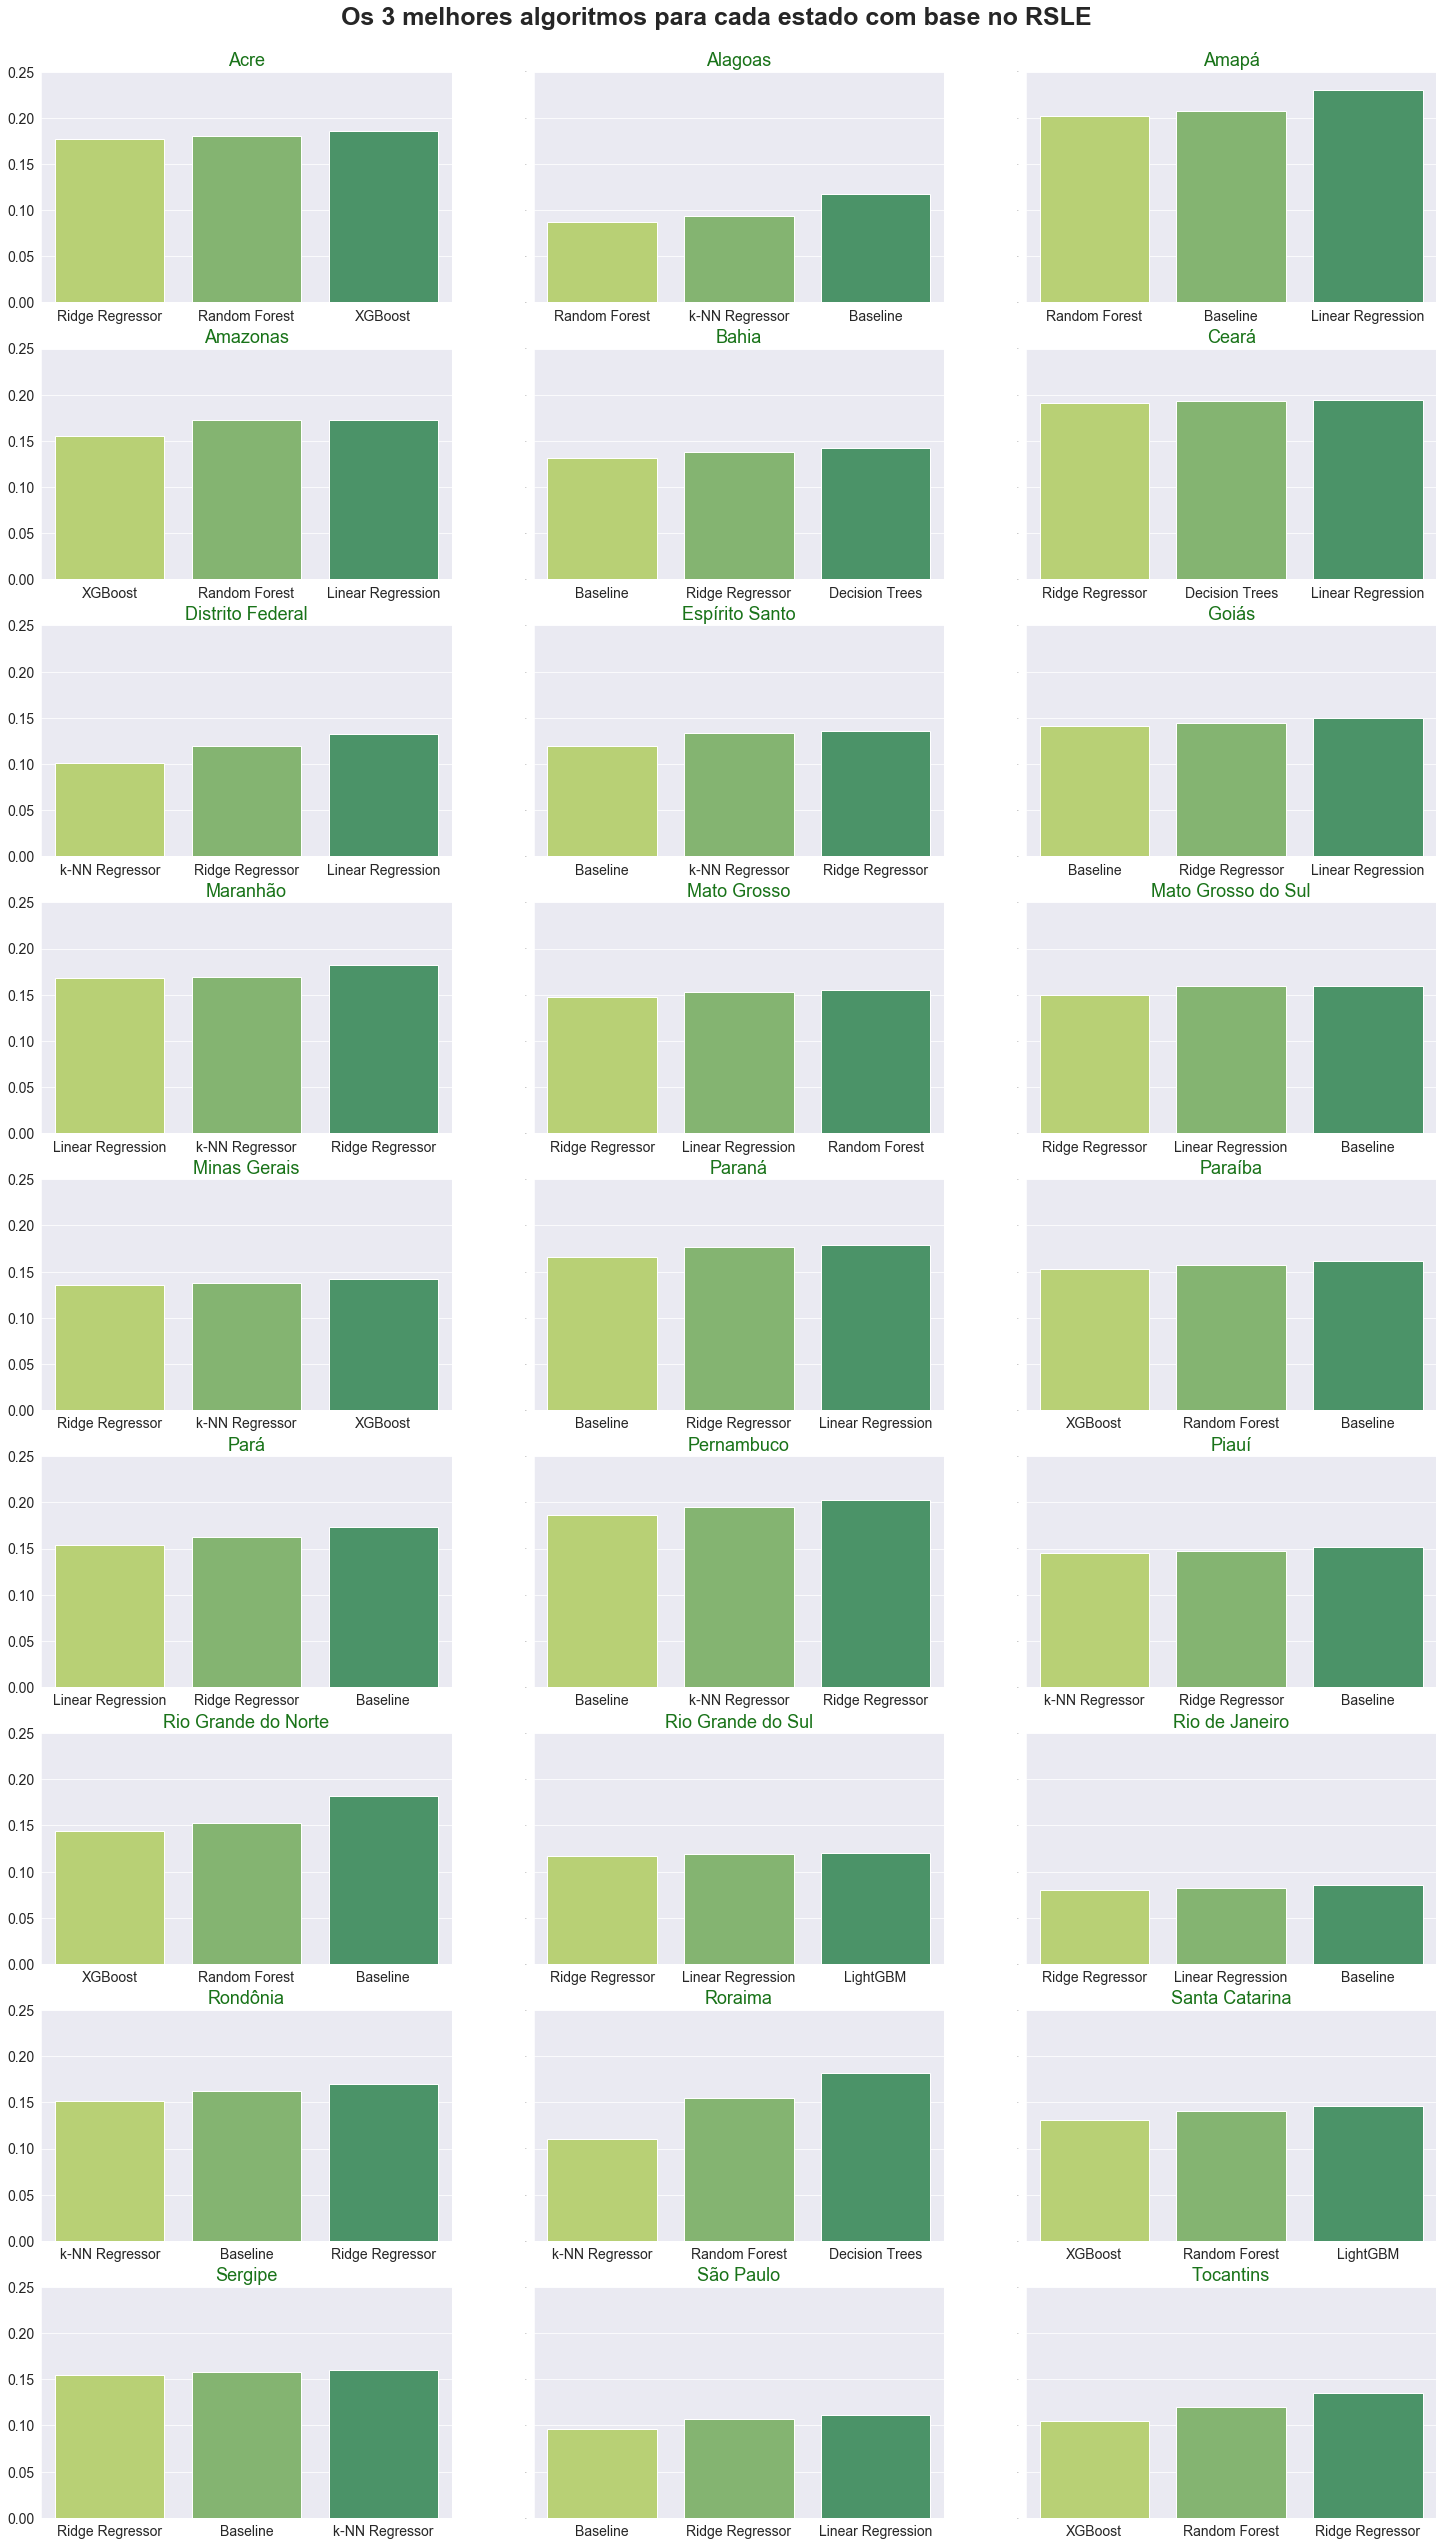

In [74]:
BASE, RF, KNN, LR, XGB, CART, LGBM, RID = [],[],[],[],[],[],[],[]
best_alg = 3
fig , ax = plt.subplots(nrows=9,ncols=3,figsize=(25,45))
fig.suptitle('Os {} melhores algoritmos para cada estado com base no RSLE'.format(best_alg),weight='bold',fontsize=25,y=.9)

estados = ['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará','Distrito Federal', 'Espírito Santo', 'Goiás', 'Maranhão',
           'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Paraná','Paraíba', 'Pará', 'Pernambuco', 'Piauí', 'Rio Grande do Norte',
           'Rio Grande do Sul', 'Rio de Janeiro', 'Rondônia', 'Roraima','Santa Catarina', 'Sergipe', 'São Paulo', 'Tocantins']

l = 0
c = 0
for est in range(0,len(estados)):
    
    if est%3 == 0 and est!=0:
        c=0
        l=l+1
                                        
    a=ms2.transpose().sort_values(by='{}'.format(estados[est]),ascending=True).head(best_alg).loc[:,['{}'.format(estados[est])]]
    sns.barplot(x=a.index,y=a.iloc[:,0],ax=ax[l,c],palette='summer_r')
    ax[l,c].set_title('{}'.format(estados[est]),fontsize=18,color='darkgreen',alpha=.9)
    ax[l,c].set_ylabel('')
    ax[l,c].set_ylim(0,0.25)
    ax[l,c].set_yticks([0.00,0.05,0.10,0.15,0.20,0.25])
    ax[l,c].tick_params(axis='x',labelsize=14)
    
    if a.index[0] == 'Baseline': BASE.append(estados[est])
    elif a.index[0] == 'Random Forest': RF.append(estados[est])
    elif a.index[0] == 'k-NN Regressor': KNN.append(estados[est])        
    elif a.index[0] == 'Linear Regression': LR.append(estados[est])        
    elif a.index[0] == 'XGBoost': XGB.append(estados[est])
    elif a.index[0] == 'Decision Trees': CART.append(estados[est])        
    elif a.index[0] == 'LightGBM': LGBM.append(estados[est])
    elif a.index[0] == 'Ridge Regressor': RID.append(estados[est])       
        
    if c==0:
        ax[l,c].tick_params(axis='y',labelsize=14)
    else:
        ax[l,c].tick_params(axis='y',labelsize=0)
  
    c=c+1
    
print("Lista de estados com os melhores algoritmos:\n\nBaseline: {}\nRandom Forest: {}\nk-NN Regressor: {}\nLinear Regression: {}\nXGBoost: {}\nDecision Trees:{}\nLightGBM: {}\nRidge Regressor:{}\n".format(BASE,RF,KNN,LR,XGB,CART,LGBM,RID))

plt.show()

## Com base nos resultados obtidos, podemos escolher o melhor algoritmo para cada estado com finalidade de ter a melhor previsão pra cada um. Entretanto, algumas diferenças da métrica entre os melhores algoritmos não são tão significativas a ponto de melhorar consideravelmente a previsão. Logo, escolher um algoritmo base com finalidade de prever todos os estados e em sequência analisar onde ele não é mais efetivo, e assim compará-lo com os outros e decidir se a escolha de algum outro algoritmo ocasionará em uma melhora significativa.
## Portanto, a partir todas as análises feitas até o momento o meu algoritmo base que vai realizar o forecast para todos os estados será o Ridge Regressor. Assim sendo, realizaremos um treino & validação e análise das métricas para ele de forma específica. Escolheremos também mais dois algoritmos para forecast que serão a Linear Regression e o XGBoost Regressor, com finalidade de visualizar os resultados dos mesmos.

# 

## Ridge Regressor

In [75]:
models=[Ridge(random_state=0,alpha=0.03,normalize=True,fit_intercept=True)]

name_mod=['RID']

feat_mod = [['Cases_Last_Day', 'UF_CAT_TO', 'UF_CAT_AL', 'UF_CAT_SE', 'UF_CAT_RO', 'UF_CAT_MS', 'UF_CAT_AC', 'REG_CAT_Sul','UF_CAT_PI', 'UF_CAT_GO']]

#Criando dataframe para análise da performance do modelo
analytics=pd.DataFrame(columns=['date','Day','target','predict','MAPE','RMSE','RMSLE'])

for num in range(0,len(models)):
    
    error=[]
    error2=[]
    analytics=pd.DataFrame(columns=['date','Day','target','predict_{}'.format(name_mod[num]),'MAPE_{}'.format(name_mod[num]),'RMSE_{}'.format(name_mod[num]),'RMSLE_{}'.format(name_mod[num])])
    
    for i in range(mn,mx+1):
        if date_state[date_state['Day']==i].shape[0] !=0:

            train=date_state[date_state['Day']<i]
            test=date_state[date_state['Day']==i]

            sel=feat_mod[num]
            X_train=train.loc[:,sel].values
            y_train=train['cases'].values
            X_test=test.loc[:,sel].values
            y_test=test['cases'].values

            model=models[num]
            model.fit(X_train,y_train)

            y_pred=model.predict(X_test)

            y_state=test['state'].values
            aux=MAPE_STATE(y_pred,y_test,y_state)
            aux=aux.set_index(aux.state).drop(columns='state')
            if(i==mn):
                m=aux
            else:
                m=m.merge(aux,how='outer',on='state')
                
            e = MAPE(y_pred,y_test)
            error.append(e)
            e2 = RMSLE(y_pred,y_test)
            error2.append(e2)              

            #Guardando predicts, targets e outras informações para análise do desempenho do modelo
            att=pd.DataFrame({'date':test.date.max(),'Day':test.Day.max(),'target':y_test.mean(),'predict_{}'.format(name_mod[num]):y_pred.mean(),
                              'MAPE_{}'.format(name_mod[num]):MAPE(y_pred,y_test),'RMSLE_{}'.format(name_mod[num]):RMSLE(y_pred,y_test),'RMSE_{}'.format(name_mod[num]):RMSE(y_pred,y_test)},index=[0])

            #Atualizando dataframe de análise
            analytics=pd.concat([analytics,att]).reset_index(drop=True,level=0)        

    #Imprimir mensagem para cada algorimo mostrando os scores
    msg=print("\n{}\nMédia do Erro MAPE: {:.4f}%\nMédia do Erro RMSLE: {:.4f}".format(name_mod[num],np.mean(error)*100,np.mean(error2)))
    
    #Salvando o modelo
    joblib.dump(model,'model_{}.pkl'.format(name_mod[num]))
    
    if name_mod[num] == 'RID':
        er_lr=pd.DataFrame(error,columns=['{}_MAPE'.format(name_mod[num])]); er2_lr=pd.DataFrame(error2,columns=['{}_RMSLE'.format(name_mod[num])]);
        m_lr=pd.DataFrame(m.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_MAPE'.format(name_mod[num])]); #ms=pd.concat([ms,m_lr],axis=1);
        m2_lr=pd.DataFrame(m2.iloc[:,list(range(2,3*(mx+1-mn),3))].transpose().mean(),columns=['{}_RSLE'.format(name_mod[num])]); #ms2=pd.concat([ms2,m2_lr],axis=1);
        an_lr=analytics; #ANALYTICS=ANALYTICS.merge(an_lr.iloc[:,[1,3,4,5,6]],how='left',on='Day');
        msg;


RID
Média do Erro MAPE: 19.1388%
Média do Erro RMSLE: 0.2138


## Load Model

In [76]:
#Carregando e visualizando os parâmetros do modelo
model=joblib.load('model_RID.pkl')
print(model,'\n\n',model.coef_)

Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=0, solver='auto', tol=0.001) 

 [ 1.10000175 -3.97682597 -3.97544087 -4.0684691  -3.98376718 -3.95045978
 -4.12540133 -2.56623401 -3.9768279  -3.52004725]


## Análise da Performance de Treino e Validação

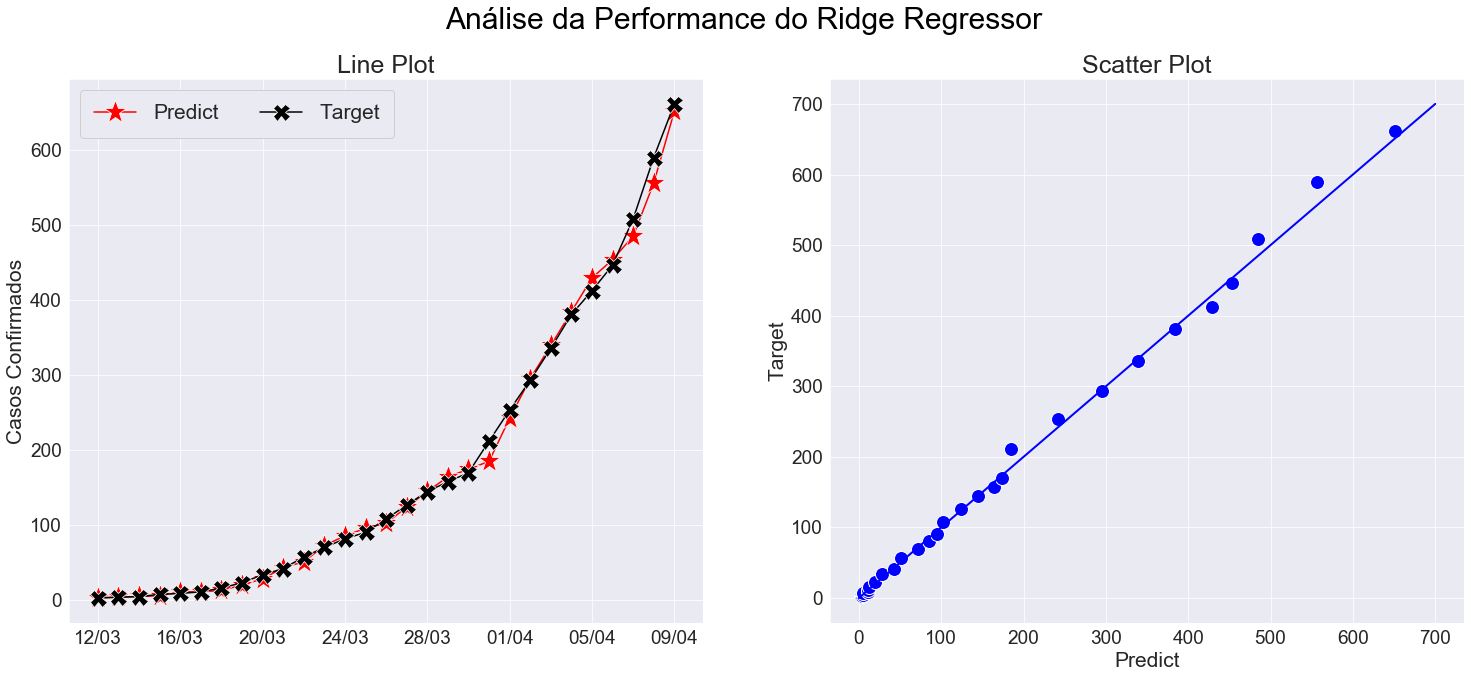

In [78]:
fig , ax = plt.subplots(ncols=2,nrows=1,figsize=(25,10))
fig.suptitle("Análise da Performance do Ridge Regressor",fontsize=30,y=0.98,color="black")

#Definindo tamanho das fontes
sizelabel , sizetick , sizetit = 21 , 19 , 25

#Personalizando o formato da data mostrada nos ticks
dateview=[pd.to_datetime(an_rid.date)[x].strftime("%d/%m") for x in range(0,len(an_rid.date))]

sns.set_style("darkgrid")
sns.lineplot(x=an_rid.date,y=an_rid.predict_RID,color="red",marker='*',markersize=24,ax=ax[0],linestyle=':',label='Predict')
sns.lineplot(x=an_rid.date,y=an_rid.target,color="black",marker='X',markersize=17,ax=ax[0],label='Target')
ax[0].set_ylabel('Casos Confirmados',fontsize=sizelabel)
ax[0].set_title('Line Plot',fontsize=sizetit)
ax[0].set_xlabel('',fontsize=sizelabel)
ax[0].tick_params(axis='x',labelsize=sizetick)
ax[0].tick_params(axis='y',labelsize=sizetick)
ax[0].set_xticks(an_rid.date[::-4])
ax[0].set_xticklabels(dateview[::-4])
ax[0].legend(ncol=2,fontsize=21,loc="upper left",frameon=True,framealpha=0.90,borderpad = 0.7)

ax[1].plot(an_rid.predict_RID,an_rid.target,color="blue",marker='o',linestyle='none',markersize=14, markeredgecolor="white", markeredgewidth=1) #line_kws={"color":"black","alpha":0.7,"lw":3}
plt.plot([0, 700], [0, 700], color="blue", lw=2, linestyle='solid', label="_not in legend")
ax[1].set_ylabel('Target',fontsize=sizelabel)
ax[1].set_title('Scatter Plot',fontsize=sizetit)
ax[1].set_xlabel('Predict',fontsize=sizelabel)
ax[1].tick_params(axis='x',labelsize=sizetick)
ax[1].tick_params(axis='y',labelsize=sizetick)

plt.show()

## Análise das Métricas
## MAPE


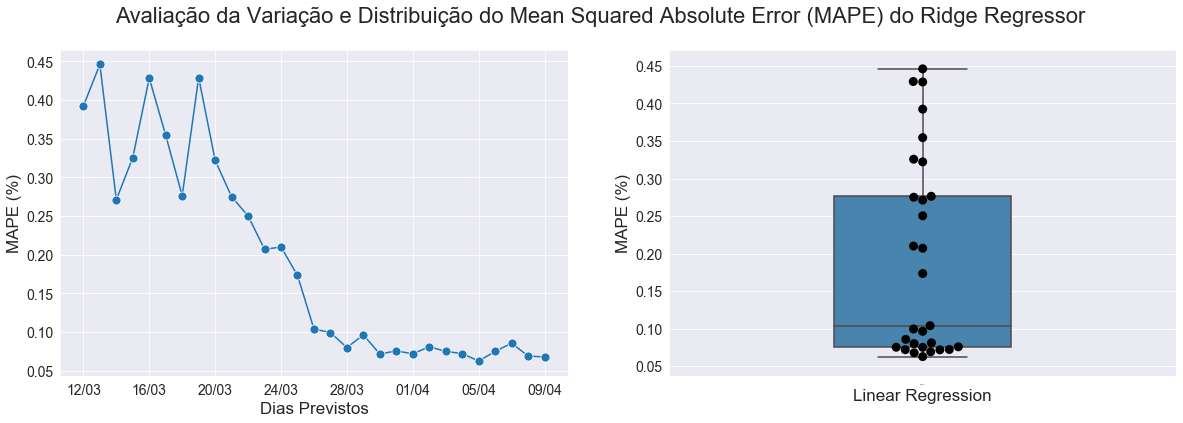

In [83]:
fig , ax = plt.subplots(figsize=(20,6),nrows=1,ncols=2)

sns.set_style("darkgrid")
fig.suptitle("Avaliação da Variação e Distribuição do Mean Squared Absolute Error (MAPE) do Ridge Regressor",fontsize=22)

#Gráfico de Linhas
sns.lineplot(x=an_rid.date,y=an_rid.MAPE_RID,palette=["blue"],marker='o',linestyle='-',markersize=9,ax=ax[0],legend=False)
ax[0].set_ylabel("MAPE (%)",size=17)
ax[0].set_xlabel("Dias Previstos",size=17)
ax[0].tick_params(axis='x',labelsize=14)
ax[0].tick_params(axis='y',labelsize=14)
ax[0].set_xticks(an_rid.date[::-4])
ax[0].set_xticklabels(dateview[::-4])

#Boxplot
sns.boxplot(data=er_rid, palette="Blues_d",orient="v",width=0.35,ax=ax[1])
sns.swarmplot(data=er_rid, palette=["black"],orient="v",color=.20,size=9,ax=ax[1])
ax[1].set_ylabel("MAPE (%)",size=17)
ax[1].set_xlabel("Linear Regression",size=17)
ax[1].tick_params(axis='x',labelsize=0)
ax[1].tick_params(axis='y',labelsize=14)
plt.show()

## RMSLE

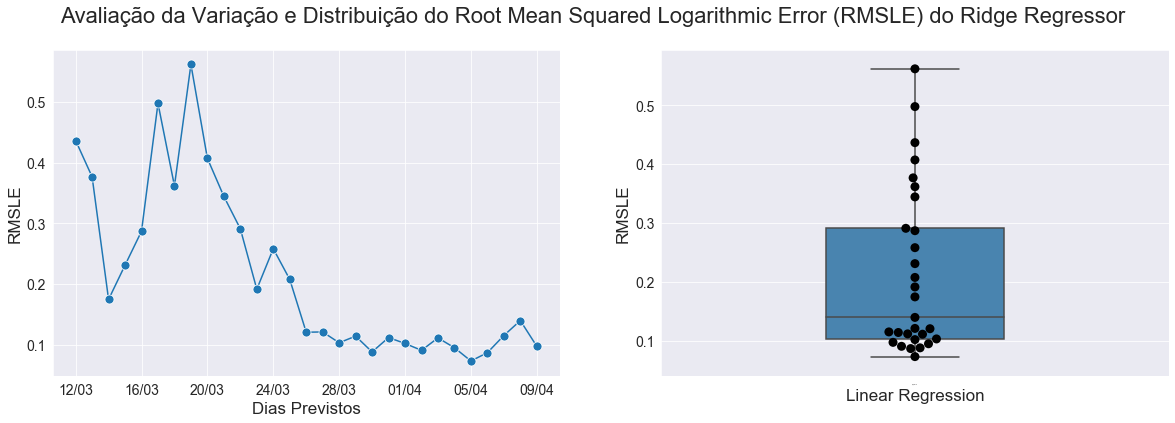

In [86]:
fig , ax = plt.subplots(figsize=(20,6),nrows=1,ncols=2)

sns.set_style("darkgrid")
fig.suptitle("Avaliação da Variação e Distribuição do Root Mean Squared Logarithmic Error (RMSLE) do Ridge Regressor",fontsize=22)

#Gráfico de Linhas
sns.lineplot(x=an_rid.date,y=an_rid.RMSLE_RID,palette=["blue"],marker='o',linestyle='-',markersize=9,ax=ax[0],legend=False)
ax[0].set_ylabel("RMSLE",size=17)
ax[0].set_xlabel("Dias Previstos",size=17)
ax[0].tick_params(axis='x',labelsize=14)
ax[0].tick_params(axis='y',labelsize=14)
ax[0].set_xticks(an_rid.date[::-4])
ax[0].set_xticklabels(dateview[::-4])

#Boxplot
sns.boxplot(data=er2_rid, palette="Blues_d",orient="v",width=0.35,ax=ax[1])
sns.swarmplot(data=er2_rid, palette=["black"],orient="v",color=.20,size=9,ax=ax[1])
ax[1].set_ylabel("RMSLE",size=17)
ax[1].set_xlabel("Linear Regression",size=17)
ax[1].tick_params(axis='x',labelsize=0)
ax[1].tick_params(axis='y',labelsize=14)
plt.show()

## RSLE & MAPE por Estado

In [87]:
pd.concat([m2_rid,m_rid],axis=1).sort_values(by='RID_RSLE',ascending=True).style.background_gradient(cmap='hot_r',vmin=0,vmax=.5)

# 

# Forecasts

In [3]:
#Carregando, limpando e ajustando o dataset utilizado
date_state=pd.read_csv('date_state_covidbr.csv',sep=';')
date_state=date_state.fillna(0)
date_state.date = pd.to_datetime(date_state.date)

date_state.shape

(1917, 87)

## Como seria a previsão da Baseline ?

In [26]:
#Total de casos confirmados no Brasil até o último dia do dataset
base_fore = date_state.groupby(['date','state'])[['cases']].sum().reset_index().groupby('date').sum().reset_index()

att = base_fore.cases.max()
prev = []
dias = 7
for i in range(0,dias):
    if i == 0:
        p = att*1.16
    else:
        p = p*1.16
        
    prev.append(p)
    
print(prev)

[20714.12, 24028.379199999996, 27872.919871999995, 32332.587051519993, 37505.80097976319, 43506.7291365253, 50467.80579836934]


## Ridge Regressor

In [4]:
#Carregando o modelo
model = joblib.load('model_RID.pkl')
model

Ridge(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=0, solver='auto', tol=0.001)

In [5]:
#Selecionando estados para previsão
ufs=['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT',
       'MS', 'MG', 'PR', 'PB', 'PA', 'PE', 'PI', 'RN', 'RS', 'RJ', 'RO',
       'RR', 'SC', 'SE', 'SP', 'TO']

In [136]:
#Total de casos confirmados no Brasil até o último dia do dataset
date_state.groupby('state').last().cases.sum()

17857

In [123]:
#Variáveis do Modelo
#['Cases_Last_Day', 'UF_CAT_TO', 'UF_CAT_AL', 'UF_CAT_SE', 'UF_CAT_RO', 'UF_CAT_MS', 'UF_CAT_AC', 'REG_CAT_Sul','UF_CAT_PI', 'UF_CAT_GO']

In [6]:
tot_cases=[]
allforecast=date_state.copy()

ufs=['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT','MS', 'MG', 'PR', 'PB', 'PA', 'PE', 'PI', 'RN', 'RS', 'RO','RR', 'SC', 'SE', 'TO', 'RJ', 'SP']
#ufs=['SP']

for i in range(0,len(ufs)):  
    
    #Selecionando as features finais do modelo e as variáveis dia/data para definir a previsão e estado/uf para especificidade
    forecast=date_state[['Day','date','state','UF','cases','Cases_Last_Day', 'UF_CAT_TO', 'UF_CAT_RO', 'UF_CAT_AL', 'UF_CAT_SE',
                         'REG_CAT_Sul', 'UF_CAT_AC', 'UF_CAT_MS', 'UF_CAT_PI', 'UF_CAT_GO']]
    
    #Selecionando dados a partir do primeiro caso confirmado no Brasil
    forecast = forecast[forecast['date']>='2020-02-26'].reset_index(drop=True,level=0)

    #Definindo a UF do estado para previsão
    uf=ufs[i]
    forecast=forecast[forecast['UF']==uf]

    #Definindo dias para previsão
    dias=7

    for i in range(0,dias):

        #Preparando os dados para a previsão
        #'Cases_Last_Day'
        cld=forecast.groupby('state').cases.last()[0]       
        #'REG_CAT_Sul'
        sul=forecast.groupby('state').REG_CAT_Sul.last()[0]
        #'UF_CAT_SE'
        ufse = 1 if uf=='SE' else 0   
        #'UF_CAT_AL'
        ufal = 1 if uf=='AL' else 0             
        #'UF_CAT_PI'
        ufpi = 1 if uf=='PI' else 0
        #'UF_CAT_MS'
        ufms = 1 if uf=='MS' else 0
        #'UF_CAT_TO'
        ufto = 1 if uf=='TO' else 0  
        #'UF_CAT_GO'
        ufgo = 1 if uf=='GO' else 0         
        #'UF_CAT_AC'
        ufac = 1 if uf=='AC' else 0 
        #'UF_CAT_RO'
        ufro = 1 if uf=='RO' else 0         

        #Previsão para o próximo dia e ajuste no dataset com as informações
        dia=forecast.Day.max()+1
        estado=forecast.state.tail(1).values[0]
        
        prev=model.predict([[cld,ufto,ufal,ufse,ufro,ufms,ufac,sul,ufpi,ufgo]])[0]    
        
        att=pd.DataFrame({'Day':dia,'date':pd.date_range(date_state.date.max(), periods=i+2).tolist()[-1],'state':estado,'UF':uf,
                          'cases':prev,'Cases_Last_Day':forecast.cases.tail(1).values[0],
                          'REG_CAT_Sul':np.nan,
                          'UF_CAT_TO':np.nan,'UF_CAT_RO':np.nan,'UF_CAT_AL':np.nan,'UF_CAT_SE':np.nan,
                          'UF_CAT_AC':np.nan,'UF_CAT_MS':np.nan,'UF_CAT_PI':np.nan,'UF_CAT_GO':np.nan},index=[0])
        
        forecast=pd.concat([forecast,att]).reset_index(level=0,drop=True)

        forecast['REG_CAT_Sul'] = forecast.groupby('state').REG_CAT_Sul.last()[0]      
        forecast['UF_CAT_SE'] = 1 if uf=='SE' else 0
        forecast['UF_CAT_AL'] = 1 if uf=='AL' else 0
        forecast['UF_CAT_RO'] = 1 if uf=='RO' else 0        
        forecast['UF_CAT_PI'] = 1 if uf=='PI' else 0        
        forecast['UF_CAT_MS'] = 1 if uf=='MS' else 0
        forecast['UF_CAT_TO'] = 1 if uf=='TO' else 0
        forecast['UF_CAT_GO'] = 1 if uf=='GO' else 0
        forecast['UF_CAT_AC'] = 1 if uf=='AC' else 0 
        forecast = forecast.fillna(0)

    tot_cases.append(forecast.cases.tail(1).values[0])
    new=forecast[forecast['Day']>71] #automatizar 'mx' #!!!!!!!!!!!!!!!!!!!!!!!!! NÃO ESQUECEEER DE MUDAAAR
    allforecast=pd.concat([allforecast,new]).reset_index(level=0,drop=True)

print("\nTotal de casos confirmados no Brasil para daqui {} dias : {}\n".format(dias,sum(tot_cases)))
forecast.tail(dias+3)


Total de casos confirmados no Brasil para daqui 7 dias : 35491.6843366344



Day       date      state  UF         cases  Cases_Last_Day  UF_CAT_TO  \
41   69 2020-04-07  São Paulo  SP   5682.000000     4866.000000          0   
42   70 2020-04-08  São Paulo  SP   6708.000000     5682.000000          0   
43   71 2020-04-09  São Paulo  SP   7480.000000     6708.000000          0   
44   72 2020-04-10  São Paulo  SP   8232.173332     7480.000000          0   
45   73 2020-04-11  São Paulo  SP   9059.565310     8232.173332          0   
46   74 2020-04-12  São Paulo  SP   9969.697930     9059.565310          0   
47   75 2020-04-13  São Paulo  SP  10970.845400     9969.697930          0   
48   76 2020-04-14  São Paulo  SP  12072.109364    10970.845400          0   
49   77 2020-04-15  São Paulo  SP  13283.501647    12072.109364          0   
50   78 2020-04-16  São Paulo  SP  14616.035271    13283.501647          0   

    UF_CAT_RO  UF_CAT_AL  UF_CAT_SE  REG_CAT_Sul  UF_CAT_AC  UF_CAT_MS  \
41          0          0          0          0.0          0          0   
42          0          0          0          0.0          0          0   
43          0          0          0          0.0          0          0   
44          0          0          0          0.0          0          0   
45          0          0          0          0.0          0          0   
46          0          0          0          0.0          0          0   
47          0          0          0          0.0          0          0   
48          0          0          0          0.0          0          0   
49          0          0          0          0.0          0          0   
50          0          0          0          0.0          0          0   

    UF_CAT_PI  UF_CAT_GO  
41          0          0  
42          0          0  
43          0          0  
44          0          0  
45          0          0  
46          0          0  
47          0          0  
48          0          0  
49          0          0  
50          0          0

## Previsão do total de casos em São Paulo para os próximos 7 dias

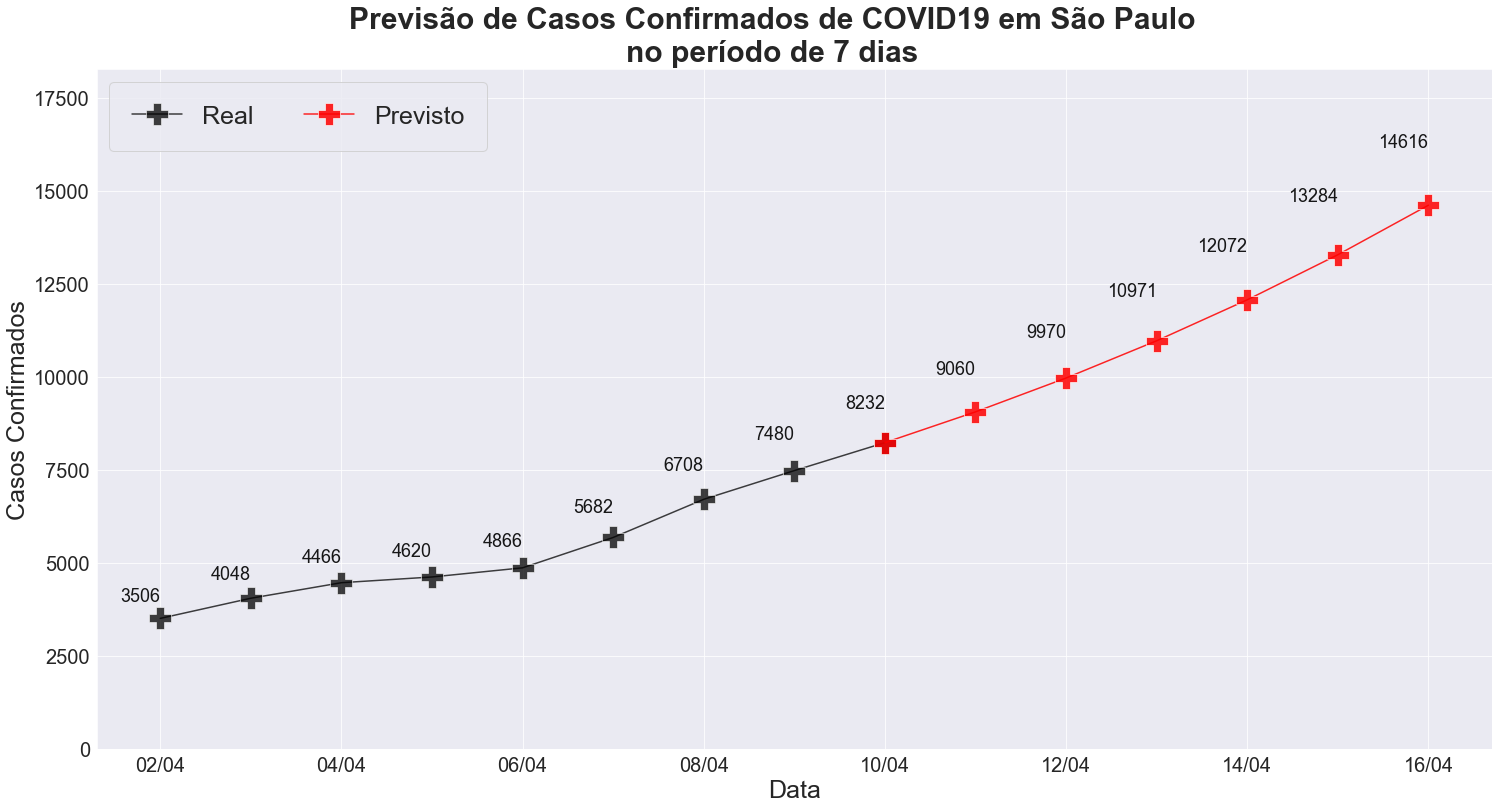

In [63]:
#Visualizando progressão do COVID19 no último estado da lista ufs e do dataframe forecast

#Definindo o período para mostrar no gráfico
ult_dias = 15
fore = forecast[forecast['date']>forecast[forecast['Day']==forecast.Day.max()-ult_dias].date.tail(1).values[0]].reset_index(drop=True)

#Configurando o formato da data que desejo mostrar no gráfico
dateview = [fore.date[x].strftime("%d/%m") for x in range(0,len(fore.date))]

fig , ax = plt.subplots(figsize=(25,12.5))
fig.suptitle("Previsão de Casos Confirmados de COVID19 em {}\nno período de {} dias".format(fore.state[0],dias),fontsize=30,y=0.95,weight='bold')

sns.set_style("darkgrid")
sns.lineplot(x=fore.date[:-dias+1],y=fore.cases[:-dias+1],color="black",marker='P',markersize=22,label="Real",alpha=0.75)
sns.lineplot(x=fore.date[-dias:],y=fore.cases[-dias:],color="red",marker='P',markersize=22,label="Previsto",alpha=0.85)
ax.set_ylim(0,fore.cases.max()*1.25)
ax.set_xlabel('Data',fontsize=25)
ax.set_ylabel('Casos Confirmados',fontsize=25)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)
ax.set_xticks(fore.date[::-2])
ax.set_xticklabels(dateview[::-2])
ax.legend(ncol=2,fontsize=25,borderpad=0.925,loc='upper left')
        
#Exibindo valores de todos os dias
for i in range(1,ult_dias+1):
    ax.annotate('{:.0f}'.format(fore.cases.tail(i).values[0]),xy=(fore.date.tail(i).values[0],fore.cases.tail(i).values[0]*1.10),
                size=18,ha='right',va='bottom',color='black',alpha=.9)

plt.show()

## Previsão para o total de casos no Brasil para os próximos 7 dias

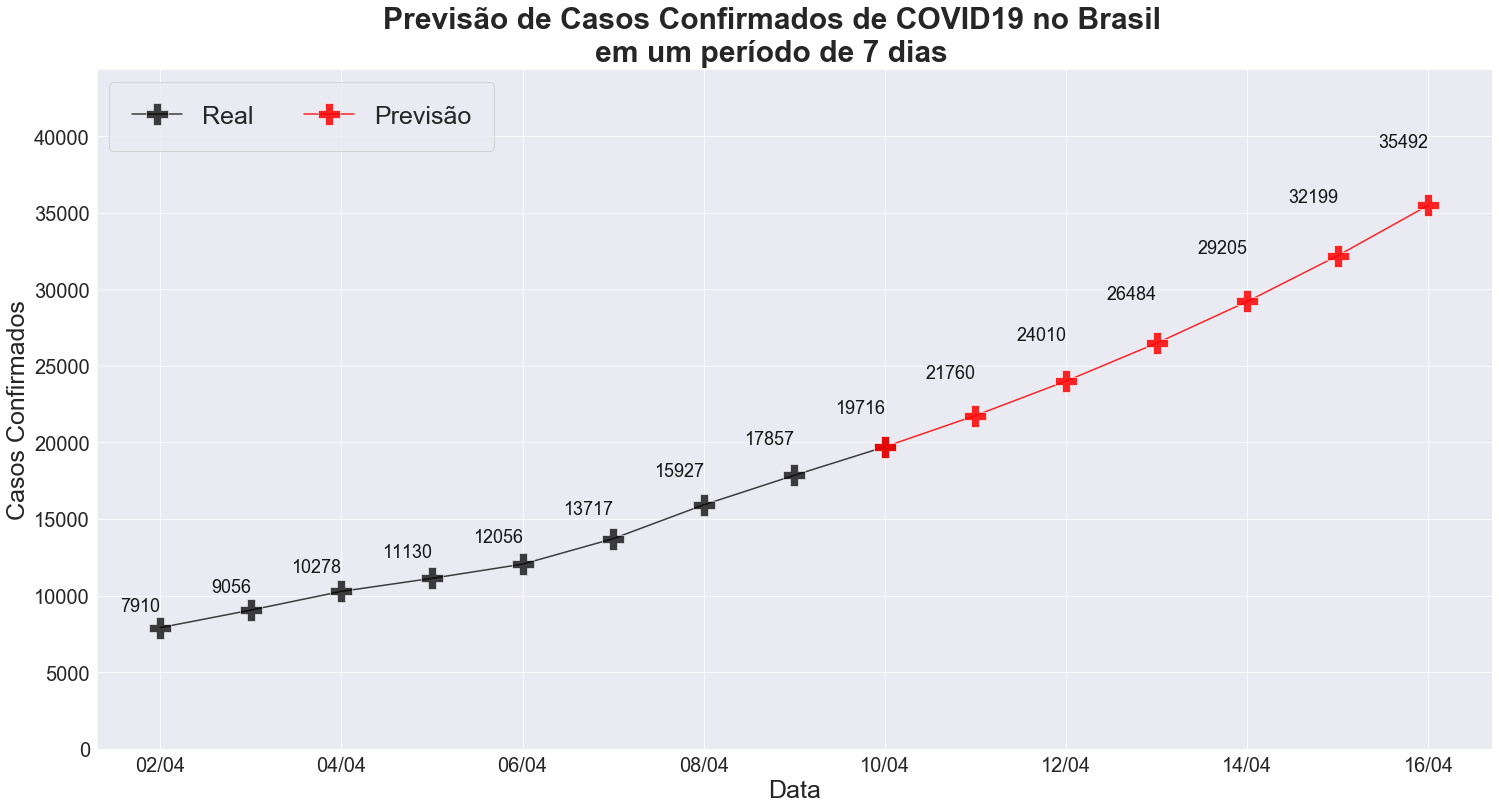

In [62]:
#Soma de casos confirmado no Brasil
br_forecast = allforecast.groupby(['date'])[['cases']].sum().reset_index()

#Definindo o período para mostrar no gráfico
ult_dias = 15
br_forecast = br_forecast[br_forecast['date']>allforecast[allforecast['Day']==allforecast.Day.max()-ult_dias].date.tail(1).values[0]].reset_index(drop=True)

#Configurando o formato da data que desejo mostrar no gráfico
dateview = [br_forecast.date[x].strftime("%d/%m") for x in range(0,len(br_forecast.date))]

fig , ax = plt.subplots(figsize=(25,12.5))
fig.suptitle("Previsão de Casos Confirmados de COVID19 no Brasil\nem um período de {} dias".format(dias),fontsize=30,y=0.95,weight='bold')

sns.set_style("darkgrid")
sns.lineplot(x=br_forecast.date[:-dias+1],y=br_forecast.cases[:-dias+1],color="black",marker='P',markersize=22,label="Real",alpha=0.75)
sns.lineplot(x=br_forecast.date[-dias:],y=br_forecast.cases[-dias:],color="red",marker='P',markersize=22,label="Previsão",alpha=0.85)
ax.set_ylim(0,br_forecast.cases.max()*1.25)
ax.set_xlabel('Data',fontsize=25)
ax.set_ylabel('Casos Confirmados',fontsize=25)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)
ax.set_xticks(br_forecast.date[::-2])
ax.set_xticklabels(dateview[::-2])
ax.legend(ncol=2,fontsize=25,borderpad=0.925,loc='upper left')
        
#Exibindo valores de todos os dias
for i in range(1,ult_dias+1):
    ax.annotate('{:.0f}'.format(br_forecast.cases.tail(i).values[0]),xy=(br_forecast.date.tail(i).values[0],br_forecast.cases.tail(i).values[0]*1.10),
                size=18,ha='right',va='bottom',color='black',alpha=.9)

plt.show()

## Segundo o https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv , o número total de casos confirmados no Brasil dos dias seguintes foram:
### 10/04 - 19937
### 11/04 - 20972
### 12/04 - 22422
## Logo, comparando com as previões feitas, temos que para o dia seguinte o modelo se aproxima bastante do valor verdadeiro, e conforme os dias vão se passando o erro aumenta, o que é esperado, uma vez que é feita previsão em cima de previsão. Uma alternativa para diminuir um pouco esse erro ao longo dos dias seria treinar o modelo a cada previsão feita.

In [7]:
#Calculando o RMSLE desses dados de 'teste' ou em produção temos:
RMSLE([19716,21760,24010],[19937,20972,22422])

0.05041060875771099

## Previsão do total de casos por estado nos próximos 7 dias

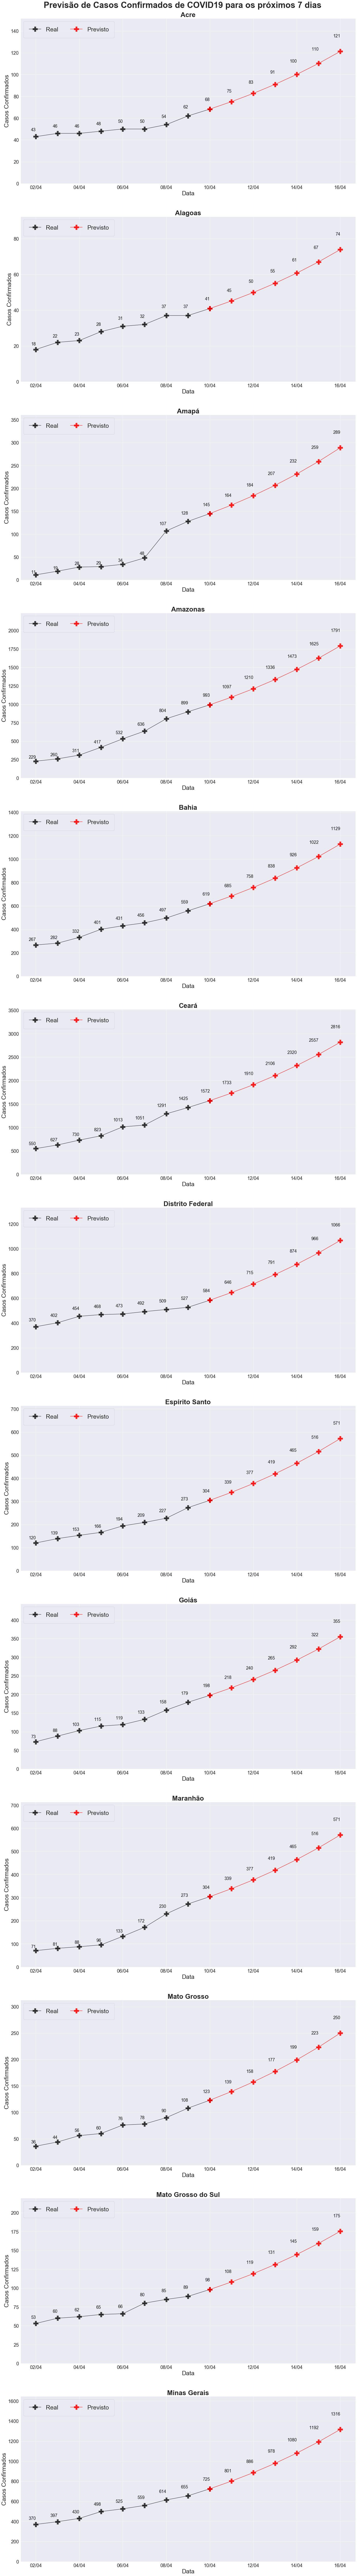

In [61]:
fig , ax = plt.subplots(ncols=1,nrows=13,figsize=(25,195))
fig.suptitle("Previsão de Casos Confirmados de COVID19 para os próximos {} dias".format(dias),fontsize=35,y=0.885,weight='bold')
sns.set_style("darkgrid")

#Selecionando os estados para previsão
estados = ['Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará','Distrito Federal', 'Espírito Santo', 'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais']
           #, 'Paraná','Paraíba', 'Pará', 'Pernambuco', 'Piauí','Rio Grande do Norte','Rio Grande do Sul',
            #'Rio de Janeiro', 'Rondônia', 'Roraima','Santa Catarina', 'Sergipe', 'São Paulo', 'Tocantins']

for est in range(0,len(estados)):
    
    #Definindo o período para mostrar no gráfico
    ult_dias = 15
    fore = allforecast[allforecast['date']>allforecast[allforecast['Day']==allforecast.Day.max()-ult_dias].date.tail(1).values[0]].reset_index(drop=True)
    
    #Selecionando cada estado para forecast
    fore = fore[fore['state']==estados[est]].reset_index(drop=True)

    #Configurando o formato da data que desejo mostrar no gráfico
    dateview = [fore.date[x].strftime("%d/%m") for x in range(0,len(fore.date))]

    sns.lineplot(x=fore.date[:-dias+1],y=fore.cases[:-dias+1],color="black",marker='P',markersize=22,label="Real",alpha=0.75,ax=ax[est])
    sns.lineplot(x=fore.date[-dias:],y=fore.cases[-dias:],color="red",marker='P',markersize=22,label="Previsto",alpha=0.85,ax=ax[est])
    ax[est].set_title("{}".format(estados[est]),fontsize=28,weight='bold')
    ax[est].set_ylim(0,fore.cases.max()*1.25)
    ax[est].set_xlabel('Data',fontsize=25)
    ax[est].set_ylabel('Casos Confirmados',fontsize=25)
    ax[est].tick_params(axis='x',labelsize=20)
    ax[est].tick_params(axis='y',labelsize=20)
    ax[est].set_xticks(fore.date[::-2])
    ax[est].set_xticklabels(dateview[::-2])
    ax[est].legend(ncol=2,fontsize=25,borderpad=0.925,loc='upper left')

    #Exibindo valores de todos os dias
    for i in range(1,ult_dias+1):
        ax[est].annotate('{:.0f}'.format(fore.cases.tail(i).values[0]),xy=(fore.date.tail(i).values[0],fore.cases.tail(i).values[0]*1.10),
                    size=18,ha='right',va='bottom',color='black',alpha=.9)

plt.show()

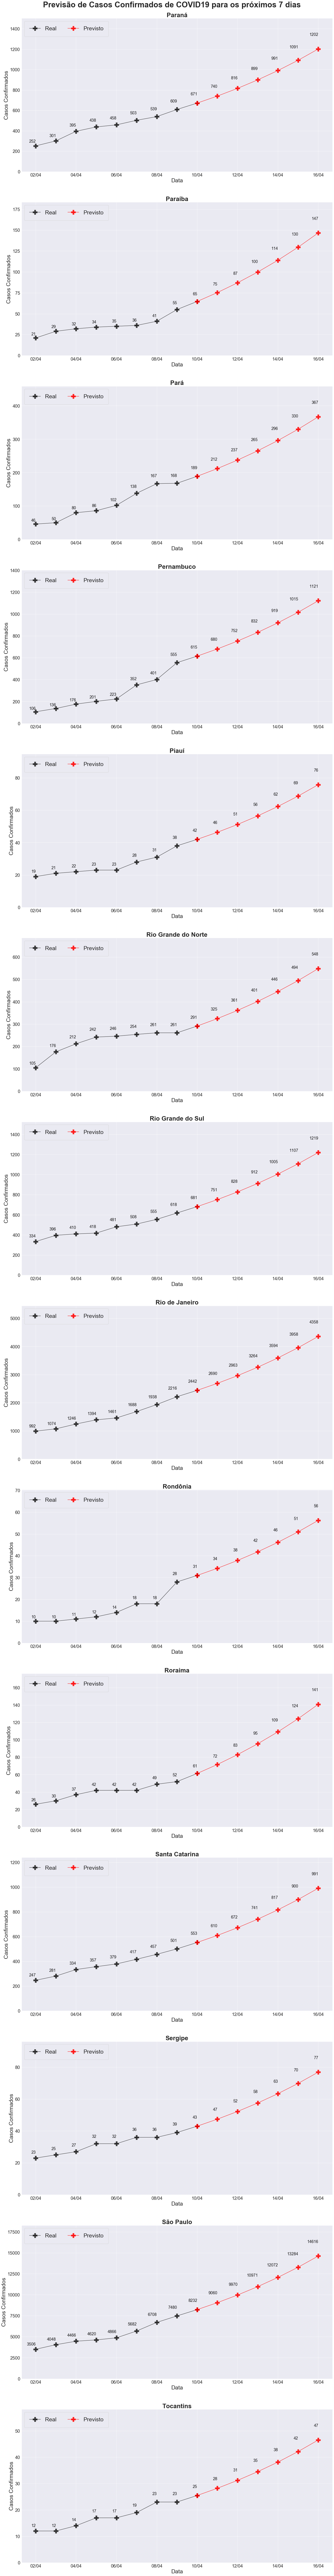

In [65]:
fig , ax = plt.subplots(ncols=1,nrows=14,figsize=(25,210))
fig.suptitle("Previsão de Casos Confirmados de COVID19 para os próximos {} dias".format(dias),fontsize=35,y=0.885,weight='bold')
sns.set_style("darkgrid")

#Selecionando os estados para previsão
estados = ['Paraná','Paraíba', 'Pará', 'Pernambuco', 'Piauí','Rio Grande do Norte','Rio Grande do Sul',
           'Rio de Janeiro','Rondônia','Roraima','Santa Catarina', 'Sergipe', 'São Paulo', 'Tocantins']

for est in range(0,len(estados)):
    
    #Definindo o período para mostrar no gráfico
    ult_dias = 15
    fore = allforecast[allforecast['date']>allforecast[allforecast['Day']==allforecast.Day.max()-ult_dias].date.tail(1).values[0]].reset_index(drop=True)
    
    #Selecionando cada estado para forecast
    fore = fore[fore['state']==estados[est]].reset_index(drop=True)

    #Configurando o formato da data que desejo mostrar no gráfico
    dateview = [fore.date[x].strftime("%d/%m") for x in range(0,len(fore.date))]

    sns.lineplot(x=fore.date[:-dias+1],y=fore.cases[:-dias+1],color="black",marker='P',markersize=22,label="Real",alpha=0.75,ax=ax[est])
    sns.lineplot(x=fore.date[-dias:],y=fore.cases[-dias:],color="red",marker='P',markersize=22,label="Previsto",alpha=0.85,ax=ax[est])
    ax[est].set_title("{}".format(estados[est]),fontsize=28,weight='bold')
    ax[est].set_ylim(0,fore.cases.max()*1.25)
    ax[est].set_xlabel('Data',fontsize=25)
    ax[est].set_ylabel('Casos Confirmados',fontsize=25)
    ax[est].tick_params(axis='x',labelsize=20)
    ax[est].tick_params(axis='y',labelsize=20)
    ax[est].set_xticks(fore.date[::-2])
    ax[est].set_xticklabels(dateview[::-2])
    ax[est].legend(ncol=2,fontsize=25,borderpad=0.925,loc='upper left')

    #Exibindo valores de todos os dias
    for i in range(1,ult_dias+1):
        ax[est].annotate('{:.0f}'.format(fore.cases.tail(i).values[0]),xy=(fore.date.tail(i).values[0],fore.cases.tail(i).values[0]*1.10),
                    size=18,ha='right',va='bottom',color='black',alpha=.9)

plt.show()

# 

## Linear Regression

In [66]:
#Carregando e visualizando parâmetros do modelo
model = joblib.load("model_LR.pkl")
print(model,"\n\n",model.coef_)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False) 

 [ 1.13311038e+00 -1.10588610e+00 -1.06735925e+00 -1.23131282e+00
  4.70736637e-05 -1.12315682e+00  5.61144712e-01  4.86835674e-02
 -9.86049565e-01 -1.52535124e+00]


In [67]:
#Variáveis do Modelo
#['Cases_Last_Day', 'UF_CAT_AL', 'UF_CAT_TO', 'UF_CAT_SE', 'DIST_CE', 'UF_CAT_RO', 'Mes', 'UF_CAT_AP', 'UF_CAT_PB', 'UF_CAT_AC']

In [68]:
tot_cases=[]
allforecast=date_state.copy()

ufs=['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT','MS', 'MG', 'PR', 'PB', 'PA', 'PE', 'PI', 'RN', 'RS', 'RO','RR', 'SC', 'SE', 'TO', 'RJ', 'SP']
#ufs=['SP']

for i in range(0,len(ufs)):
    
    
    #Selecionando as features finais do modelo e as variáveis dia/data para definir a previsão e estado/uf para especificidade
    forecast=date_state[['Day','date','state','UF','cases','Cases_Last_Day', 'UF_CAT_AL', 'UF_CAT_TO', 'UF_CAT_SE',
                         'DIST_CE', 'UF_CAT_RO', 'Mes', 'UF_CAT_AP', 'UF_CAT_PB', 'UF_CAT_AC']]
    
    #Selecionando dados a partir do primeiro caso confirmado no Brasil
    forecast = forecast[forecast['date']>='2020-02-26'].reset_index(drop=True,level=0)

    #Definindo a UF do estado para previsão
    uf=ufs[i]
    forecast=forecast[forecast['UF']==uf]

    #Definindo dias para previsão
    dias=7

    for i in range(0,dias):

        #Preparando os dados para a previsão
        #'Cases_Last_Day'
        cld=forecast.groupby('state').cases.last()[0]
        #'Mês'
        mes=forecast.groupby('state').date.last()[0].month
        #'DIST_CE'
        distce=forecast.groupby('state').DIST_CE.last()[0]
        #'UF_CAT_SE'
        ufse = 1 if uf=='SE' else 0   
        #'UF_CAT_AP'
        ufap = 1 if uf=='AP' else 0
        #'UF_CAT_AL'
        ufal = 1 if uf=='AL' else 0      
        #'UF_CAT_TO'
        ufto = 1 if uf=='TO' else 0         
        #'UF_CAT_AC'
        ufac = 1 if uf=='AC' else 0 
        #'UF_CAT_RO'
        ufro = 1 if uf=='RO' else 0         
        #'UF_CAT_PB'
        ufpb = 1 if uf=='PB' else 0       

        #Previsão para o próximo dia e ajuste no dataset com as informações
        dia=forecast.Day.max()+1
        estado=forecast.state.tail(1).values[0]
        prev=model.predict([[cld,ufal,ufto,ufse,distce,ufro,mes,ufap,ufpb,ufac]])[0]     
        
        att=pd.DataFrame({'Day':dia,'date':pd.date_range(date_state.date.max(), periods=i+2).tolist()[-1],'state':estado,'UF':uf,
                          'cases':prev,'Cases_Last_Day':forecast.cases.tail(1).values[0],
                          'Mes':forecast.groupby('state').date.last()[0].month,'DIST_CE':np.nan,
                          'UF_CAT_TO':np.nan,'UF_CAT_SE':np.nan,'UF_CAT_RO':np.nan,'UF_CAT_AP':np.nan,
                          'UF_CAT_PB':np.nan,'UF_CAT_AC':np.nan,'UF_CAT_AL':np.nan},index=[0])
        
        forecast=pd.concat([forecast,att]).reset_index(level=0,drop=True)

        forecast['DIST_CE'] = forecast.groupby('state').DIST_CE.last()[0]      
        forecast['UF_CAT_SE'] = 1 if uf=='SE' else 0
        forecast['UF_CAT_AP'] = 1 if uf=='AP' else 0 
        forecast['UF_CAT_AL'] = 1 if uf=='AL' else 0
        forecast['UF_CAT_PB'] = 1 if uf=='PB' else 0
        forecast['UF_CAT_RO'] = 1 if uf=='RO' else 0        
        forecast['UF_CAT_TO'] = 1 if uf=='TO' else 0
        forecast['UF_CAT_AC'] = 1 if uf=='AC' else 0
        forecast = forecast.fillna(0)

    tot_cases.append(forecast.cases.tail(1).values[0])
    new=forecast[forecast['Day']>71]
    allforecast=pd.concat([allforecast,new]).reset_index(level=0,drop=True)

print("\nTotal de casos confirmados no Brasil para daqui {} dias : {}\n".format(dias,sum(tot_cases)))
forecast.tail(dias+3)


Total de casos confirmados no Brasil para daqui 7 dias : 43272.77664512096



Day       date      state  UF         cases  Cases_Last_Day  UF_CAT_AL  \
41   69 2020-04-07  São Paulo  SP   5682.000000     4866.000000          0   
42   70 2020-04-08  São Paulo  SP   6708.000000     5682.000000          0   
43   71 2020-04-09  São Paulo  SP   7480.000000     6708.000000          0   
44   72 2020-04-10  São Paulo  SP   8477.524771     7480.000000          0   
45   73 2020-04-11  São Paulo  SP   9607.830442     8477.524771          0   
46   74 2020-04-12  São Paulo  SP  10888.591529     9607.830442          0   
47   75 2020-04-13  São Paulo  SP  12339.835211    10888.591529          0   
48   76 2020-04-14  São Paulo  SP  13984.254488    12339.835211          0   
49   77 2020-04-15  São Paulo  SP  15847.563039    13984.254488          0   
50   78 2020-04-16  São Paulo  SP  17958.897297    15847.563039          0   

    UF_CAT_TO  UF_CAT_SE      DIST_CE  UF_CAT_RO  Mes  UF_CAT_AP  UF_CAT_PB  \
41          0          0  2148.752432          0    4          0          0   
42          0          0  2148.752432          0    4          0          0   
43          0          0  2148.752432          0    4          0          0   
44          0          0  2148.752432          0    4          0          0   
45          0          0  2148.752432          0    4          0          0   
46          0          0  2148.752432          0    4          0          0   
47          0          0  2148.752432          0    4          0          0   
48          0          0  2148.752432          0    4          0          0   
49          0          0  2148.752432          0    4          0          0   
50          0          0  2148.752432          0    4          0          0   

    UF_CAT_AC  
41          0  
42          0  
43          0  
44          0  
45          0  
46          0  
47          0  
48          0  
49          0  
50          0

## Previsão do número de casos no Brasil para os próximos 7 dias

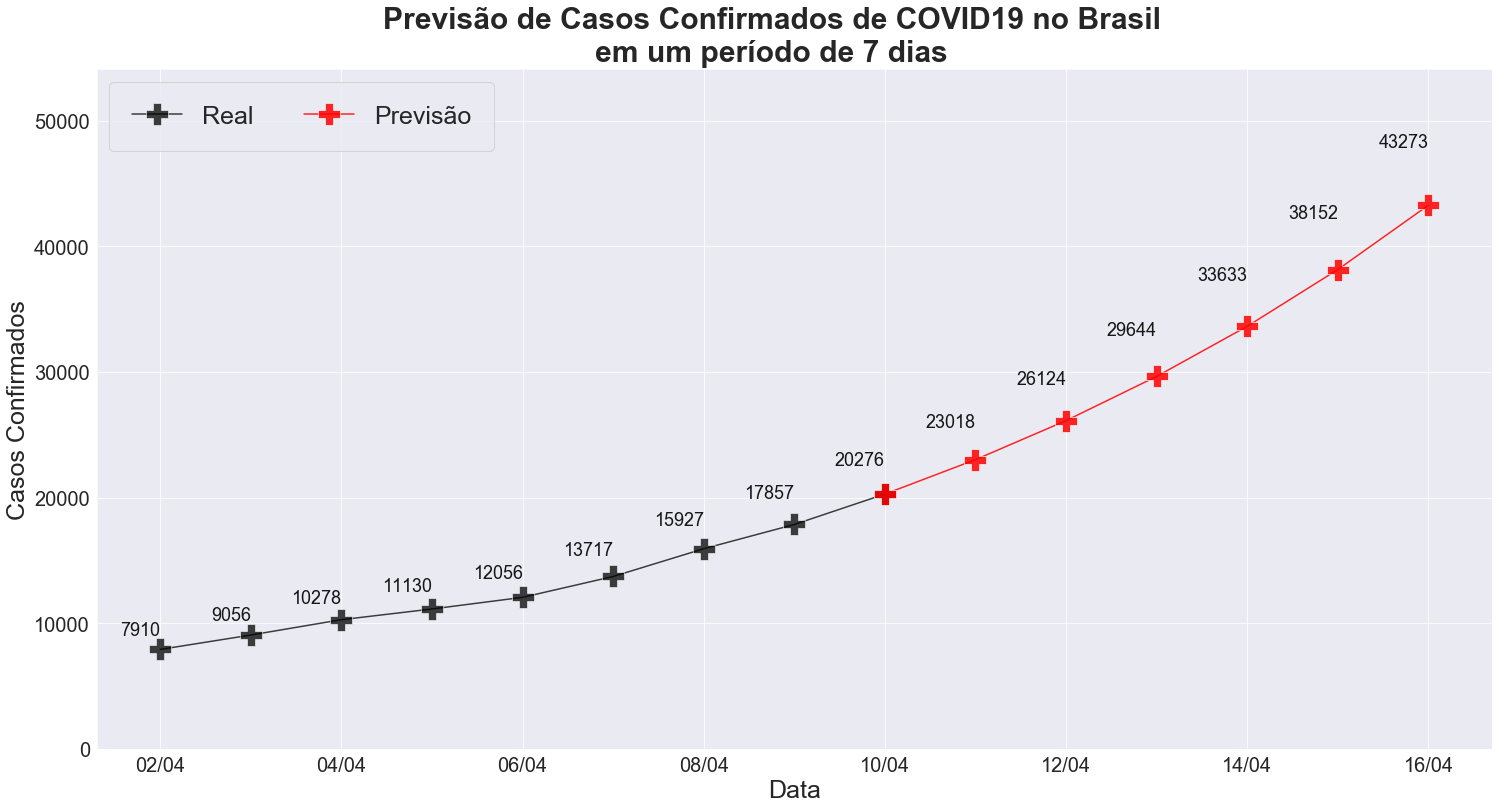

In [70]:
#Soma de casos confirmado no Brasil
br_forecast = allforecast.groupby(['date'])[['cases']].sum().reset_index()

#Definindo o período para mostrar no gráfico
ult_dias = 15
br_forecast = br_forecast[br_forecast['date']>allforecast[allforecast['Day']==allforecast.Day.max()-ult_dias].date.tail(1).values[0]].reset_index(drop=True)

#Configurando o formato da data que desejo mostrar no gráfico
dateview = [br_forecast.date[x].strftime("%d/%m") for x in range(0,len(br_forecast.date))]

fig , ax = plt.subplots(figsize=(25,12.5))
fig.suptitle("Previsão de Casos Confirmados de COVID19 no Brasil\nem um período de {} dias".format(dias),fontsize=30,y=0.95,weight='bold')

sns.set_style("darkgrid")
sns.lineplot(x=br_forecast.date[:-dias+1],y=br_forecast.cases[:-dias+1],color="black",marker='P',markersize=22,label="Real",alpha=0.75)
sns.lineplot(x=br_forecast.date[-dias:],y=br_forecast.cases[-dias:],color="red",marker='P',markersize=22,label="Previsão",alpha=0.85)
ax.set_ylim(0,br_forecast.cases.max()*1.25)
ax.set_xlabel('Data',fontsize=25)
ax.set_ylabel('Casos Confirmados',fontsize=25)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)
ax.set_xticks(br_forecast.date[::-2])
ax.set_xticklabels(dateview[::-2])
ax.legend(ncol=2,fontsize=25,borderpad=0.925,loc='upper left')
        
#Exibindo valores de todos os dias
for i in range(1,ult_dias+1):
    ax.annotate('{:.0f}'.format(br_forecast.cases.tail(i).values[0]),xy=(br_forecast.date.tail(i).values[0],br_forecast.cases.tail(i).values[0]*1.10),
                size=18,ha='right',va='bottom',color='black',alpha=.9)

plt.show()

# 

## XGBoost Regressor

In [71]:
model = joblib.load("model_XGB.pkl")
model

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=75, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

Feature: 0, Score: 0.89956
Feature: 1, Score: 0.00009
Feature: 2, Score: 0.00026
Feature: 3, Score: 0.00013
Feature: 4, Score: 0.09659
Feature: 5, Score: 0.00322
Feature: 6, Score: 0.00015


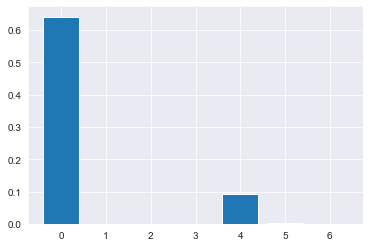

In [103]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], np.log1p(importance))
plt.show()

In [72]:
#Variáveis do modelo
#['Cases_Last_Day', 'Semana_do_Ano', 'Diff_Cases_Last_Day', 'REG_CAT_Sul', 'Desvio_Diff_Cases_Last_Days_7', 'Mean_Cases_Last_Days_7', 'Mes']

In [73]:
tot_cases=[]
allforecast=date_state.copy()

ufs=['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT','MS', 'MG', 'PR', 'PB', 'PA', 'PE', 'PI', 'RN', 'RS', 'RO','RR', 'SC', 'SE', 'TO', 'SP', 'RJ']
#ufs=['RJ']

for i in range(0,len(ufs)):
    
    #Selecionando as features finais do modelo e as variáveis dia/data para definir a previsão e estado/uf para especificidade
    forecast=date_state[['Day','date','state','UF','cases','Cases_Last_Day', 'Semana_do_Ano', 'Diff_Cases_Last_Day',
                         'REG_CAT_Sul', 'Mean_Cases_Last_Days_7', 'Desvio_Diff_Cases_Last_Days_7', 'Mes']]
    
    #Selecionando dados a partir do primeiro caso confirmado no Brasil
    forecast = forecast[forecast['date']>='2020-02-26'].reset_index(drop=True,level=0)

    #Definindo a UF do estado para previsão
    uf=ufs[i]
    forecast=forecast[forecast['UF']==uf]

    #Definindo dias para previsão
    dias=7

    for i in range(0,dias):

        #Preparando os dados para a previsão
        #'Cases_Last_Day'
        cld=forecast.groupby('state').cases.last()[0]
        #'Mês'
        mes=forecast.groupby('state').date.last()[0].month
        #'Semana_do_Ano'
        sem=forecast.groupby('state').date.last()[0].weekofyear
        #'REG_CAT_Sul'
        sul=forecast.groupby('state').REG_CAT_Sul.last()[0]
        #'Mean_Cases_Last_Days_7'
        mcl7d=forecast.cases.rolling(7).mean().tail(1).values[0]              
        #'Diff_Cases_Last_Day'
        difcld=forecast.cases.diff().tail(1).values[0]       
        #'Desvio_Diff_Cases_Last_Days_7'
        ddifcl7d=forecast.Diff_Cases_Last_Day.rolling(7).std().tail(1).values[0]          

        #Previsão para o próximo dia e ajuste no dataset com as informações
        dia=forecast.Day.max()+1
        estado=forecast.state.tail(1).values[0]
        prev=model.predict(pd.Series([cld,sem,difcld,sul,ddifcl7d,mcl7d,mes]))[0] 
        
        att=pd.DataFrame({'Day':dia,'date':pd.date_range(date_state.date.max(), periods=i+2).tolist()[-1],'state':estado,'UF':uf,
                          'cases':prev,'Cases_Last_Day':forecast.cases.tail(1).values[0],
                          'Mes':forecast.groupby('state').date.last()[0].month,'Semana_do_Ano':forecast.groupby('state').date.last()[0].weekofyear,
                          'Diff_Cases_Last_Day':np.nan,'Mean_Cases_Last_Days_7':np.nan, 'Desvio_Diff_Cases_Last_Days_7':np.nan,
                          'REG_CAT_Sul':np.nan},index=[0])

        forecast=pd.concat([forecast,att]).reset_index(level=0,drop=True)

        forecast['REG_CAT_Sul'] = forecast.groupby('state').REG_CAT_Sul.last()[0]
        forecast['Diff_Cases_Last_Day'] = forecast.groupby('state').Cases_Last_Day.diff()
        forecast['Mean_Cases_Last_Days_7'] = forecast.Cases_Last_Day.rolling(7).mean()
        forecast['Desvio_Diff_Cases_Last_Days_7'] = forecast.Diff_Cases_Last_Day.rolling(7).std()
        forecast = forecast.fillna(0)

    tot_cases.append(forecast.cases.tail(1).values[0])
    new=forecast[forecast['Day']>71]
    allforecast=pd.concat([allforecast,new]).reset_index(level=0,drop=True)

print("\nTotal de casos confirmados no Brasil para daqui {} dias : {}\n".format(dias,sum(tot_cases)))
forecast.tail(dias+3)


Total de casos confirmados no Brasil para daqui 7 dias : 32311.161960601807



Day       date           state  UF        cases  Cases_Last_Day  \
41   69 2020-04-07  Rio de Janeiro  RJ  1688.000000     1461.000000   
42   70 2020-04-08  Rio de Janeiro  RJ  1938.000000     1688.000000   
43   71 2020-04-09  Rio de Janeiro  RJ  2216.000000     1938.000000   
44   72 2020-04-10  Rio de Janeiro  RJ  3126.836182     2216.000000   
45   73 2020-04-11  Rio de Janeiro  RJ  3397.924561     3126.836182   
46   74 2020-04-12  Rio de Janeiro  RJ  4070.672852     3397.924561   
47   75 2020-04-13  Rio de Janeiro  RJ  4433.991211     4070.672852   
48   76 2020-04-14  Rio de Janeiro  RJ  4612.568359     4433.991211   
49   77 2020-04-15  Rio de Janeiro  RJ  4865.866211     4612.568359   
50   78 2020-04-16  Rio de Janeiro  RJ  5674.452148     4865.866211   

    Semana_do_Ano  Diff_Cases_Last_Day  REG_CAT_Sul  Mean_Cases_Last_Days_7  \
41             15            67.000000          0.0             1101.000000   
42             15           227.000000          0.0             1241.000000   
43             15           250.000000          0.0             1399.000000   
44             15           278.000000          0.0             1573.857143   
45             15           910.836182          0.0             1867.119455   
46             15           271.088379          0.0             2174.537249   
47             15           672.748291          0.0             2556.919085   
48             16           363.318359          0.0             2981.632115   
49             16           178.577148          0.0             3399.427595   
50             16           253.297852          0.0             3817.694196   

    Desvio_Diff_Cases_Last_Days_7  Mes  
41                      48.188618    4  
42                      54.781384    4  
43                      67.801180    4  
44                      81.638285    4  
45                     281.334044    4  
46                     276.669947    4  
47                     296.645873    4  
48                     263.421983    4  
49                     270.032192    4  
50                     269.693314    4

## Previsão do número de casos no Brasil para os próximos 7 dias

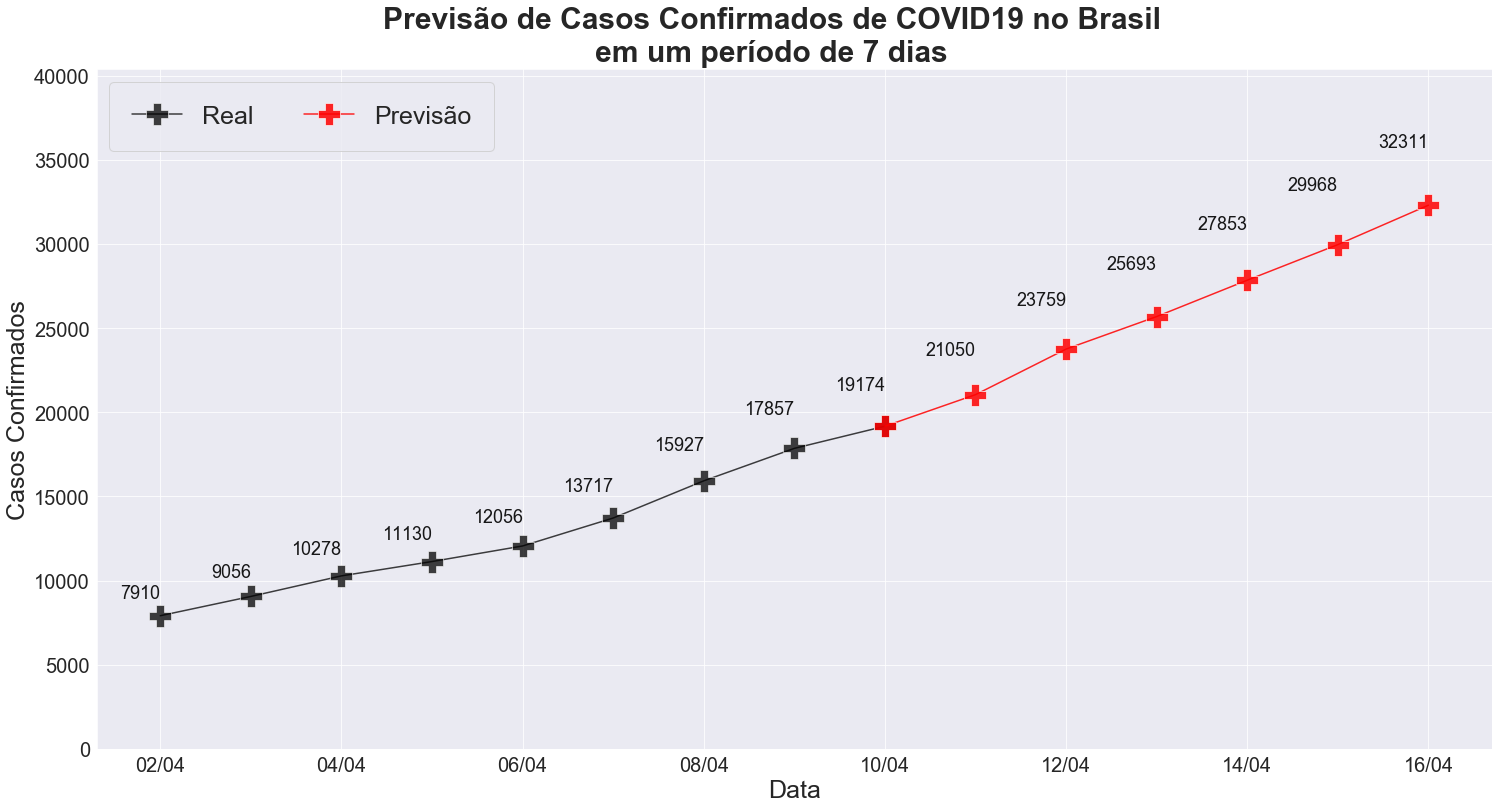

In [74]:
#Soma de casos confirmado no Brasil
br_forecast = allforecast.groupby(['date'])[['cases']].sum().reset_index()

#Definindo o período para mostrar no gráfico
ult_dias = 15
br_forecast = br_forecast[br_forecast['date']>allforecast[allforecast['Day']==allforecast.Day.max()-ult_dias].date.tail(1).values[0]].reset_index(drop=True)

#Configurando o formato da data que desejo mostrar no gráfico
dateview = [br_forecast.date[x].strftime("%d/%m") for x in range(0,len(br_forecast.date))]

fig , ax = plt.subplots(figsize=(25,12.5))
fig.suptitle("Previsão de Casos Confirmados de COVID19 no Brasil\nem um período de {} dias".format(dias),fontsize=30,y=0.95,weight='bold')

sns.set_style("darkgrid")
sns.lineplot(x=br_forecast.date[:-dias+1],y=br_forecast.cases[:-dias+1],color="black",marker='P',markersize=22,label="Real",alpha=0.75)
sns.lineplot(x=br_forecast.date[-dias:],y=br_forecast.cases[-dias:],color="red",marker='P',markersize=22,label="Previsão",alpha=0.85)
ax.set_ylim(0,br_forecast.cases.max()*1.25)
ax.set_xlabel('Data',fontsize=25)
ax.set_ylabel('Casos Confirmados',fontsize=25)
ax.tick_params(axis='x',labelsize=20)
ax.tick_params(axis='y',labelsize=20)
ax.set_xticks(br_forecast.date[::-2])
ax.set_xticklabels(dateview[::-2])
ax.legend(ncol=2,fontsize=25,borderpad=0.925,loc='upper left')
        
#Exibindo valores de todos os dias
for i in range(1,ult_dias+1):
    ax.annotate('{:.0f}'.format(br_forecast.cases.tail(i).values[0]),xy=(br_forecast.date.tail(i).values[0],br_forecast.cases.tail(i).values[0]*1.10),
                size=18,ha='right',va='bottom',color='black',alpha=.9)

plt.show()

# 

# Considerações Finais do Projeto

## Utilidade do projeto :
### - As previsões podem ajudar na tomada de decisão dos orgãos da saúde em busca de uma quantidade x de leitos e testes para o COVID19, adequação das medidas de isolamento social por região e entre outras demandas que surgem com a pandemia. Especificando essas previsões também para os municípios essas medidas se tornariam ainda mais efetivas.
### - O script pode ser usado sem dificuldades para o usuário que desejar continuar com o projeto, atualizando os dados, fazendo modificações e melhorando os resultados.
### - O código pode ser facilmente modificado para prever também o número de mortes.
### - Muitos conceitos e visualizações podem ser utilizados como referência para outros problemas de Time Series e Machine Learning.

## 

## Upgrades que podem ser feitos com mais tempo :

## Melhorar a Precisão da Previsão
### - Adicionar novas variáveis significativas.
### - Testar outros algoritmos e modelos.
### - Mudar a target para a quantidade de novos casos em vez da soma acumulada de casos.

## Melhorar o Projeto
### - Explorar ainda mais a base de dados com informações dos municípios realizando previsões para eles.

## Melhorar o Produto Final
### - Entregar as visualizações das previsões dos próximos x dias em um site, onde os usuários possam interagir.